# Использование диффузионных моделей для непарного переноса стиля

Работа выполнена как реализация домашнего задания из курса НИУ ВШЭ ФКНа "Генеративные модели на основе диффузии".

In [3]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

## Загрузка Датасета

In [5]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [6]:
transform = Compose([Resize((32, 32)), ToTensor()])
# data_train = ColoredMNIST(root='.', train=True, download=False, transform=transform)
data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.1MB/s]


Extracting ./ColoredMNIST/raw/train-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 433kB/s]


Extracting ./ColoredMNIST/raw/train-labels-idx1-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]


Extracting ./ColoredMNIST/raw/t10k-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.80MB/s]


Extracting ./ColoredMNIST/raw/t10k-labels-idx1-ubyte.gz to ./ColoredMNIST/raw



In [7]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()


### Загрузка редобученной диффузионной модели



Используется надстройку над архитектурой, которая делает все необходимые преобразования над входами: нормирование, взятие логарифма от уровня шума и т.д. Ее имплементация на этот раз взята из репозитория EDM. 

In [8]:
!git clone https://github.com/NVlabs/edm
!cp edm/training/networks.py edm/training/networks_copy.py
!cp fid.py edm/fid.py

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [9]:
def append_code(in_files, out_file):
    lines = ['\n']
    for in_file in in_files:
        with open(in_file, 'r') as f:
            for line in f:
                lines.append(line)

    with open(out_file, 'w') as f:
        for line in lines:
            f.write(line)

append_code(['edm/training/networks_copy.py', 'cunet.py'], 'edm/training/networks.py')

In [10]:
import pickle
%cd edm
from training.networks import EDMPrecond
from torch_utils import misc
from dnnlib import util
%cd ..

cond_model = EDMPrecond(img_resolution=32, img_channels=3, model_type='CUNet', noise_channels=128, base_factor=64, emb_channels=128, label_dim=11)
cond_model.eval().cuda()

with util.open_url('cond_cunet.pkl') as f:
    data = pickle.load(f)

misc.copy_params_and_buffers(src_module=data['ema'], dst_module=cond_model, require_all=True)
print(f"Модель имеет {sum(p.numel() for p in cond_model.parameters())} параметров")

/content/edm
/content
Модель имеет 17549763 параметров


Возьмем слегка модифицированный код для генерации и визуализации из семинара и посмотрим, как работает модель:

In [11]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

def velocity_from_denoiser(x, model, sigma, class_labels=None, error_eps=1e-4, stochastic=False, cfg=0.0, **model_kwargs):
    sigma = sigma[:, None, None, None]
    cond_v = (-model(x, sigma, class_labels, **model_kwargs) + x) / (sigma + error_eps)

    if cfg > 0.0:
        dummy_labels = torch.zeros_like(class_labels)
        dummy_labels[:, -1] = 1
        uncond_v = (-model(x, sigma, dummy_labels, **model_kwargs) + x) / (sigma + error_eps)
        v = cond_v + cfg * (cond_v - uncond_v)
    else:
        v = cond_v

    if stochastic:
        v = v * 2

    return v

def get_timesteps(params):
    num_steps = params['num_steps']
    sigma_min, sigma_max = params['sigma_min'], params['sigma_max']
    rho = params['rho']

    step_indices = torch.arange(num_steps, device=params['device'])
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    return t_steps

def sample_euler(model, noise, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params)
    x = noise * params['sigma_max']
    x_history = [normalize(noise)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], cfg=params['cfg'], **model_kwargs) * (t_next - t_cur)
            if params['stochastic']:
                x = x + torch.randn_like(x) * torch.sqrt(torch.abs(t_next - t_cur) * 2 * t_cur)
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def visualize_model_samples(model, params, labels_usage='dummy', class_labels=None, title='Семплы из модели', **model_kwargs):
    noise = torch.randn(40, 3, 32, 32, device=params['device'])
    if class_labels is None and labels_usage == 'dummy':
        class_labels = torch.zeros(40, 11, device=params['device'])
        class_labels[:, -1] = 1
    elif labels_usage == 'random':
        class_labels = torch.randint(low=0, high=10, size=(40,), device=params['device'])
        class_labels = (class_labels[:, None] == torch.arange(11, device=params['device'])[None, :]).float()

    out, trajectory = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
    out = out * 0.5 + 0.5
    visualize_batch(out.detach().cpu(), title=title)

Визуализируем условные семплы из модели (мы будем использовать коэффициент classifier-free guidance, равный 1).

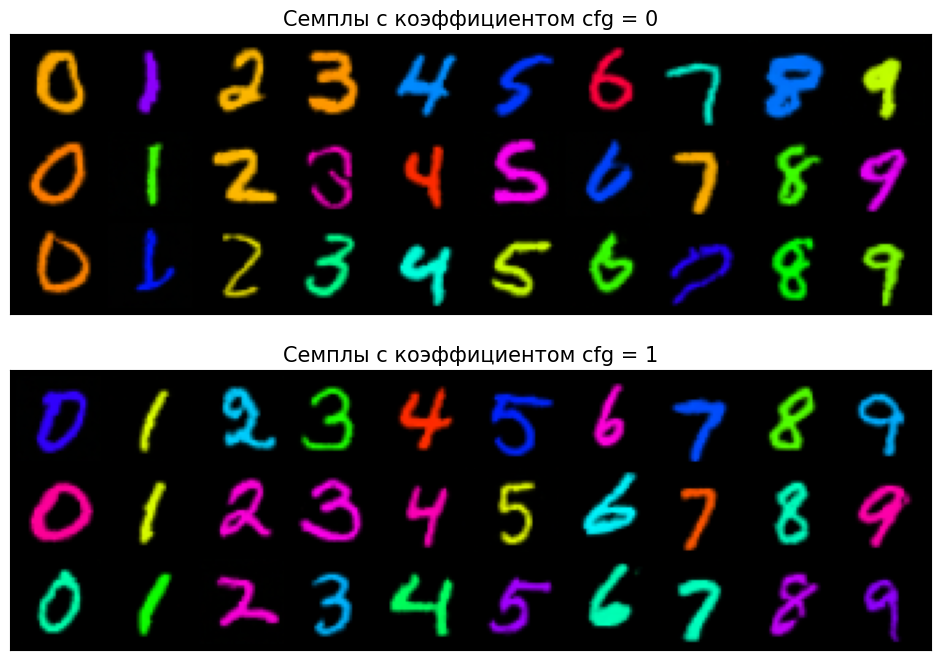

In [12]:
def visualize_cond_samples(model, params, n_samples=3, cfgs=[0.0, 0.5, 1.0, 2.0], **model_kwargs):
    fig, ax = plt.subplots(len(cfgs), figsize=(12, 8))
    for i in range(len(cfgs)):
        remove_ticks(ax[i])
        ax[i].set_title('Семплы с коэффициентом cfg = %.4g' % cfgs[i], fontsize=15)

    for i in range(len(cfgs)):
        cfg = cfgs[i]
        noise = torch.randn(n_samples * 10, 3, 32, 32, device=params['device'])
        class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(n_samples, 1, 1).reshape(-1, 11).float().to(params['device'])
        params['cfg'] = cfgs[i]
        img, _ = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
        img = img * 0.5 + 0.5
        img_grid = make_grid(img, nrow=10)
        ax[i].imshow(img_grid.permute(1, 2, 0).detach().cpu())

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
}
visualize_cond_samples(cond_model, sampling_params, cfgs=[0.0, 1.0])

## SDEdit

Оба метода основываются на одной и той же идее: если у нас есть диффузионная модель, способная генерировать тройки (например, безусловная модель, обученная на тройках, или условная модель, обученная на всем датасете), то чисто теоретически можно превратить любую цифру в тройку следующим образом:
* Зашумить цифру $\mathbf{X}$ до такого уровня $t$, что очертания, позволяющие определить цифру по $\mathbf{X} + t \varepsilon$, размываются, но остаются различимыми такие более общие черты, как цвет/толщина и т.д.;
* Запустить с помощью "троечной" диффузионной модели процесс расшумления, начав его с момента времени $t$ и семпла $\mathbf{X}_t$.

В идеале, генерация с помощью троечной диффузионной модели позволит нам получить правдоподобную тройку, а черты, оставшиеся в картинке после зашумления, позволят на каком-то уровне сохранить стиль исходной цифры. Данный метод называется [SDEdit](https://arxiv.org/abs/2108.01073).

In [ ]:
def sdedit(model, x_source, target_label, params):
    noise = torch.randn_like(x_source).to('cuda')
    noisy_image = (x_source + noise * params['sigma_max'])/params['sigma_max']
    class_labels = torch.zeros([1, 11], device=params['device'])
    class_labels[0][target_label] = 1
    out, _ = sample_euler(model, noise, params, class_labels)
    return out


In [14]:
def visualize_transform(batch, batch_out, title = None):
    batch_cat = torch.cat((batch, batch_out), dim=0)
    image_grid = make_grid(batch_cat.cpu(), nrow=len(batch))
    fig, ax = plt.subplots(figsize=(3 * len(batch), 3))
    remove_ticks(ax)
    ax.imshow(image_grid.permute(1, 2, 0))
    if title is not None:
      plt.title(title)
    plt.show()

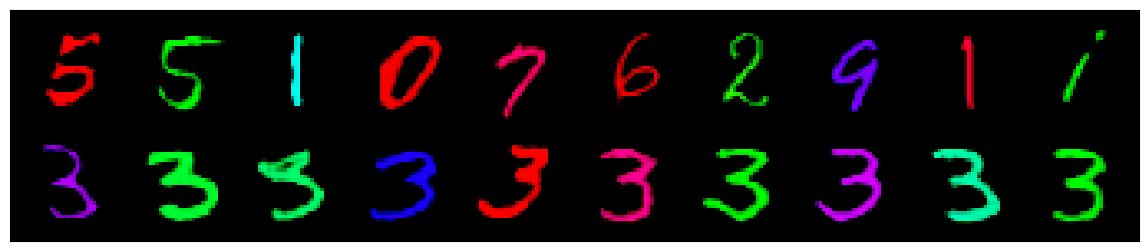

In [15]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 40,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 1.0
}

x_source = (next(iter(train_dataloader))[0] * 2 - 1).cuda()[:10]
x_out = sdedit(cond_model, x_source, target_label=3, params=sampling_params)
visualize_transform(x_source, x_out)

In [ ]:
t_range = np.round(np.concatenate([np.linspace(1, 12, 3), np.exp(np.linspace(np.log(15), np.log(80), 5))]))
print(t_range)

[ 1.  6. 12. 15. 23. 35. 53. 80.]


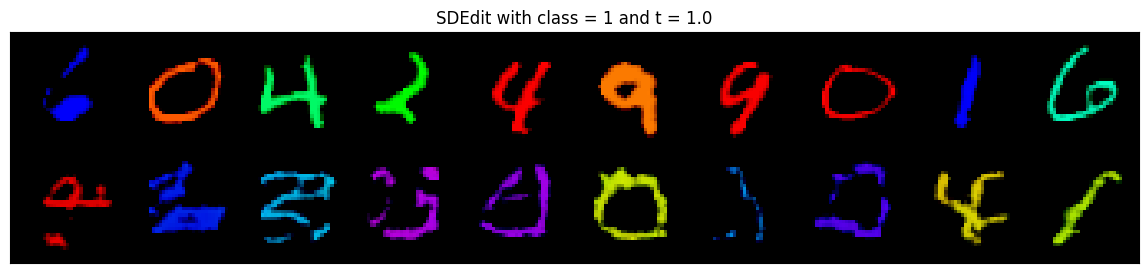

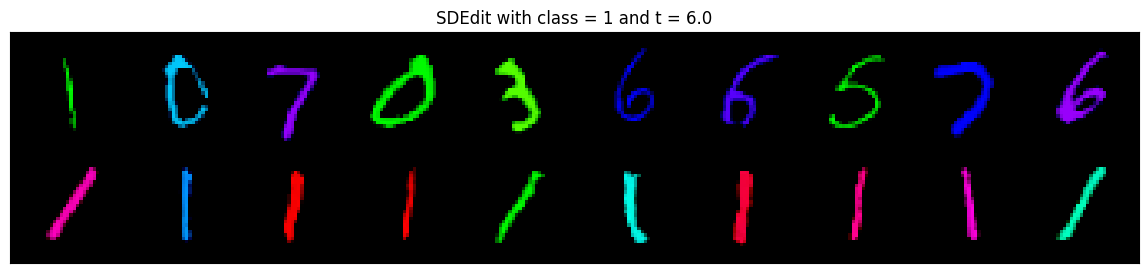

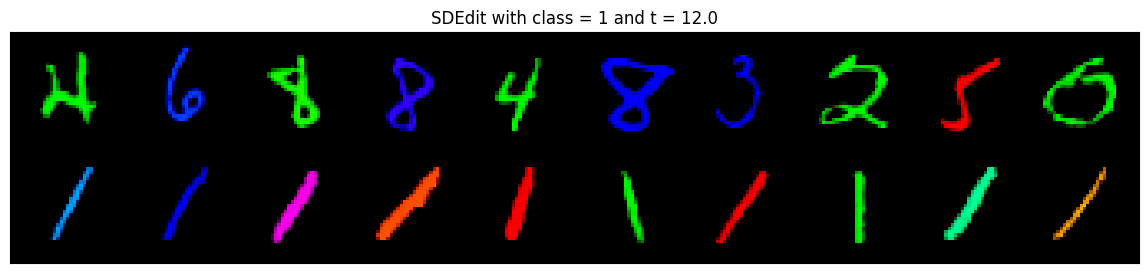

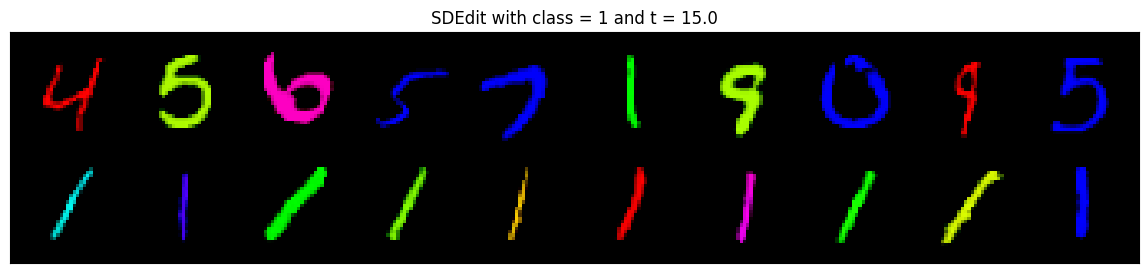

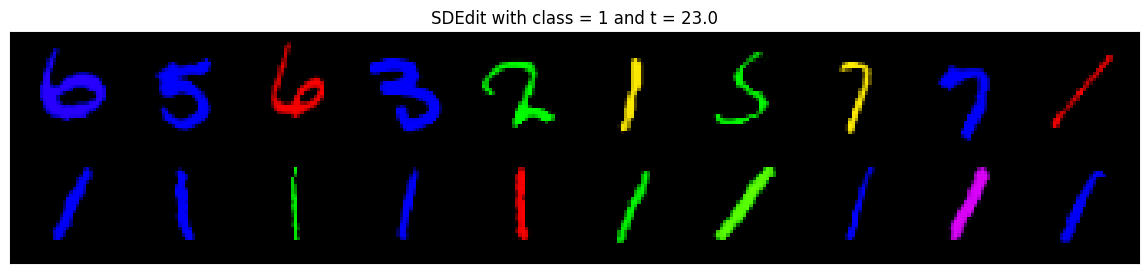

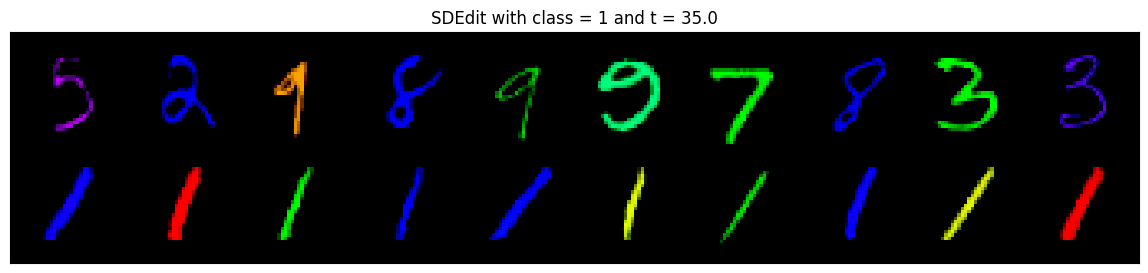

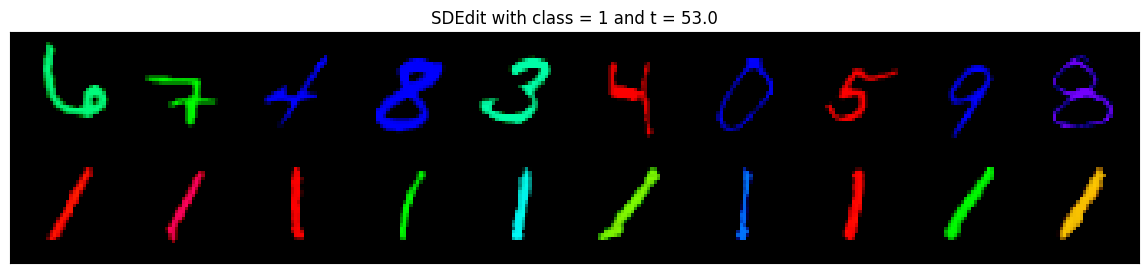

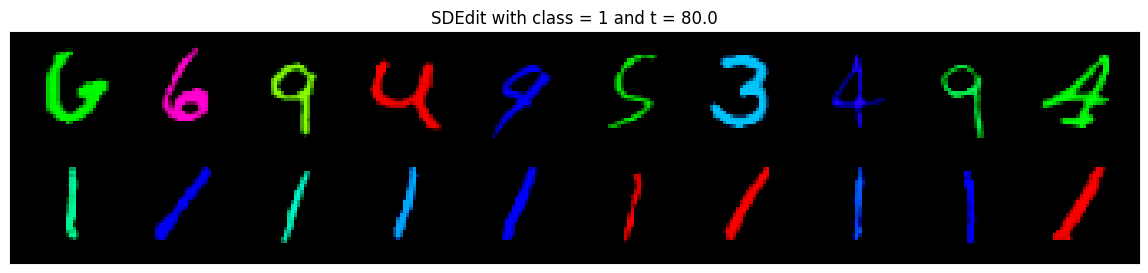

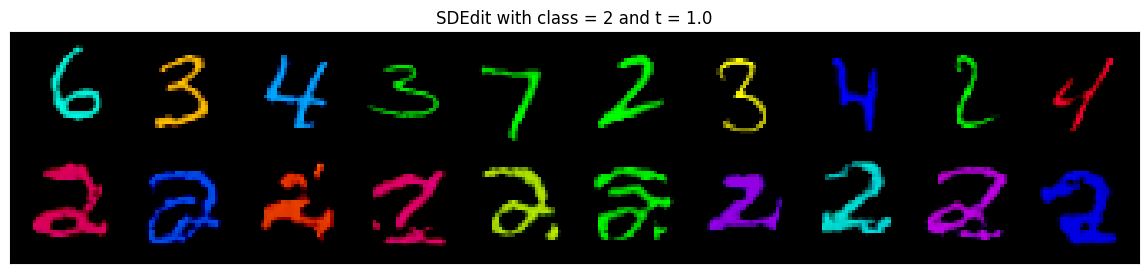

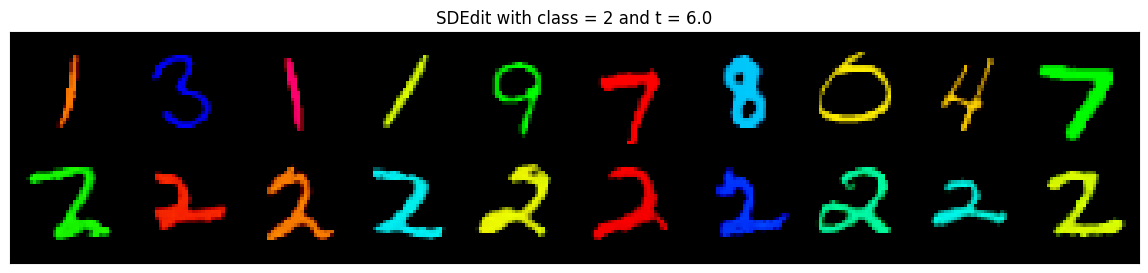

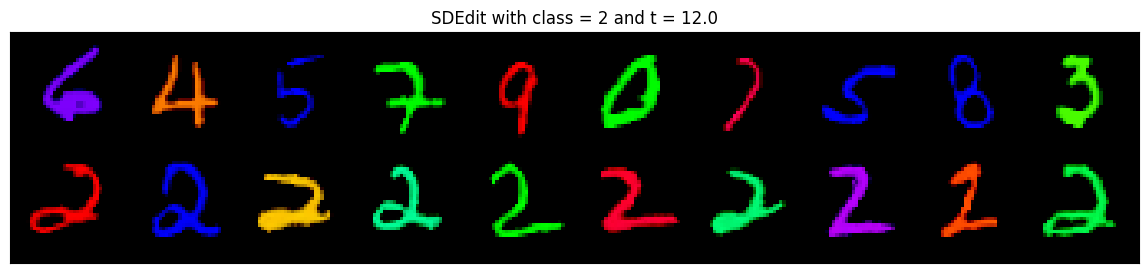

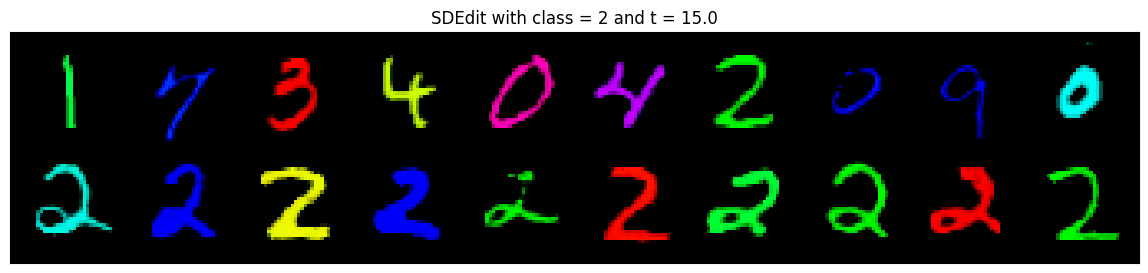

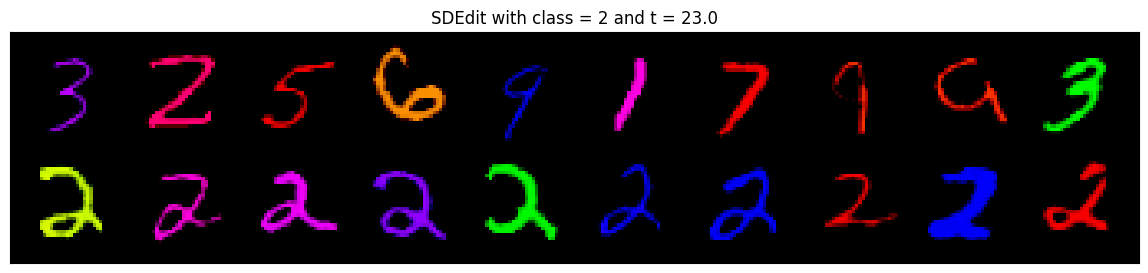

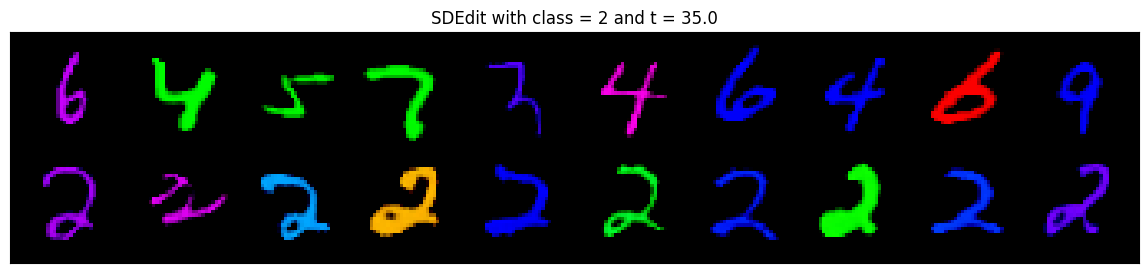

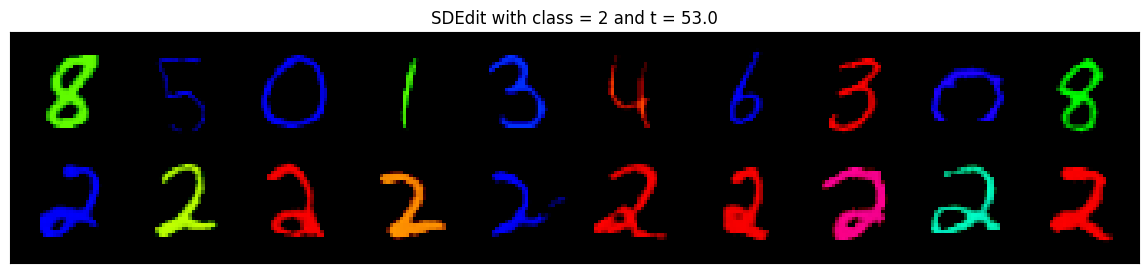

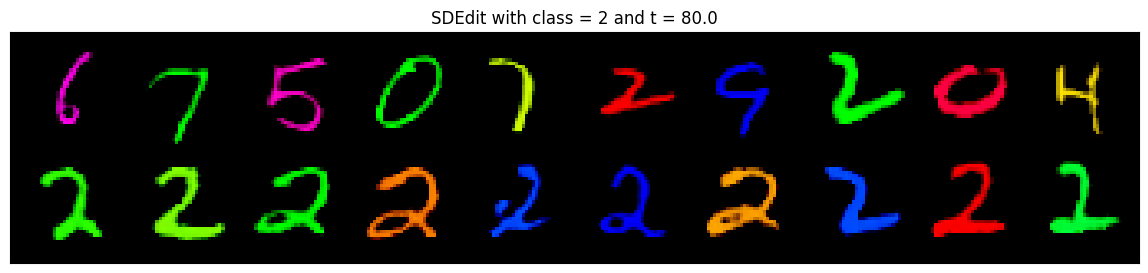

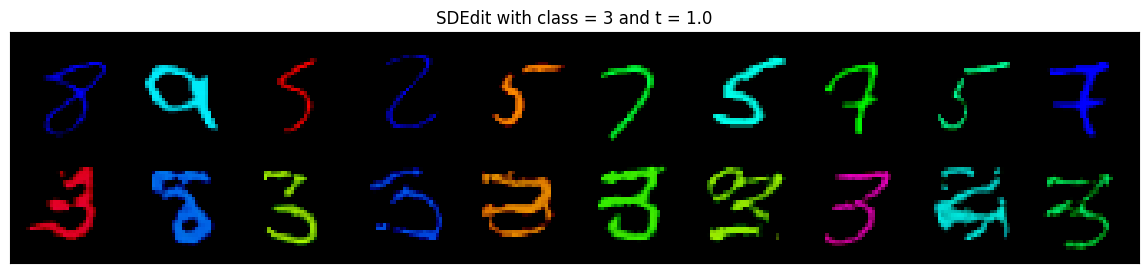

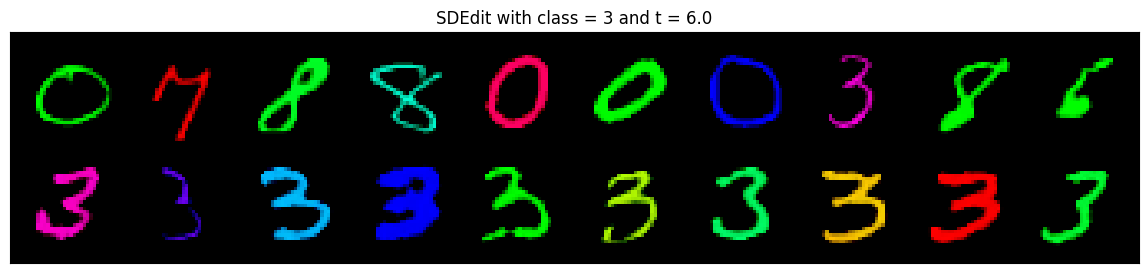

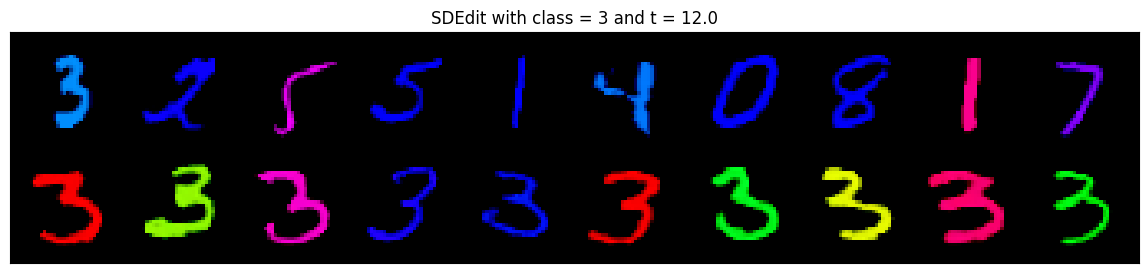

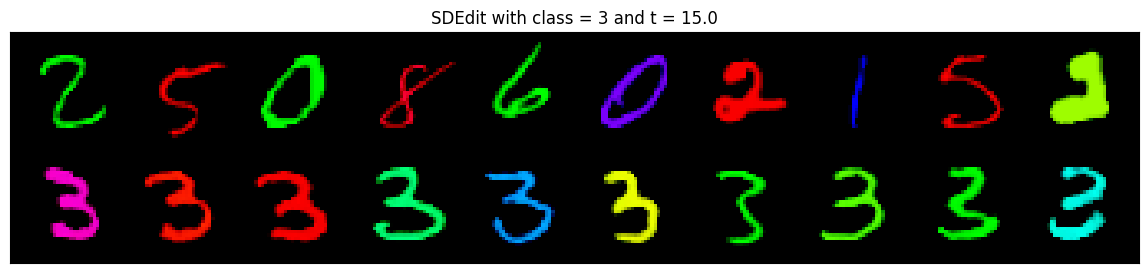

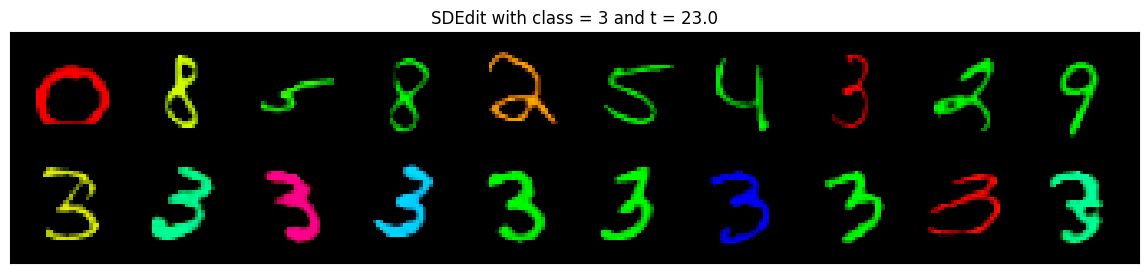

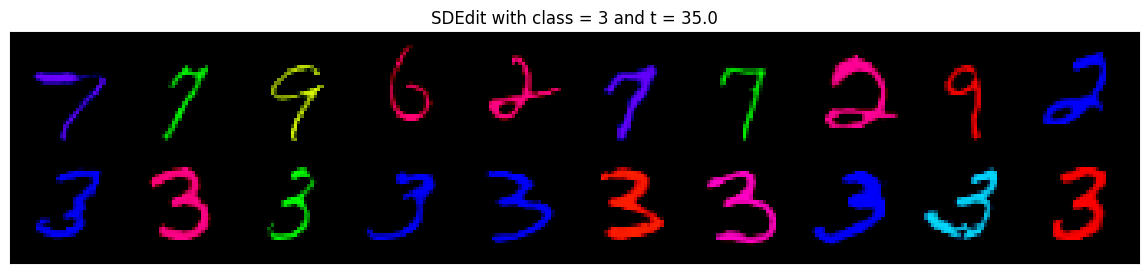

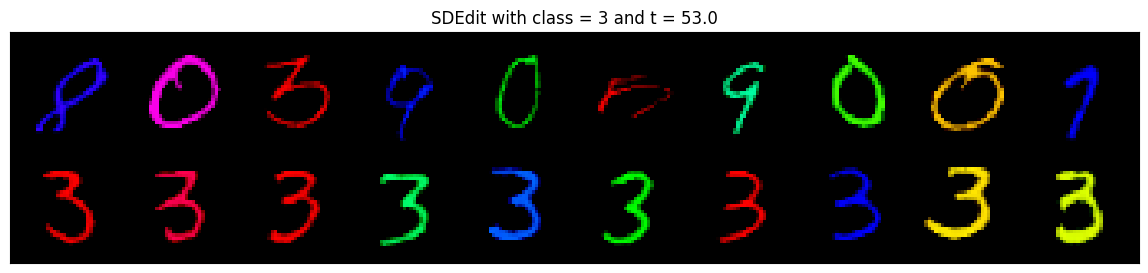

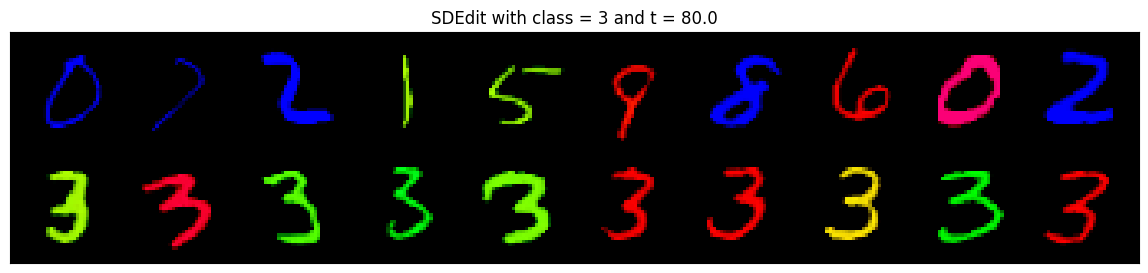

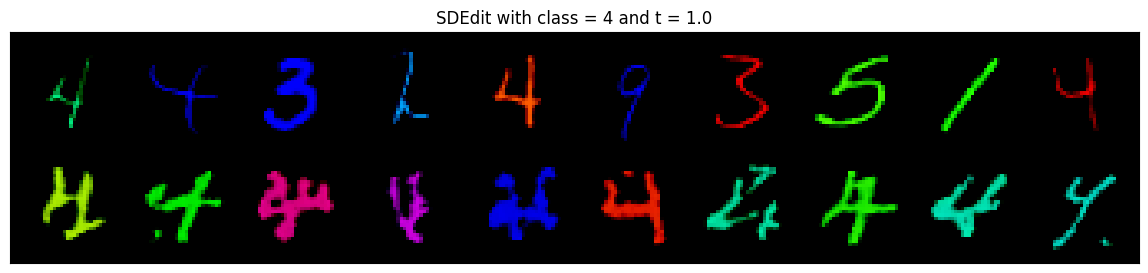

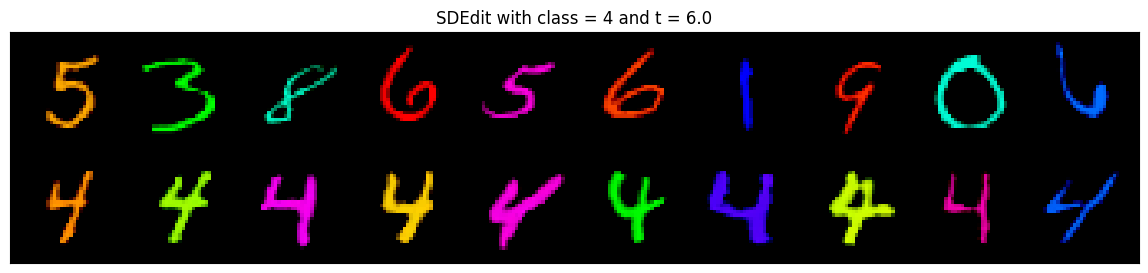

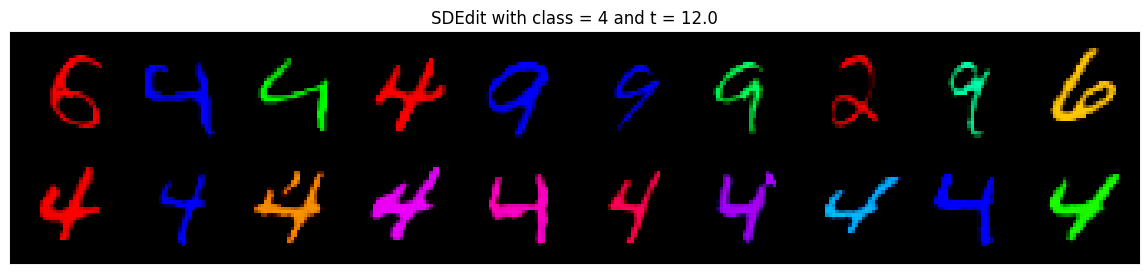

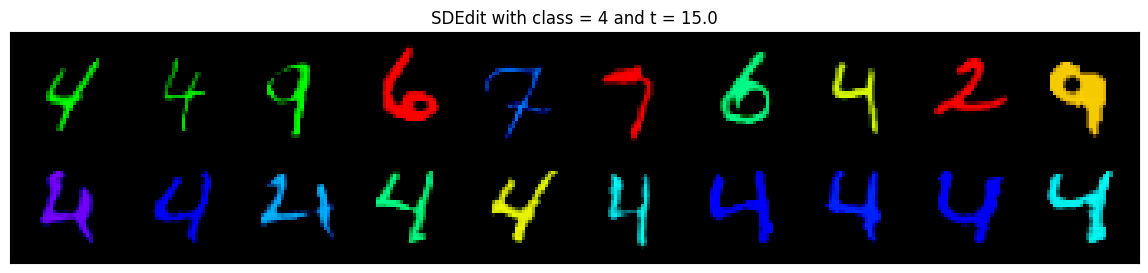

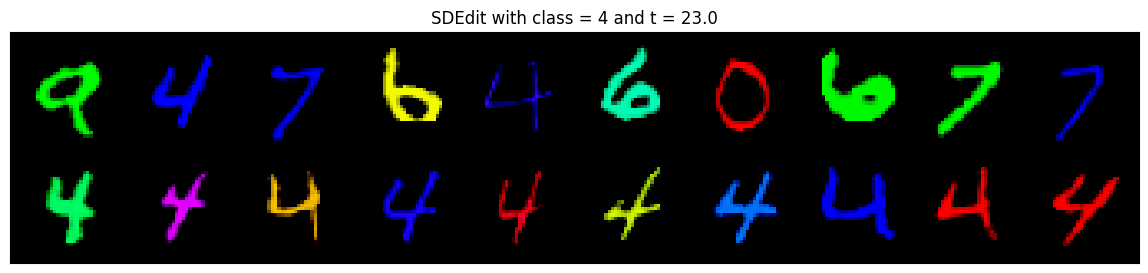

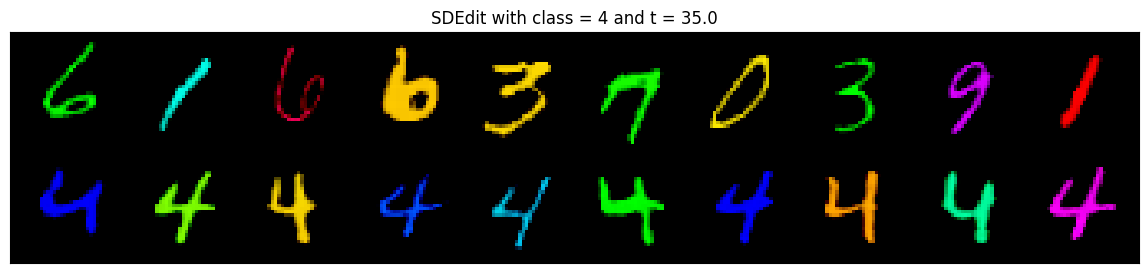

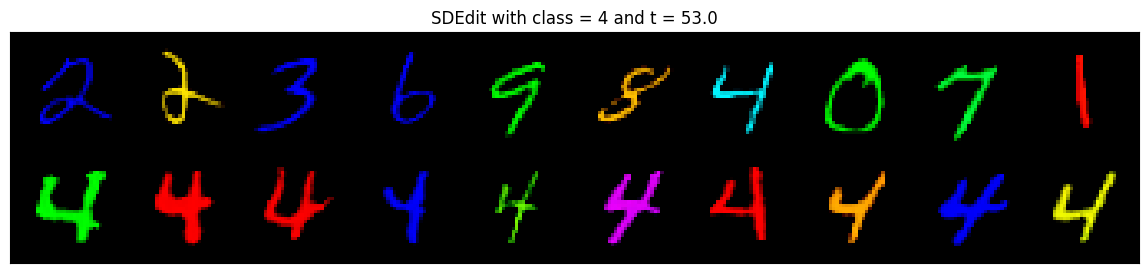

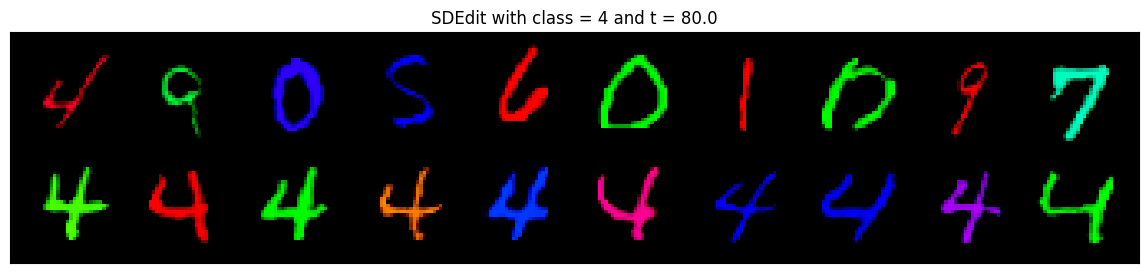

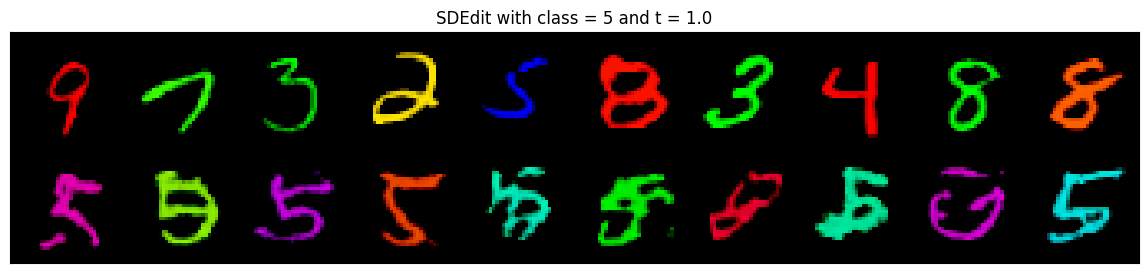

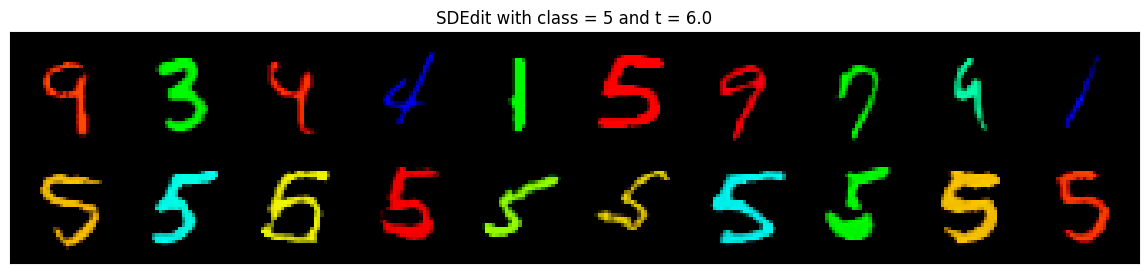

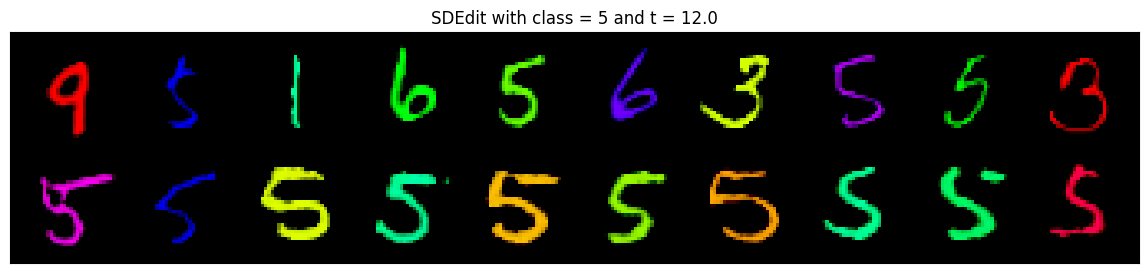

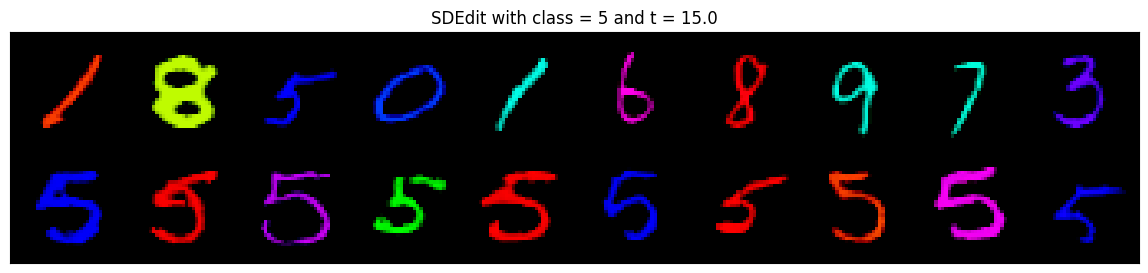

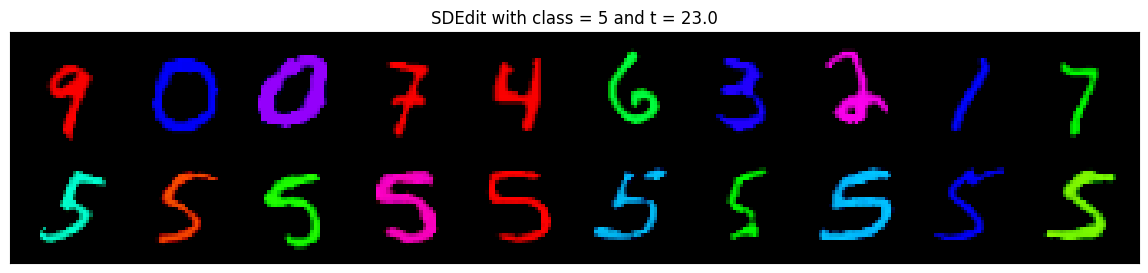

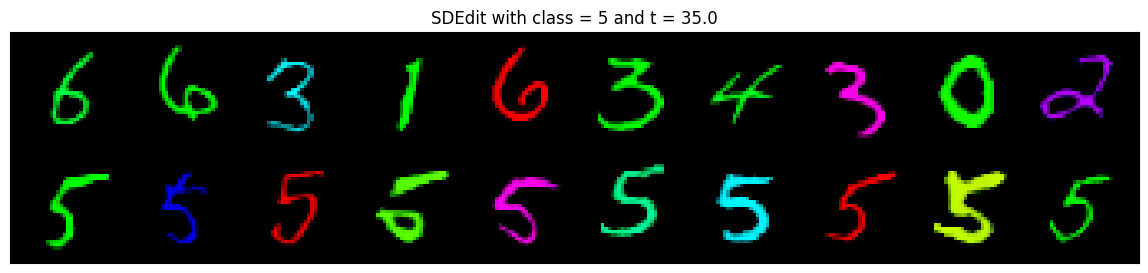

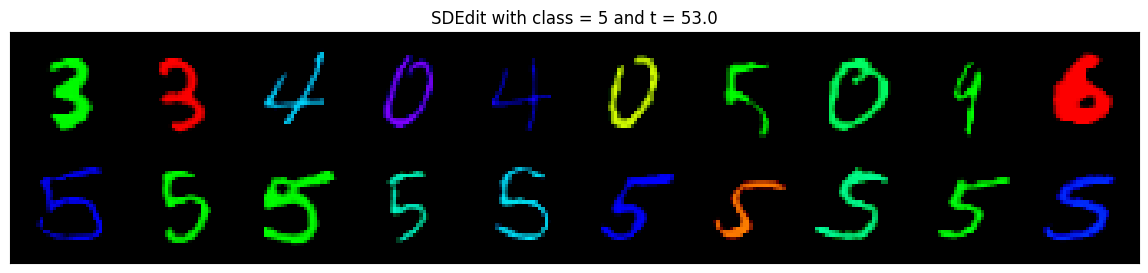

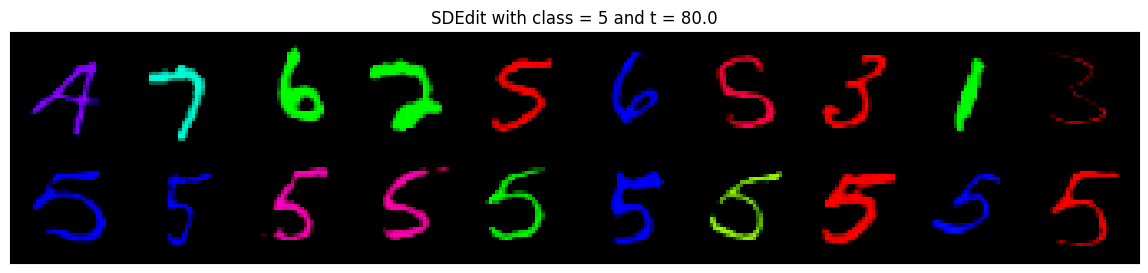

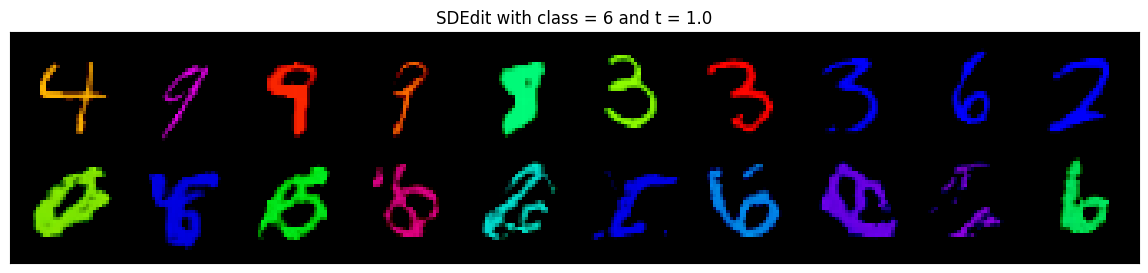

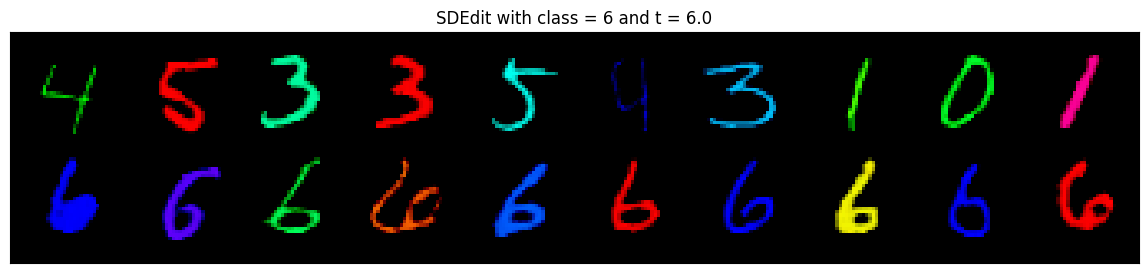

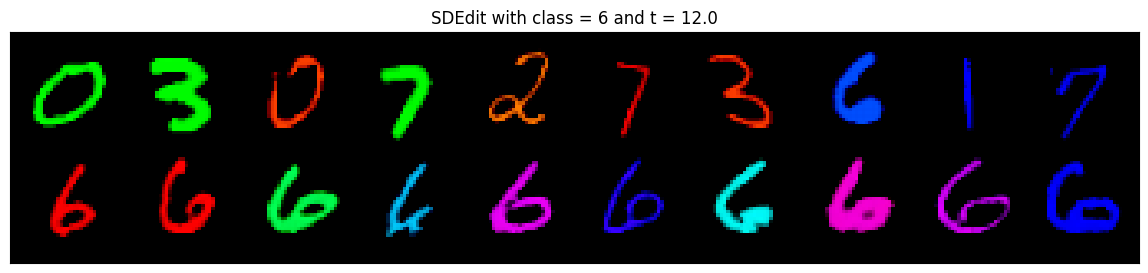

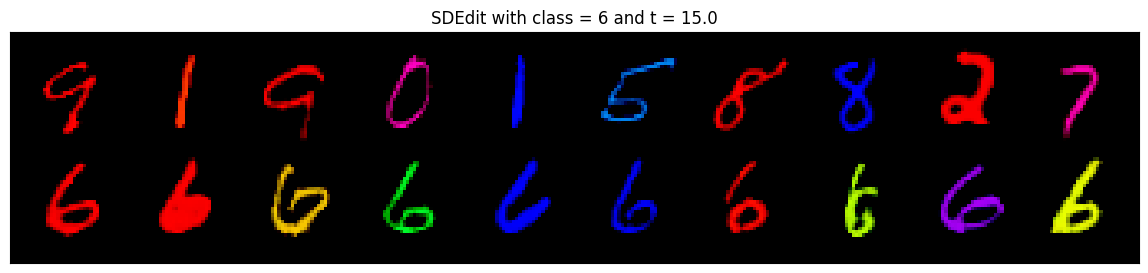

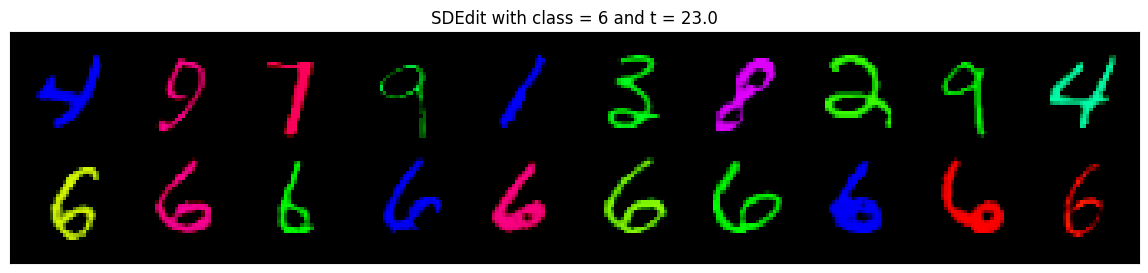

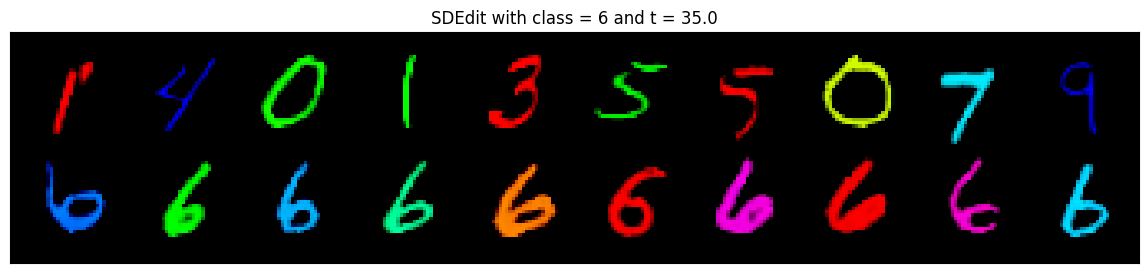

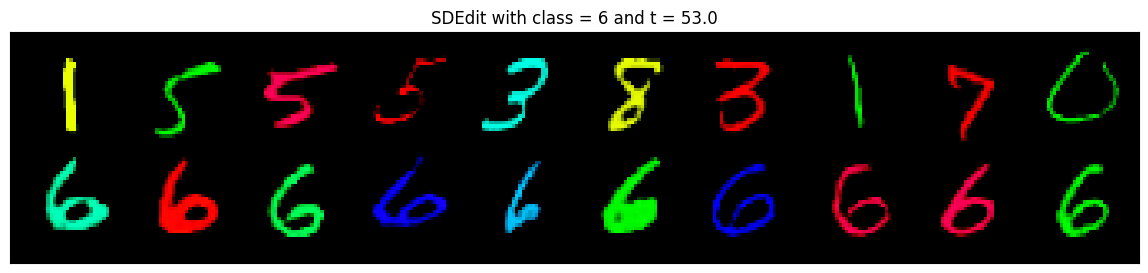

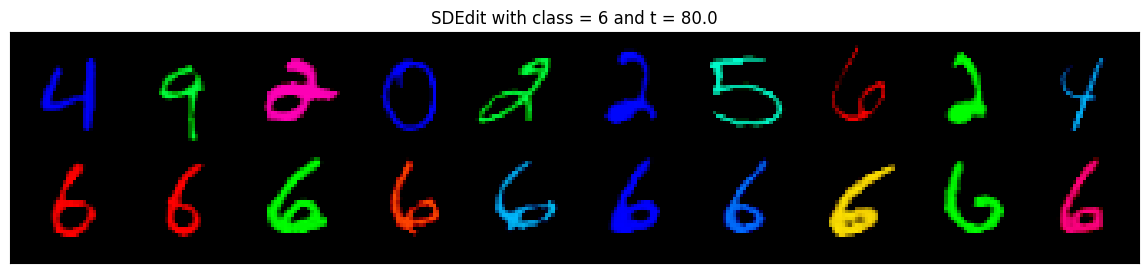

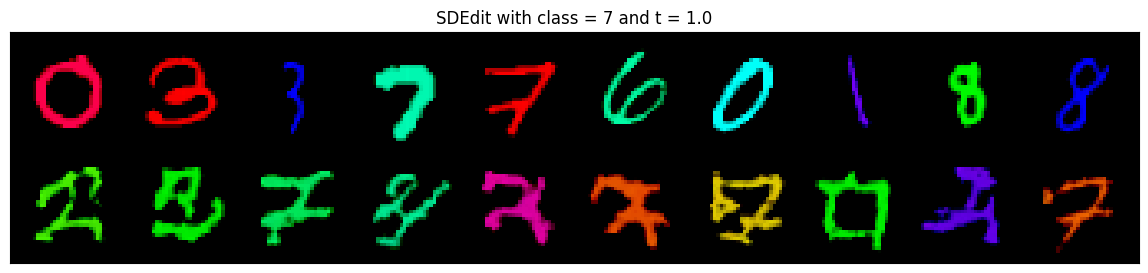

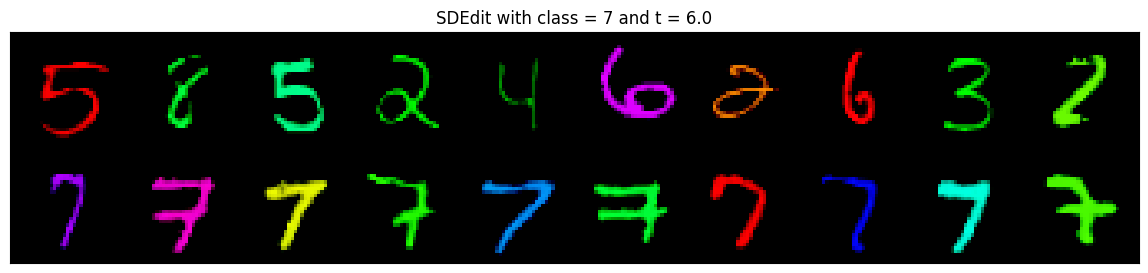

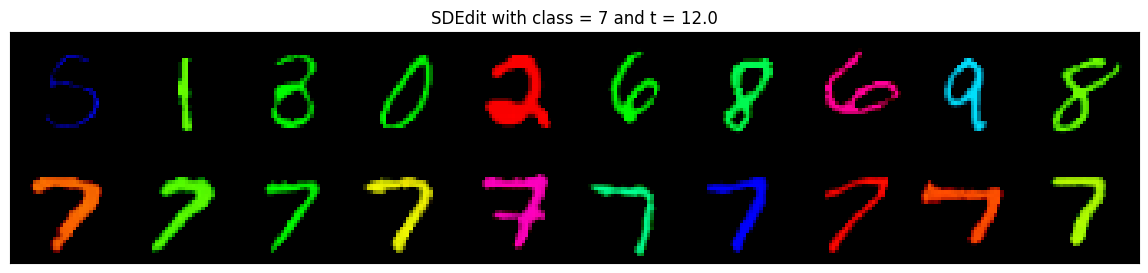

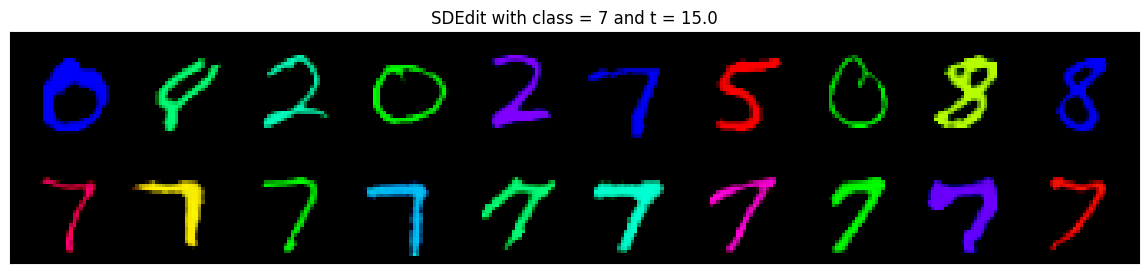

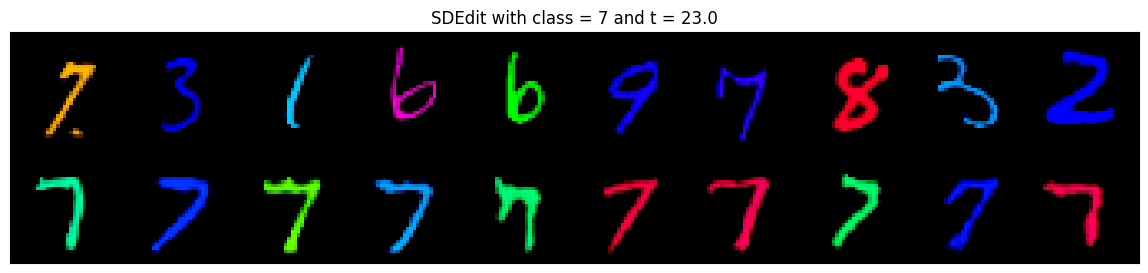

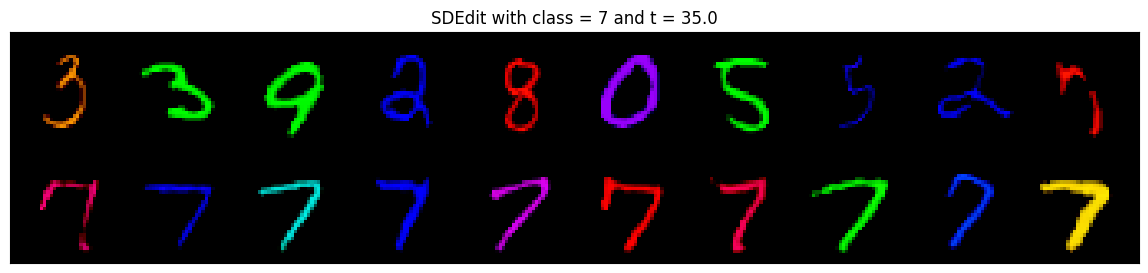

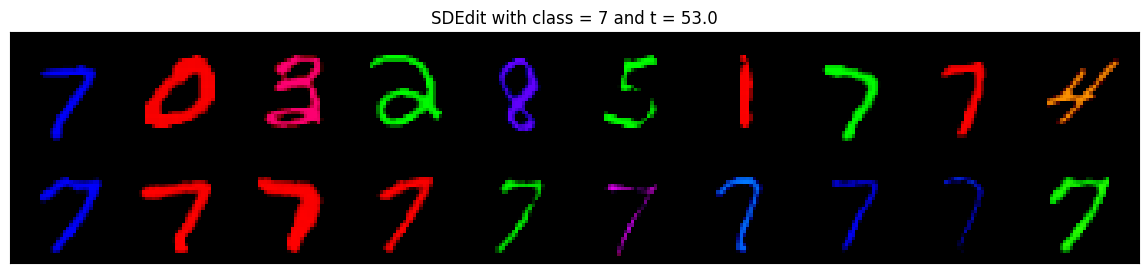

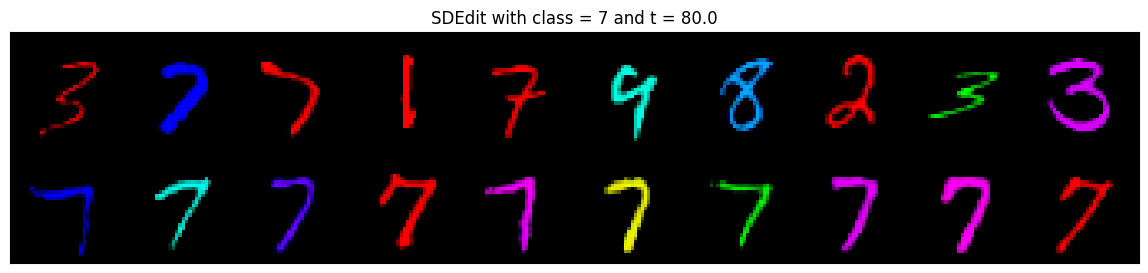

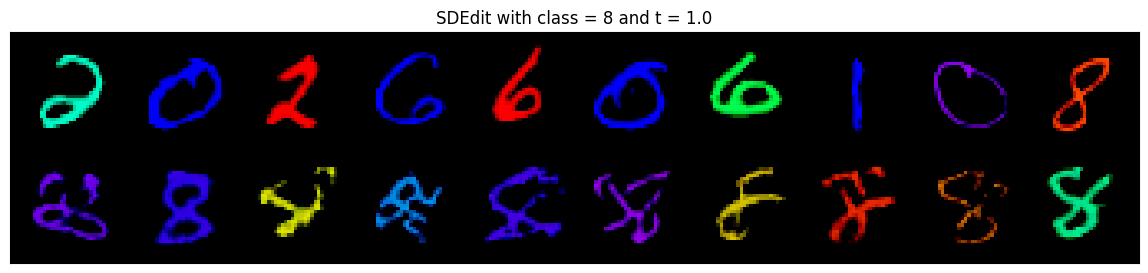

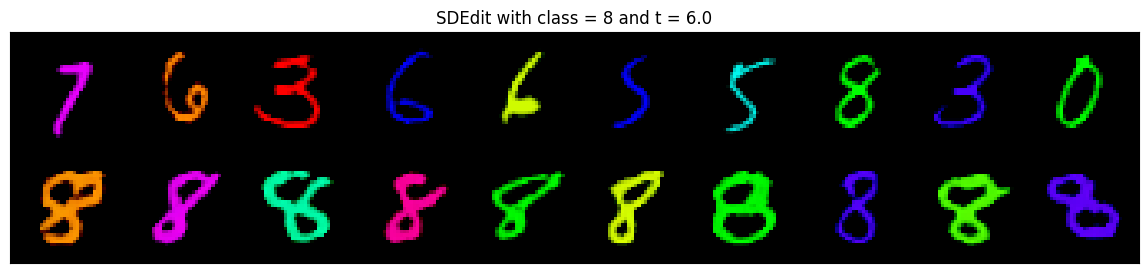

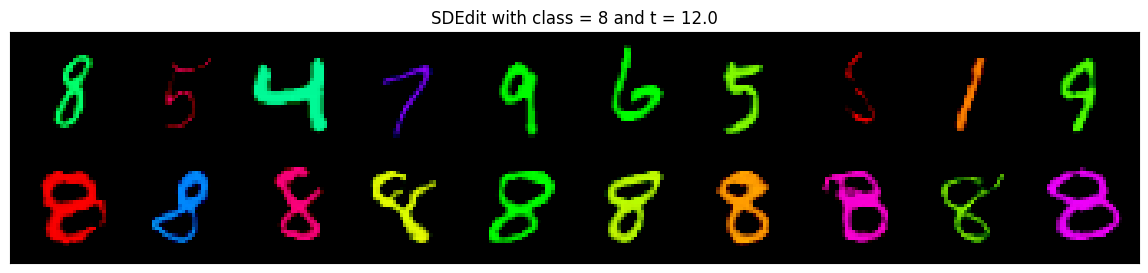

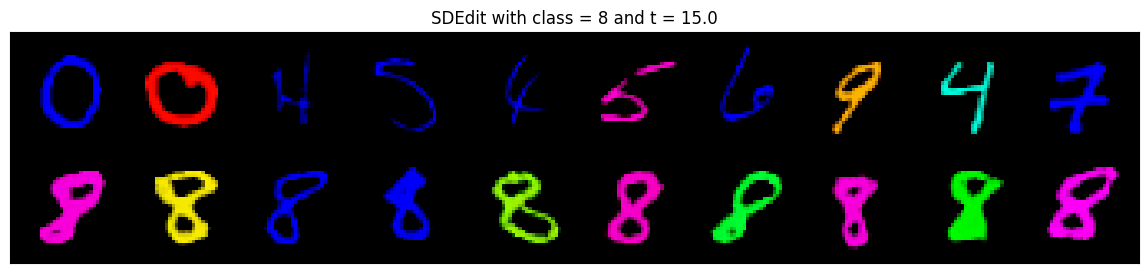

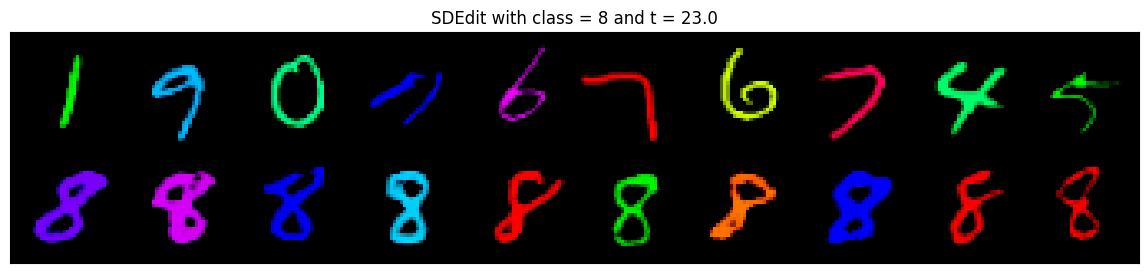

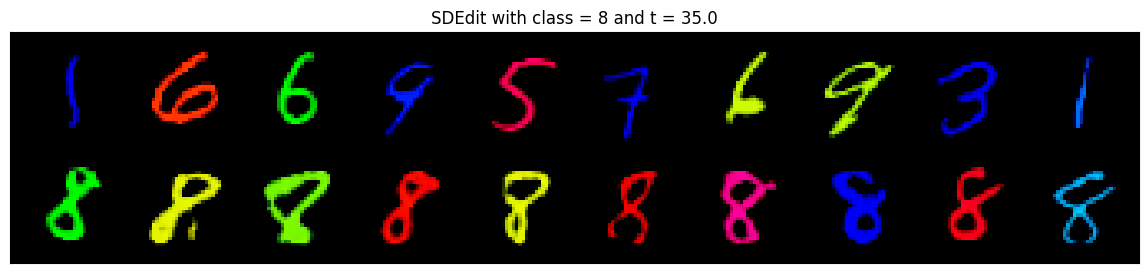

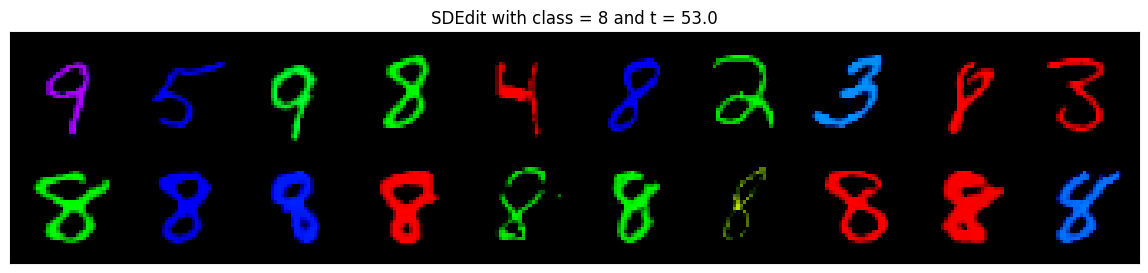

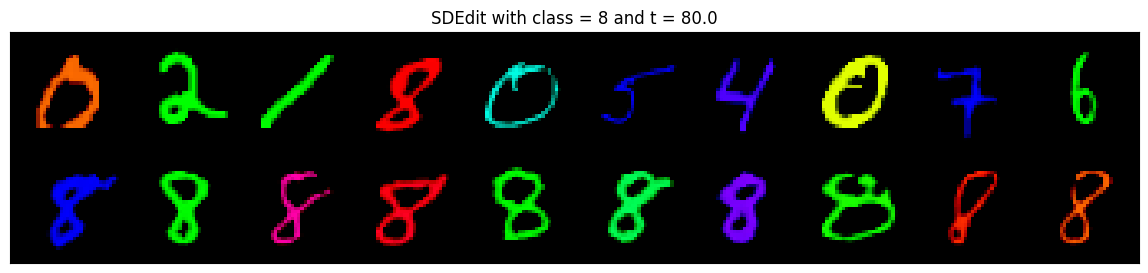

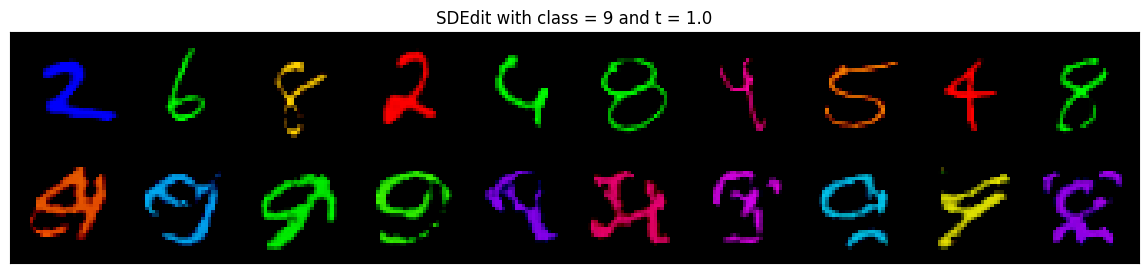

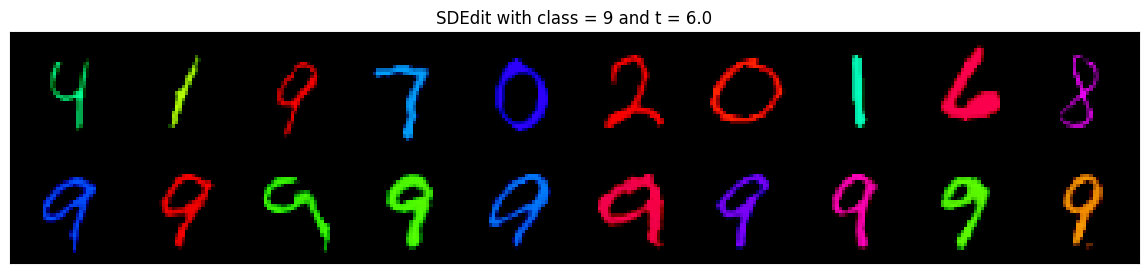

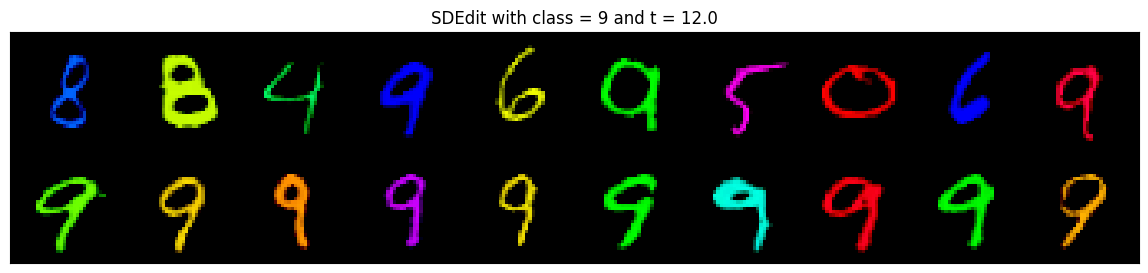

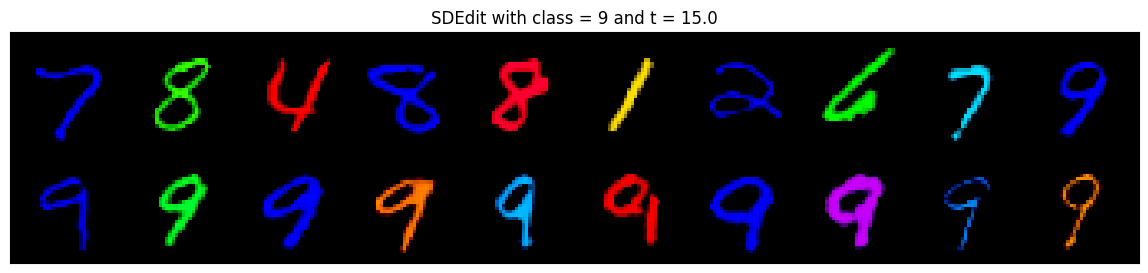

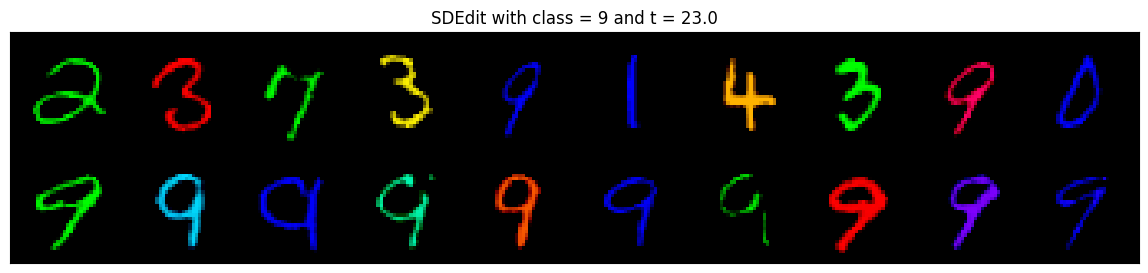

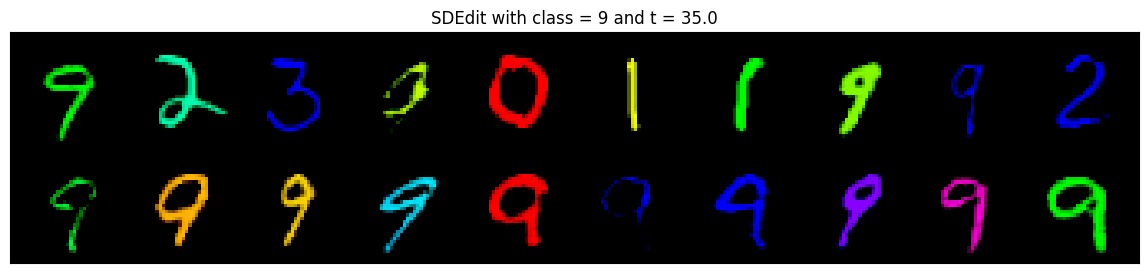

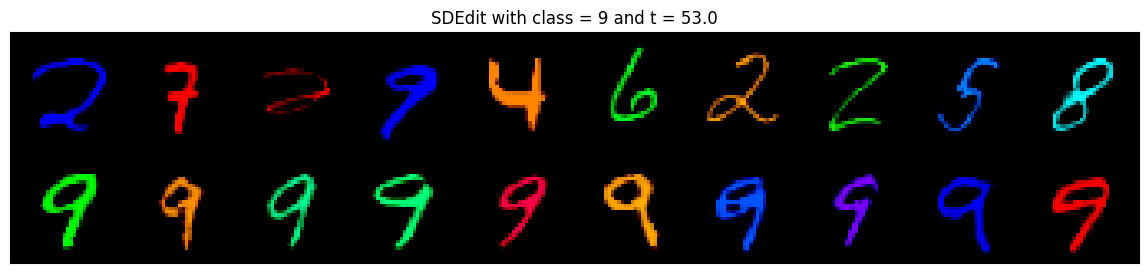

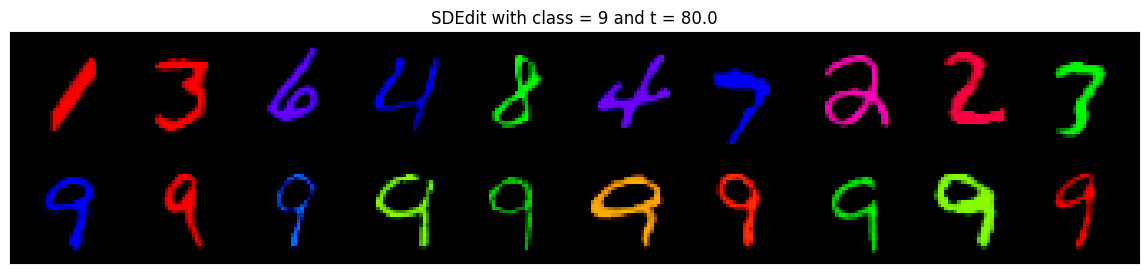

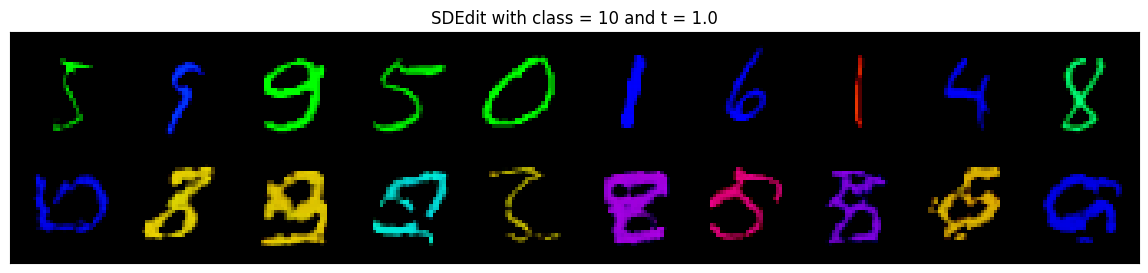

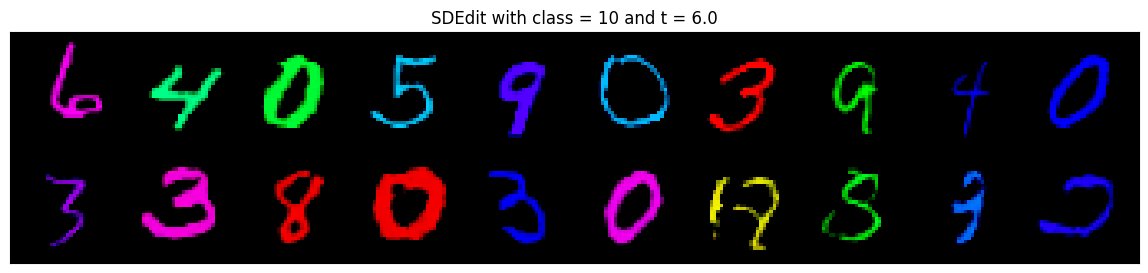

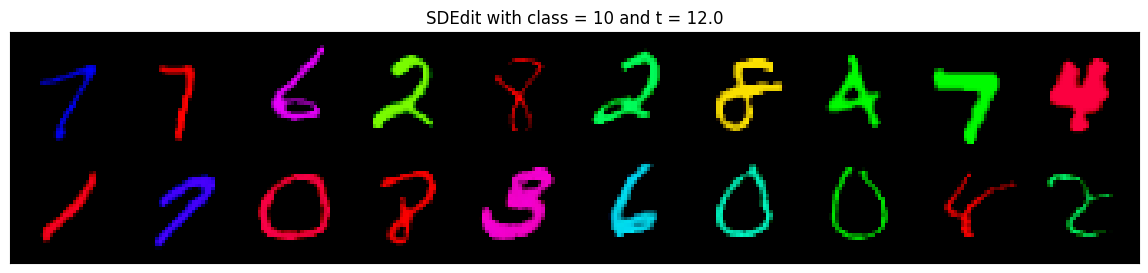

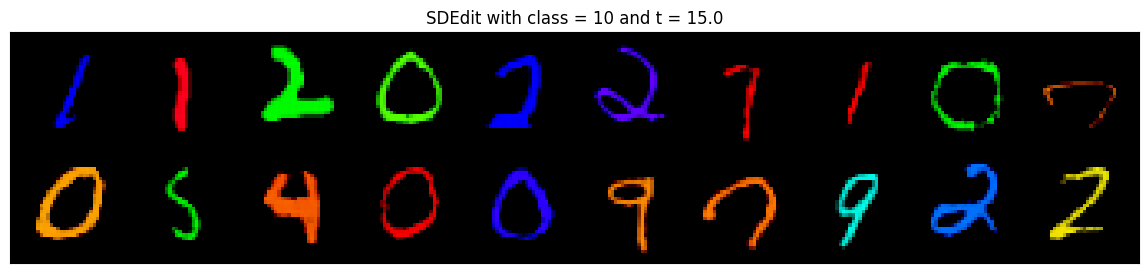

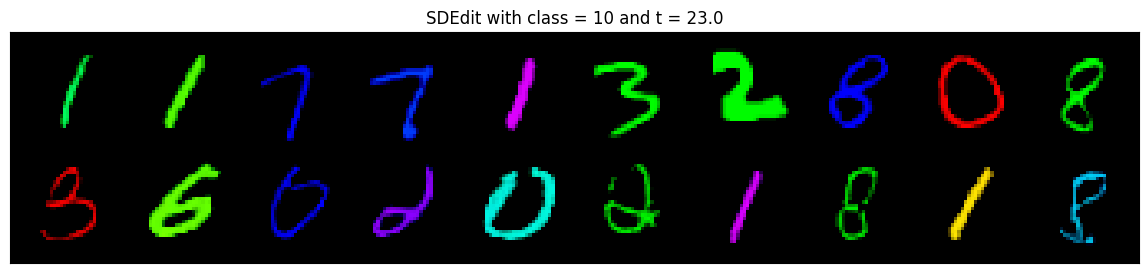

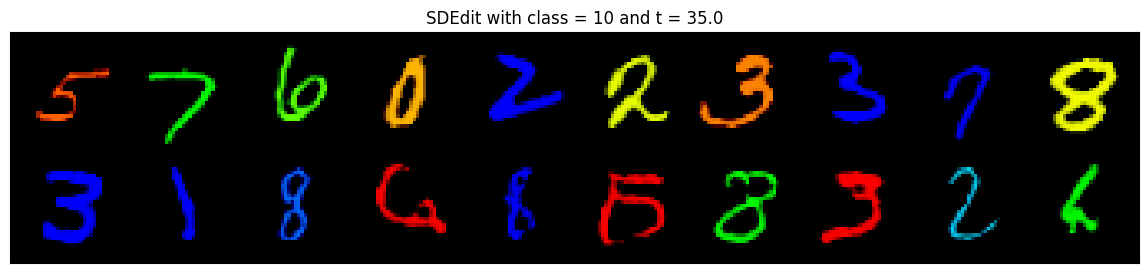

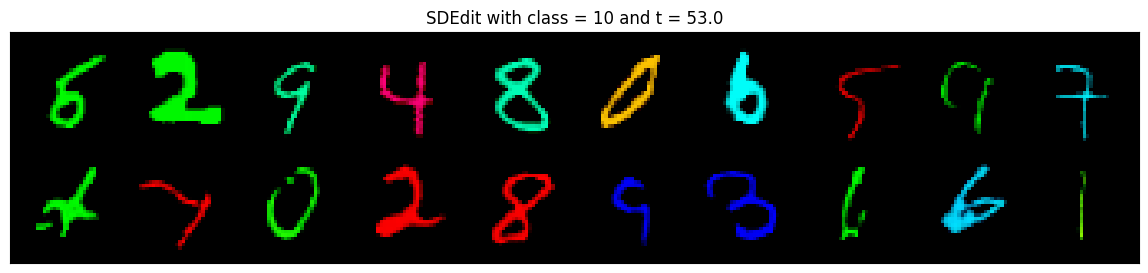

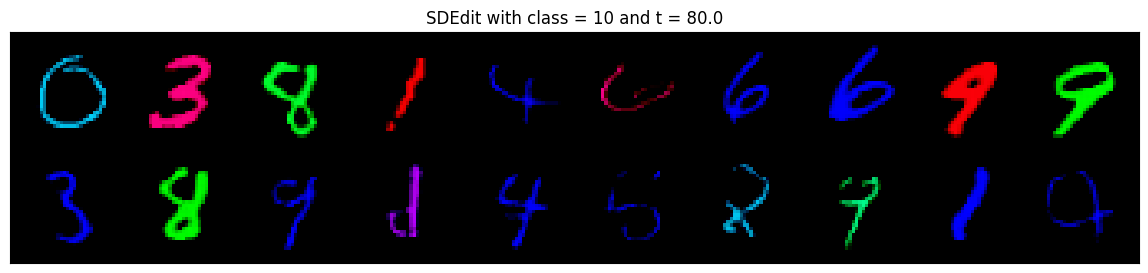

In [ ]:
for number in range(1, 11):
    for t in t_range:
        sampling_params = {
            'device': 'cuda',
            'sigma_min': 0.02,
            'sigma_max': t,
            'num_steps': 50,
            'rho': 7.0,
            'vis_steps': 1,
            'stochastic': False,
            'cfg': 1.0
        }

        x_source = (next(iter(train_dataloader))[0] * 2 - 1).cuda()[:10]
        x_out = sdedit(cond_model, x_source, target_label=number, params=sampling_params)
        visualize_transform(x_source, x_out, title = f'SDEdit with class = {number} and t = {t}')

Сразу замечу, что малое количество шума (где-то 1-5) плохо влияет на генерацию, так как не из чего генерировать, фотография почти бесшумная, результаты кляксы.

Далее замечу, что цвет цвет везде рандомный и как будто не сохраняется, а если и сохраняется, то плохо. Далее также буду рассуждать про - наклон, форму, всякие завитушки.

Начну рассуждать сначала с класса = 1. При t = 6, 12, результаты не очень, наклон мало где сохранился, формы разные. При t = 15, 23, 35 ситуация лучше, гораздо лучше фидно, что наклон гораздо лучше переносится, также лучше передается форм, но в целом все равно наблюдается не соответствия - тонкая форма оригинала и жирная 1. А вот где-то между 53 и 80 начинает сохраняться форма и остается наклон.

Для остальных цифр такая ситуация с формой и наклоном, но завиштушки до сих пор плохо передаются до 35, с 53 начинают передаваться завитушки. Далее более подробно рассмотрю этот интервал.

In [ ]:
t_range = np.linspace(50, 80, 4)


In [ ]:
t_range

array([50., 60., 70., 80.])

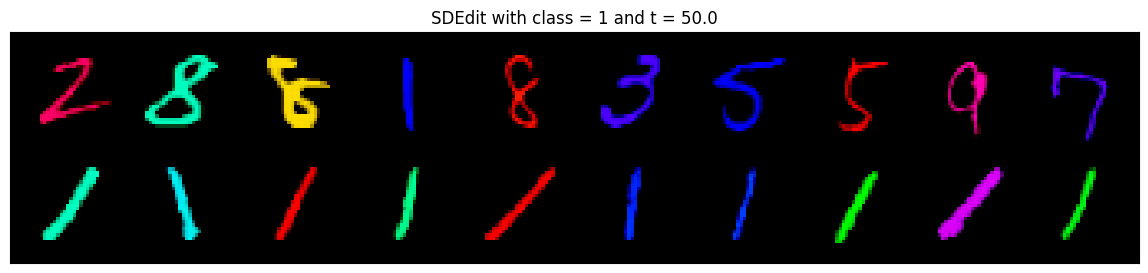

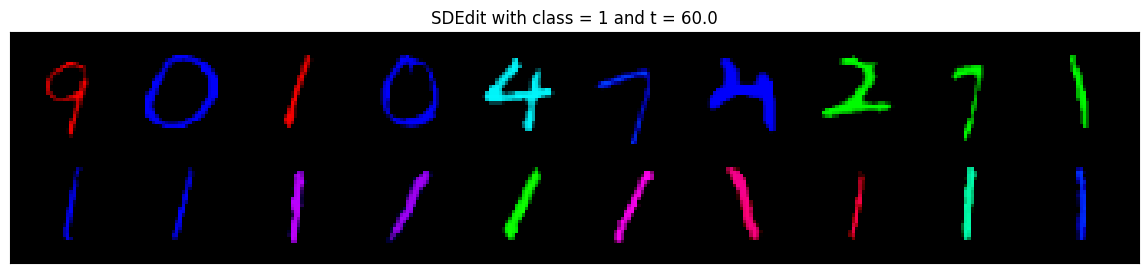

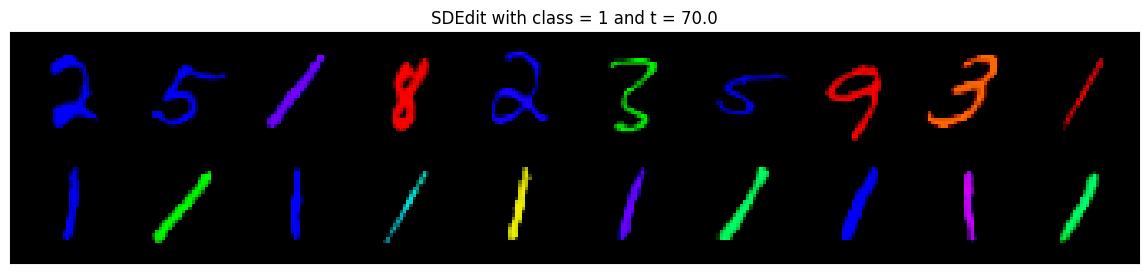

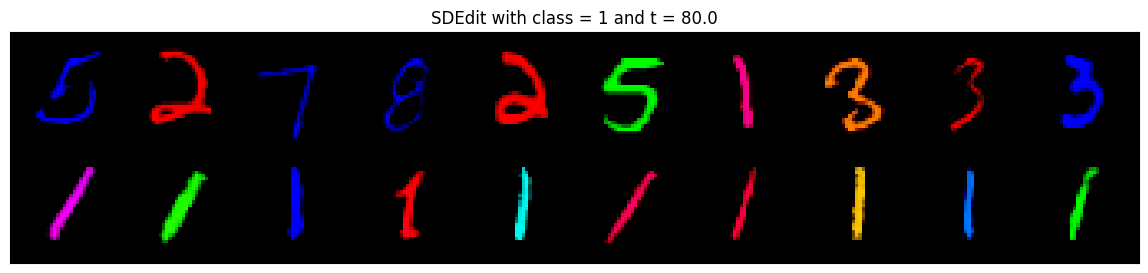

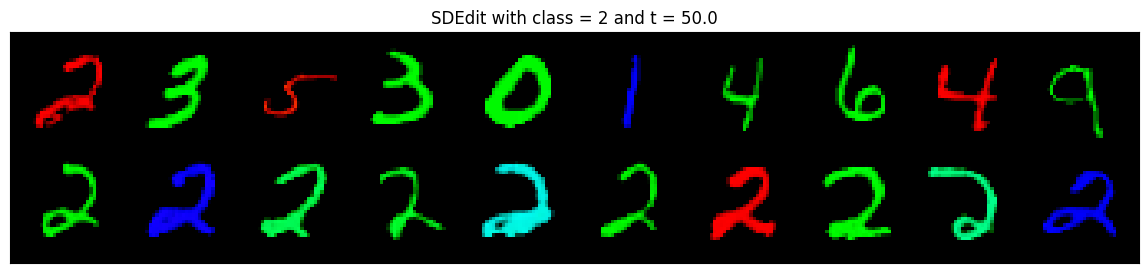

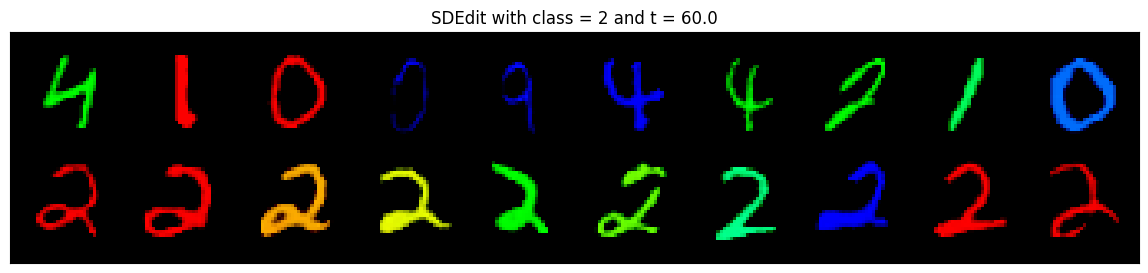

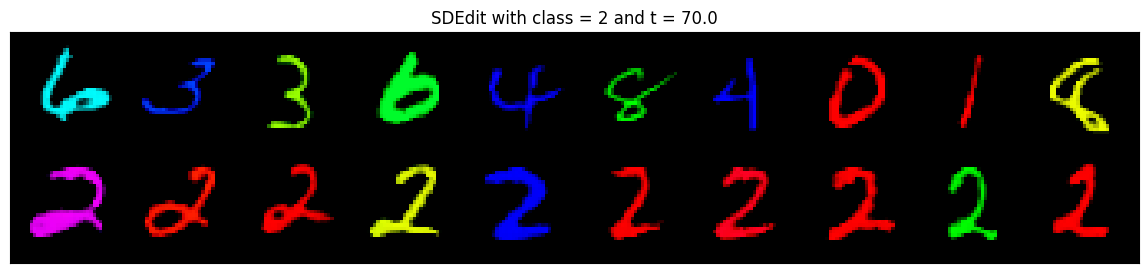

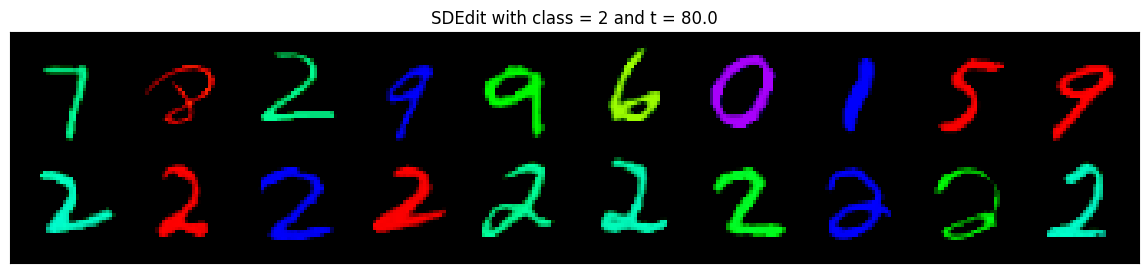

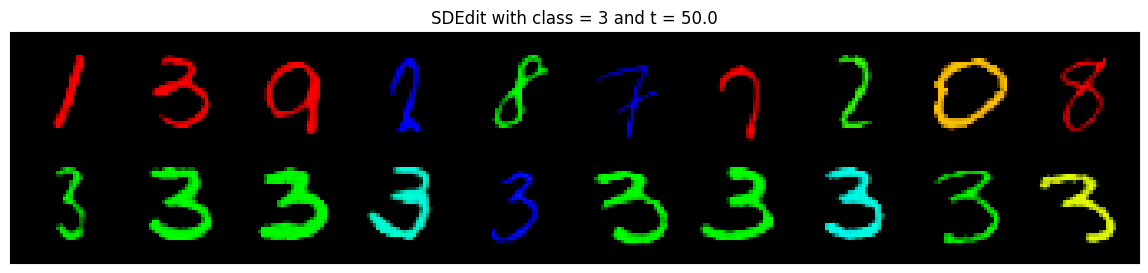

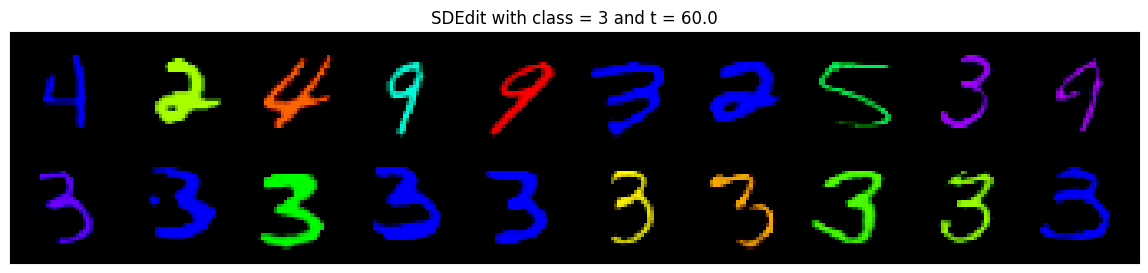

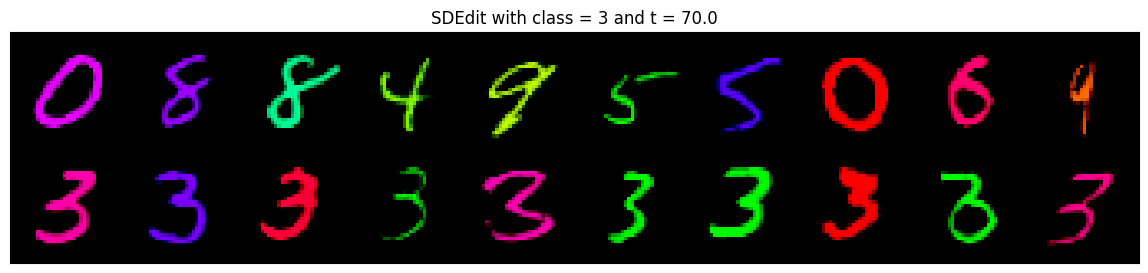

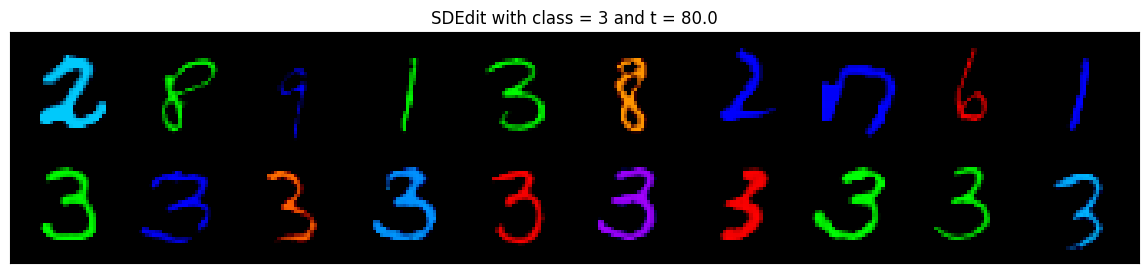

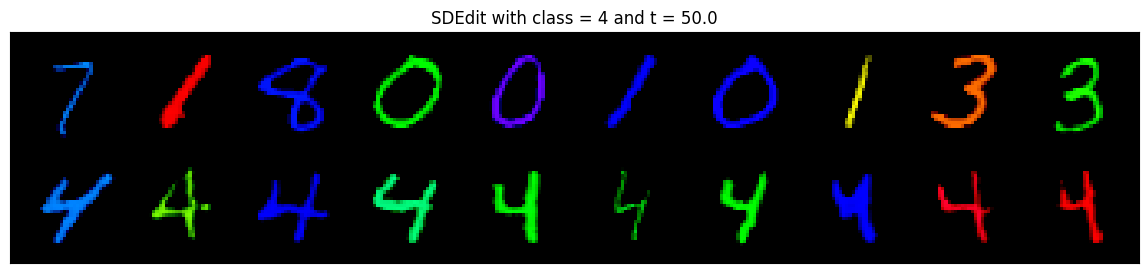

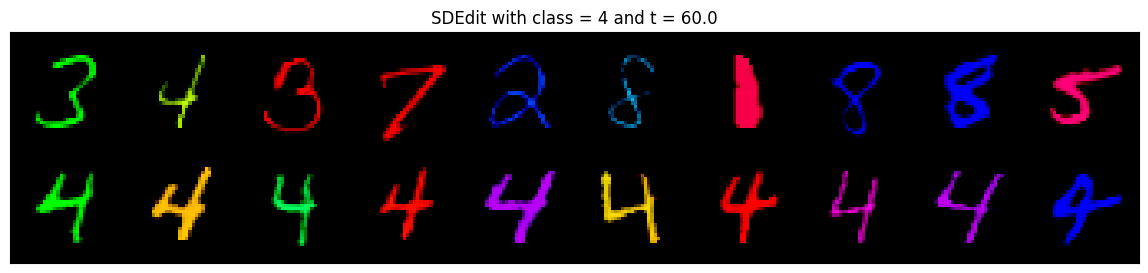

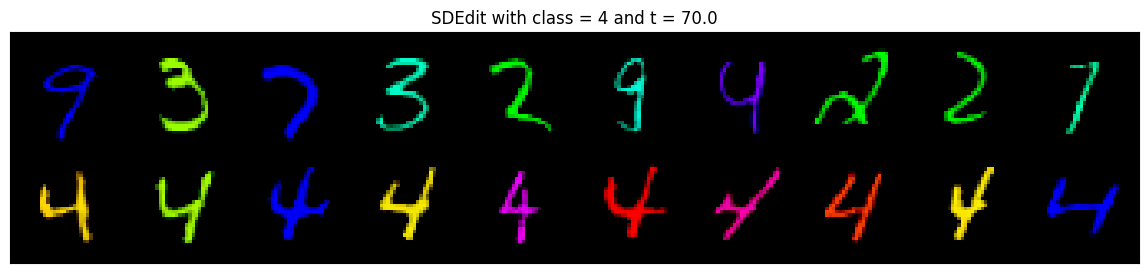

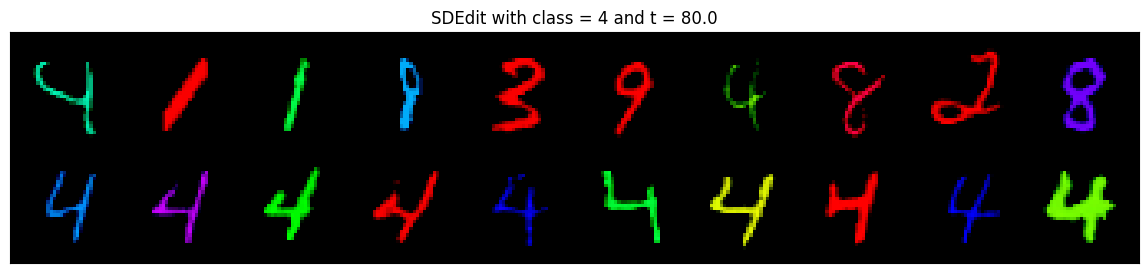

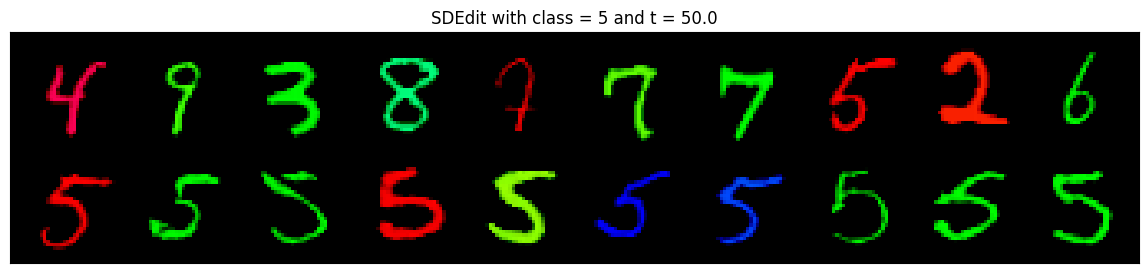

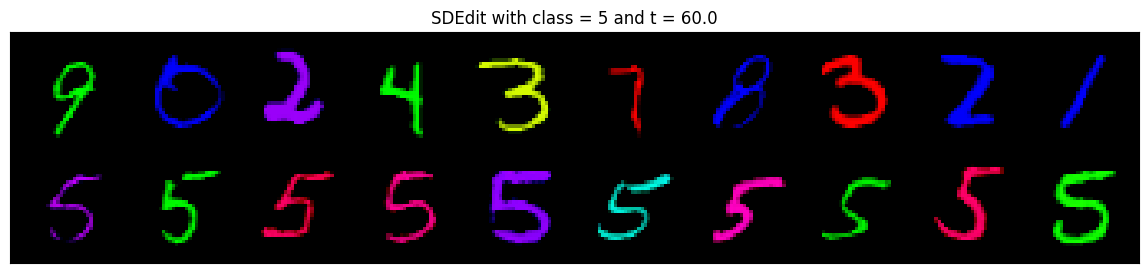

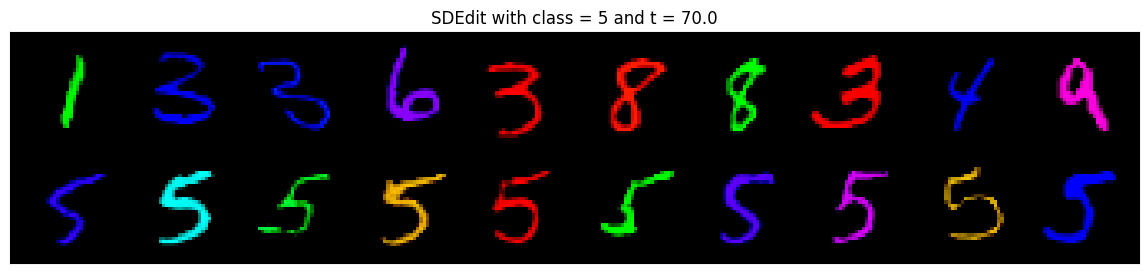

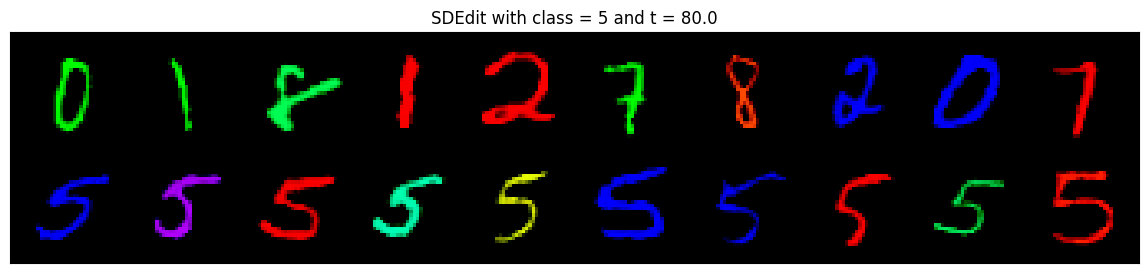

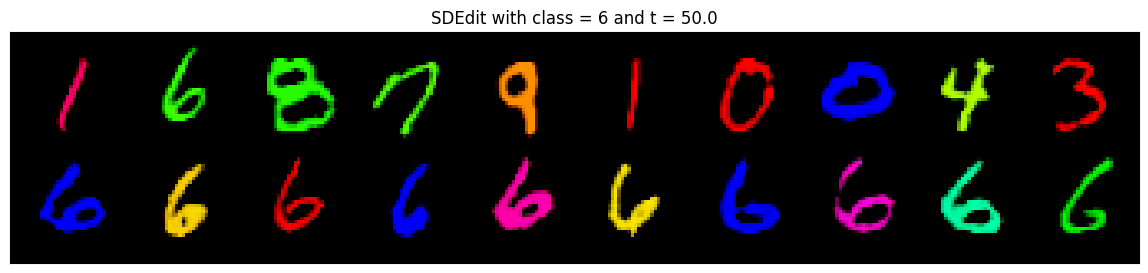

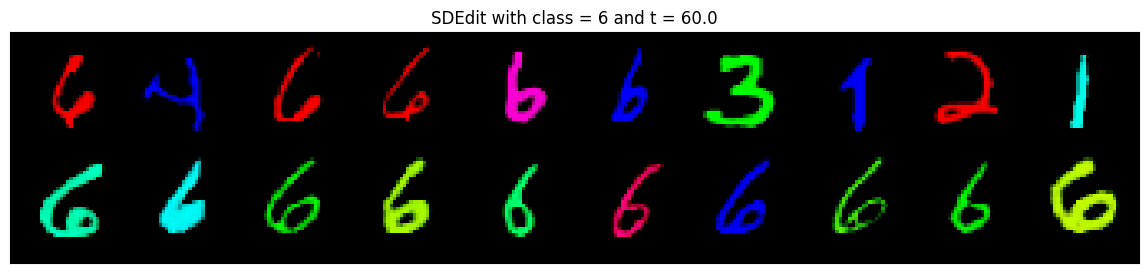

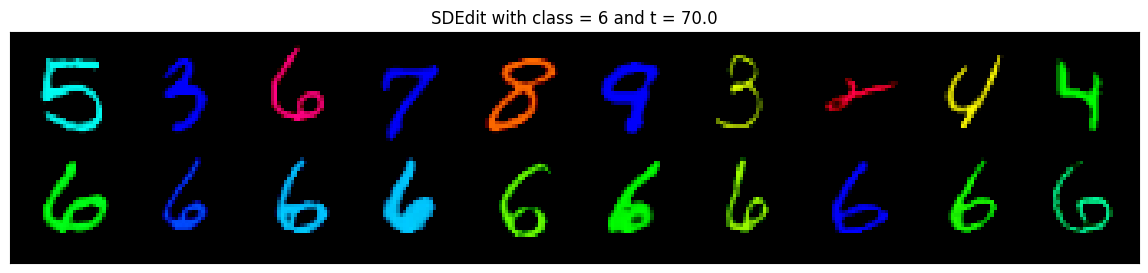

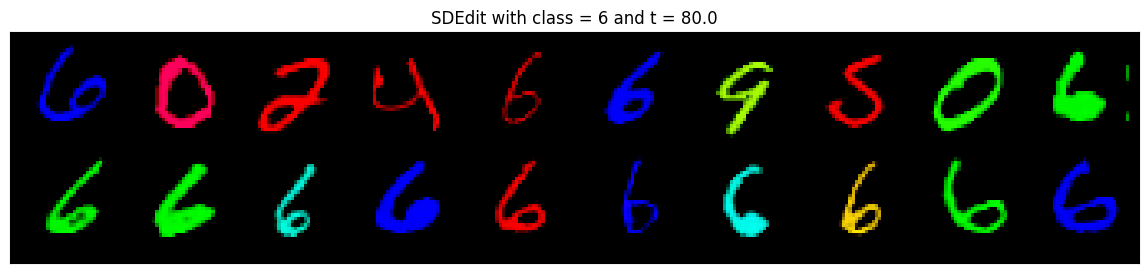

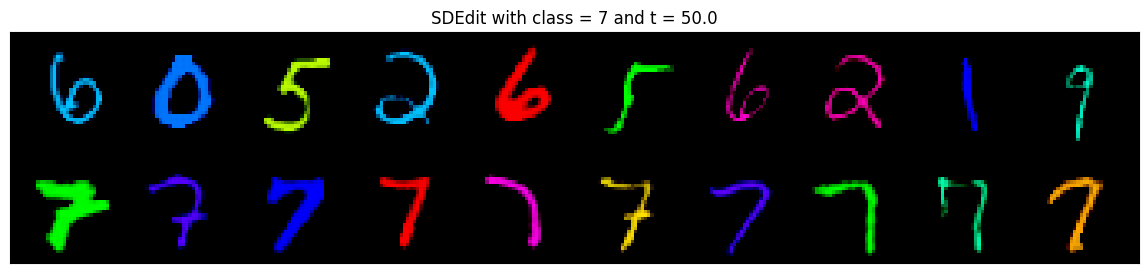

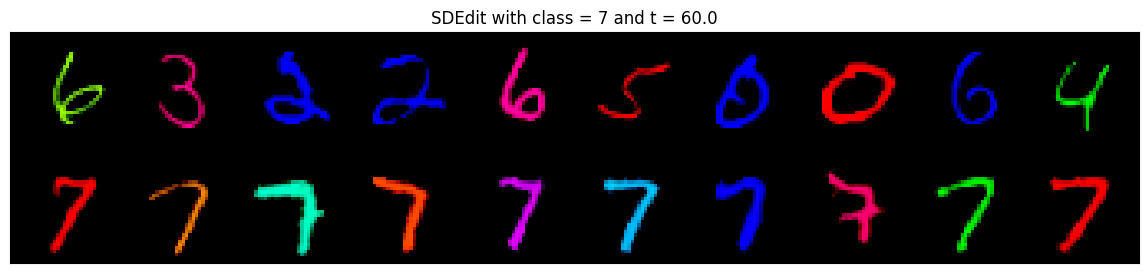

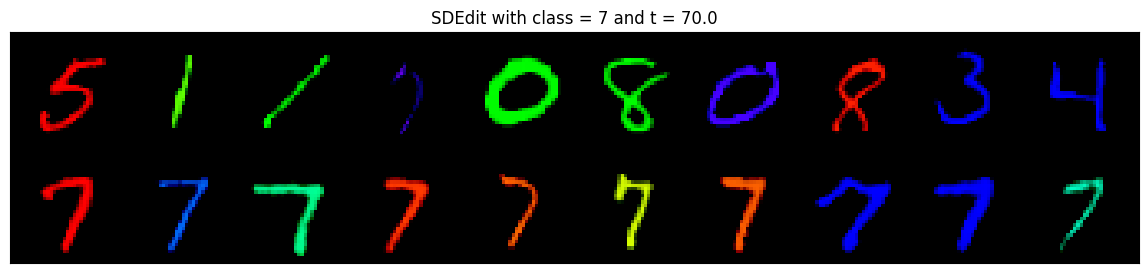

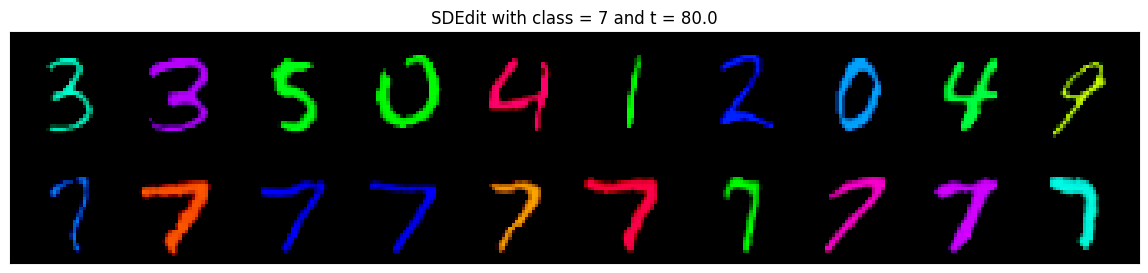

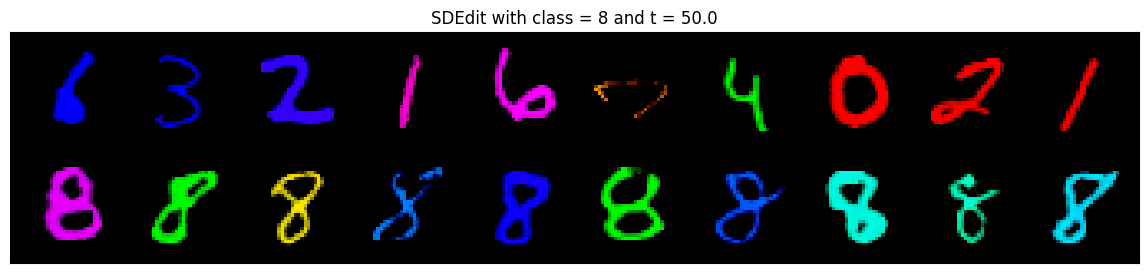

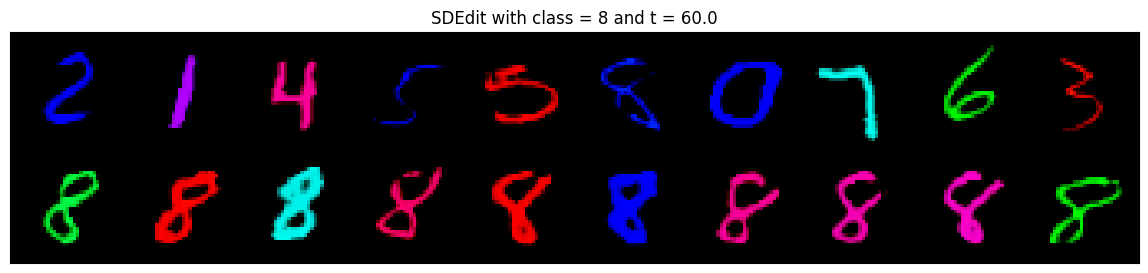

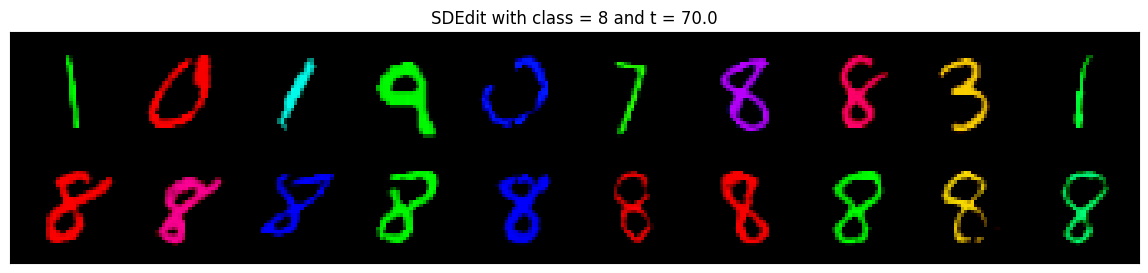

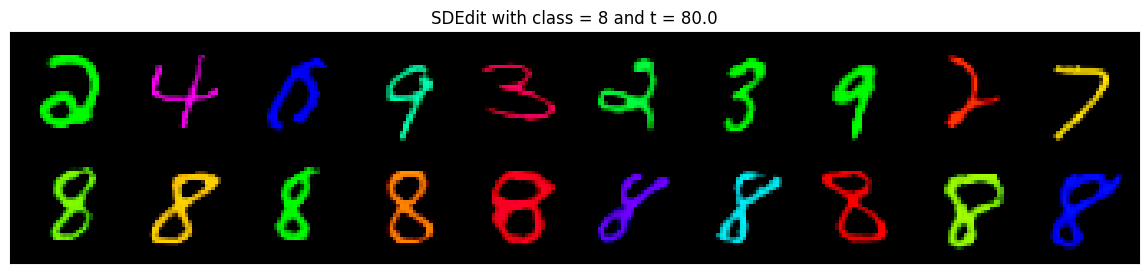

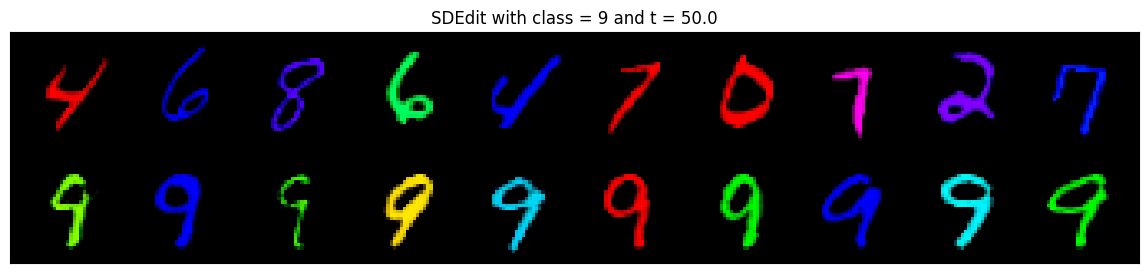

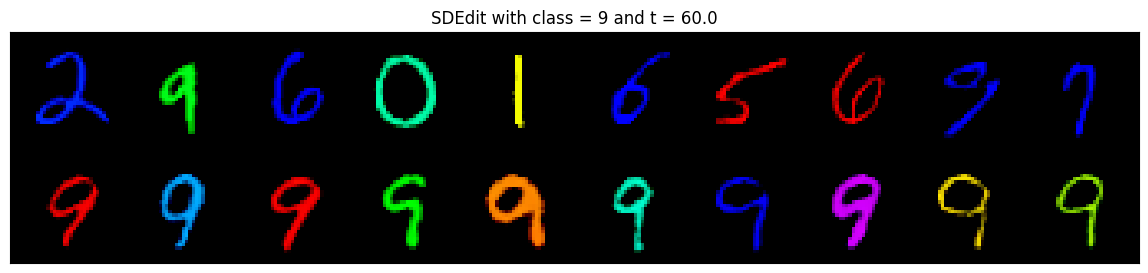

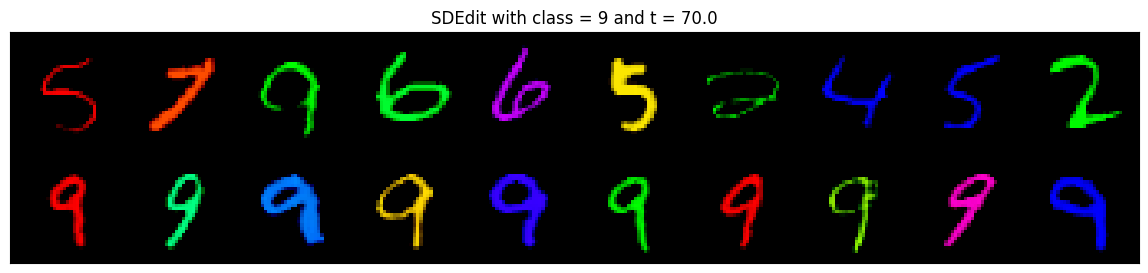

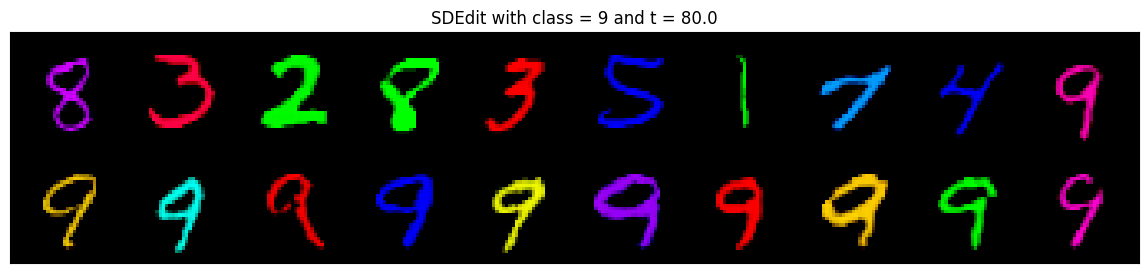

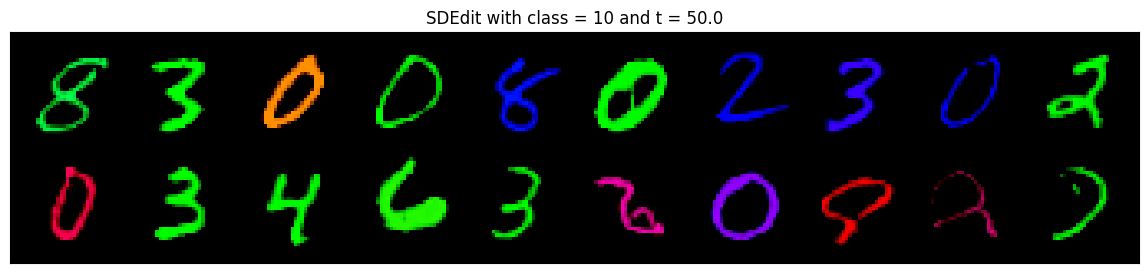

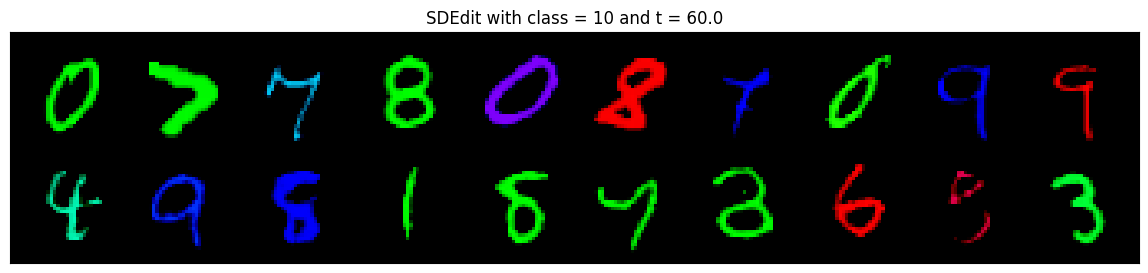

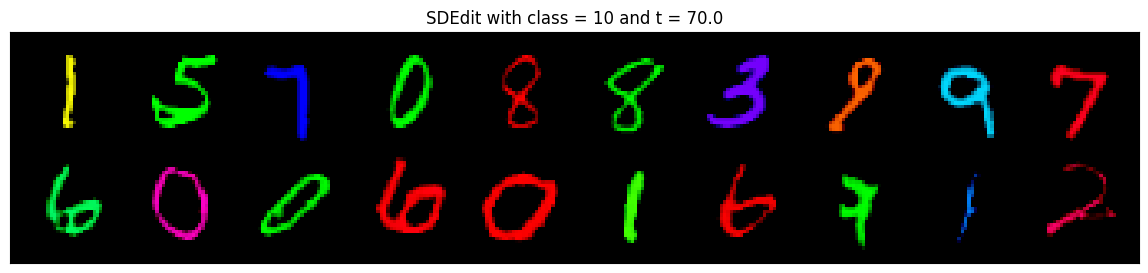

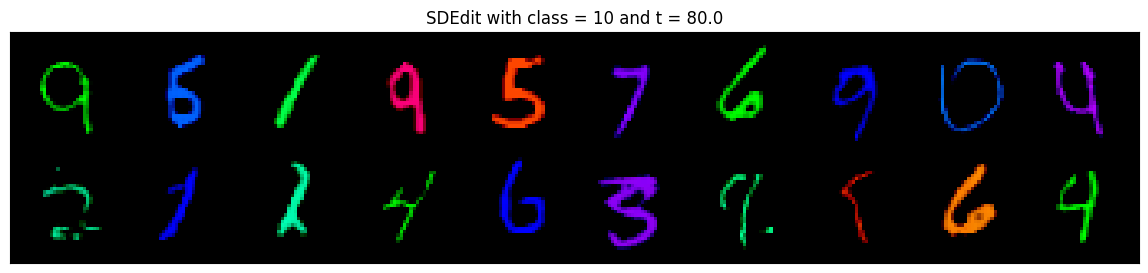

In [ ]:
for number in range(1, 11):
    for t in t_range:
        sampling_params = {
            'device': 'cuda',
            'sigma_min': 0.02,
            'sigma_max': t,
            'num_steps': 50,
            'rho': 7.0,
            'vis_steps': 1,
            'stochastic': False,
            'cfg': 1.0
        }

        x_source = (next(iter(train_dataloader))[0] * 2 - 1).cuda()[:10]
        x_out = sdedit(cond_model, x_source, target_label=number, params=sampling_params)
        visualize_transform(x_source, x_out, title = f'SDEdit with class = {number} and t = {t}')

На глаз, самый лучший выбор где-то между 60 и 70. Особенно это заметно при классе = 3 и t = 70. Хотя не для всех цифр результат хороший, где-то при 50-60 лучше чем при 70 (например при 9, 7). При t = 80 уже теряется информация и хуже передается оттенок, а при t = 50 завитушки плохо передаются.

В общем, если выбирать одно число, то дефолт будет t = 60, если выбирать диапазон, то где-то между 50 и 70.

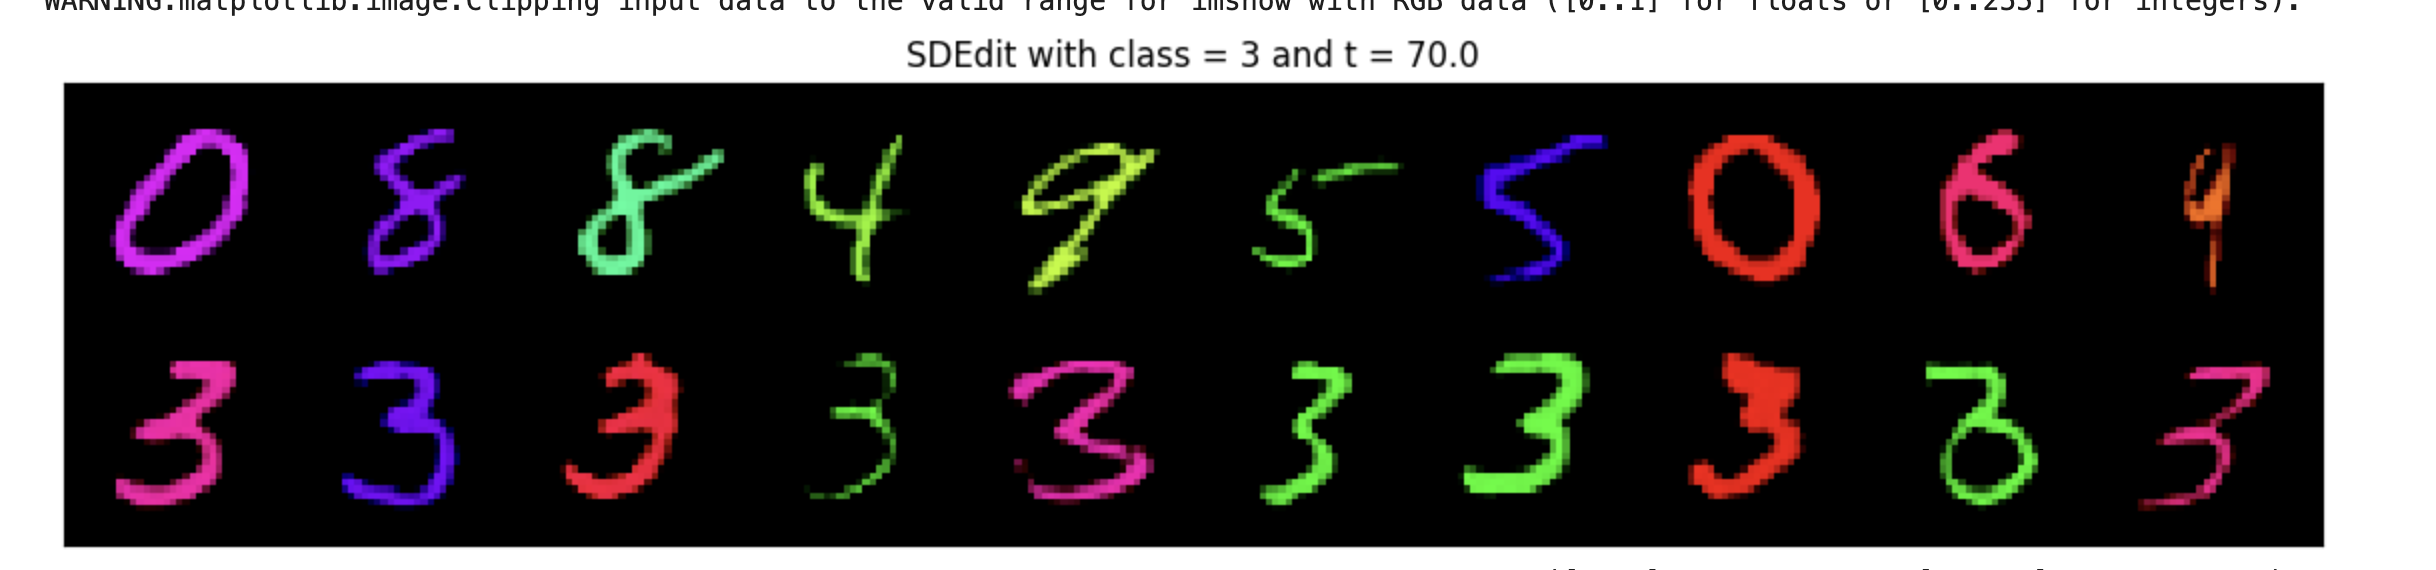

## DDIB (Dual Diffusion Implicit Bridges)

Следующий метод, который мы рассмотрим, называется Dual Diffusion Implicit Bridges [(DDIB)](https://arxiv.org/abs/2203.08382). Он использует ту же идею, что SDEdit (зашумить семпл из исходного домена и расшумить его диффузионной моделью для целевого домена), но делает это более умно. Принципиальная проблема SDEdit состоит в том, что стохастическое зашумление всегда сопровождается потерей данных об исходном изображении (если $t$ слишком большое, то можно считать, что информации вообще никакой не остается). Если бы был способ детерминированного зашумления данных, это бы решило проблему, так как позволило бы превратить вход во что-то, что может принять на вход диффузионная модель для таргетного домена.

А такой способ у нас есть! Подойдет представление диффузионных моделей через обыкновенные дифференциальные уравнения: прямой процесс зашумления
$$
    \mathrm{d} \mathbf{X}_t = g(t) \mathrm{d} \mathbf{W}_t
$$
эквивалентен ОДУ
$$
    \mathrm{d} \mathbf{Y}_t = -\frac{g^2(t)}{2} \nabla \log p_t(\mathbf{Y}_t) \mathrm{d} t
$$
с точки зрения маргинальных распределений в каждый момент времени $t$. Тогда зашумить изображение из исходного домена можно решив соответствующее ОДУ с момента времени $0$ до момента времени $t$. Все, что для этого нужно, — иметь диффузионную модель для исходного домена (а такая модель в нашем сеттинге с условной моделью на MNIST'e есть).  Полученное зашумленное изображение, как и раньше, подается в диффузионную модель для целевого домена и расшумляется.

In [72]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80,
    'num_steps': 30,
    'rho': 7.0,
    'vis_steps': 1,
    'cfg': 1.0,
    'stochastic': False
}


def sample_euler(model, noise, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params)
    x = noise * params['sigma_max']
    x_history = [normalize(noise)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], cfg=params['cfg'], **model_kwargs) * (t_next - t_cur)
            if params['stochastic']:
                x = x + torch.randn_like(x) * torch.sqrt(torch.abs(t_next - t_cur) * 2 * t_cur)
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    # x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    x_history = [x_history[0]] + [x_history[9]] + [x_history[11]] + [x_history[13]] + [x_history[17]] +  [x_history[18]] + [x_history[19]] + [x_history[-1]]

    return x, x_history

def encode_euler(model, x_source, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params).flip(0)
    x = x_source

    x_history = [normalize(x)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_next * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=False, cfg=params['cfg'], **model_kwargs) * (t_next - t_cur)
            # дельта по времени неотрицательная, тогда для обратного процеса перед велосити должен быть минус
            # Но так как мы переводим диффур, то помимо того, что мы перевернули время мы должны поставить минус перед велосити
            # А на самом деле ничего в коде не меняется, так как тут поменялся знак выше в сравнении с sample_euler из-за того, что t_next<t_cur.
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + [x_history[10]] +  [x_history[20]]  + [x_history[-1]]

    # x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def ddib(model, x_source, y_source, target_label, params):
    class_labels = torch.zeros([1, 11], device=params['device'])
    class_labels[0][target_label] = 1
    noisy_image, noisy_image_hist  = encode_euler(model, x_source, params, class_labels=y_source)
    noisy_image = noisy_image/params['sigma_max']
    out, out_hist = sample_euler(model, noisy_image, params, class_labels)
    return out, out_hist, noisy_image_hist


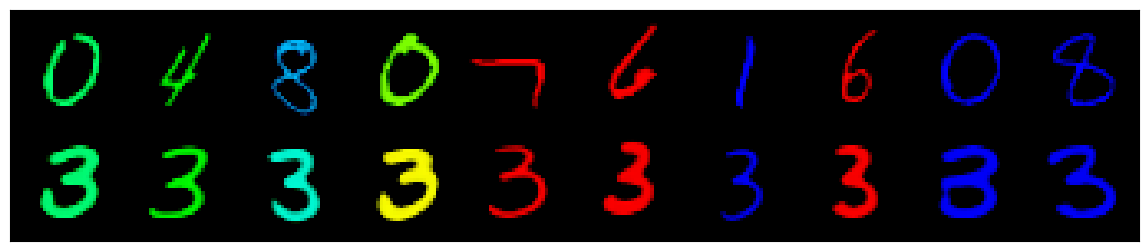

In [35]:
next_iter = next(iter(train_dataloader))
x_source = (next_iter[0] * 2 - 1).cuda()[:10]
y_source = next_iter[1].cuda()[:10] + 1
y_source_ohe = torch.nn.functional.one_hot(y_source, num_classes=11).float().to('cuda')
x_out, out_hist, noisy_image_hist = ddib(cond_model, x_source, y_source_ohe, target_label=3, params=sampling_params)
visualize_transform(x_source, x_out)

In [36]:
def visualize_transform_history(traj_enc, traj_dec, title = None):
    batch_cat = torch.cat(traj_enc + traj_dec, dim=0)
    image_grid = make_grid(batch_cat.cpu(), nrow=len(traj_enc[0]))
    fig, ax = plt.subplots(figsize=(16, 12))
    remove_ticks(ax)
    ax.imshow(image_grid.permute(1, 2, 0))
    if title is not None:
      plt.title(title)
    plt.show()


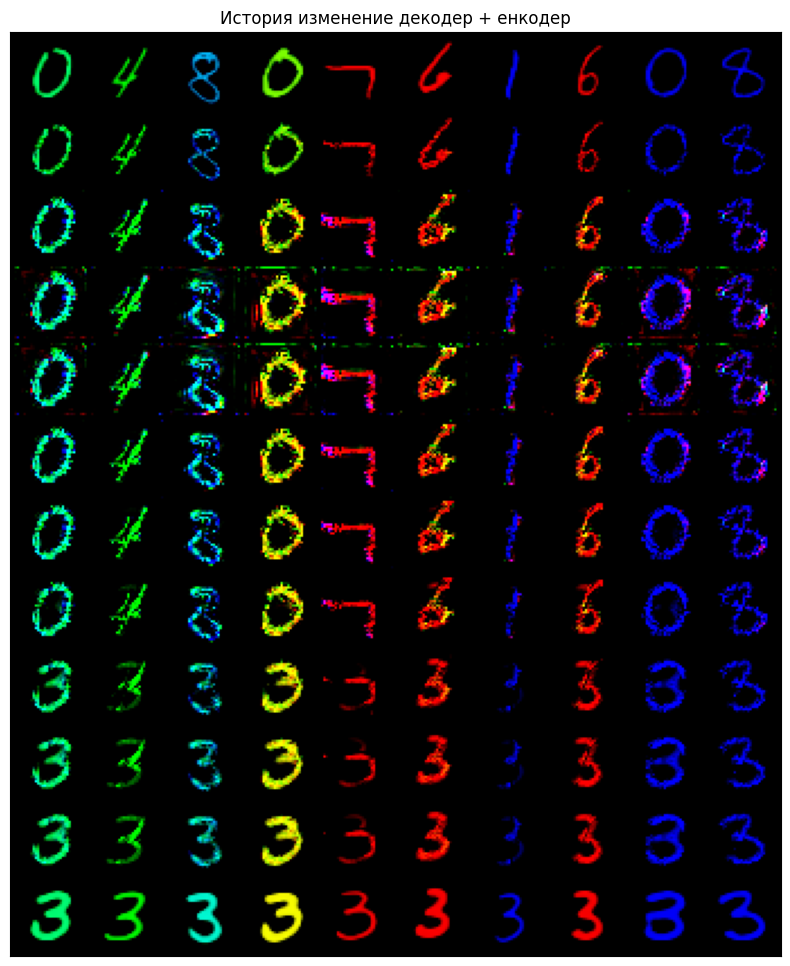

In [37]:
visualize_transform_history(noisy_image_hist, out_hist, title = 'История изменение декодер + енкодер')

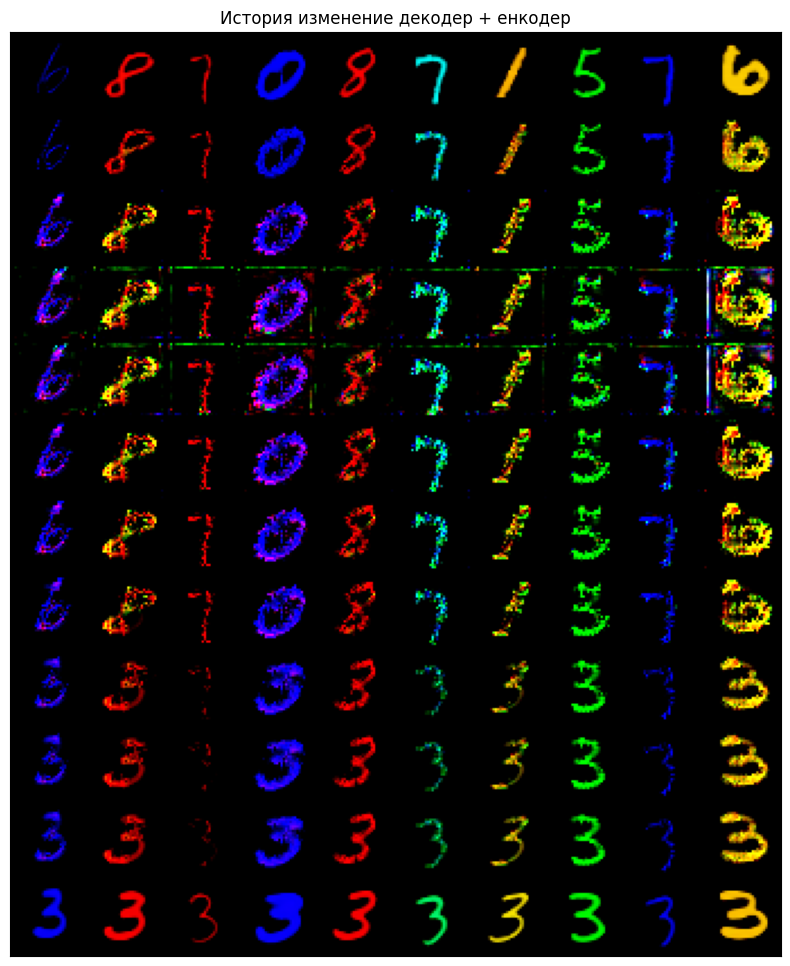

In [259]:
visualize_transform_history(noisy_image_hist, out_hist, title = 'История изменение декодер + енкодер')

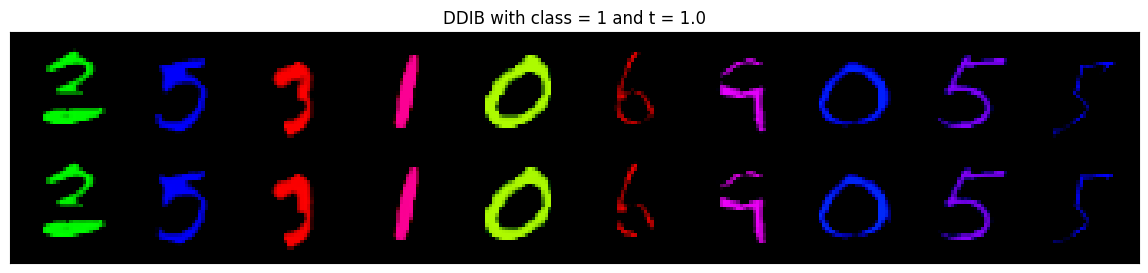

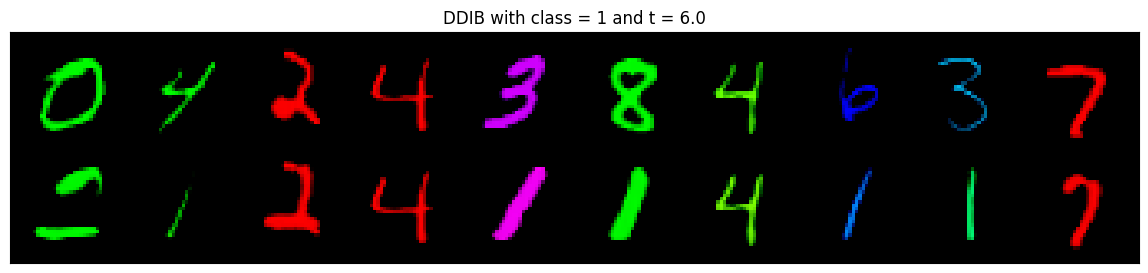

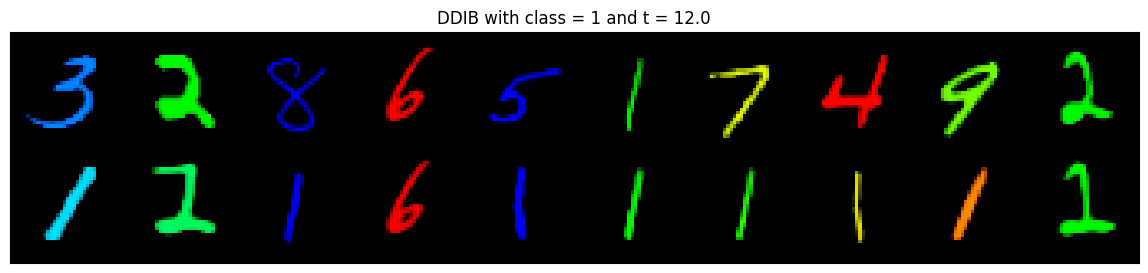

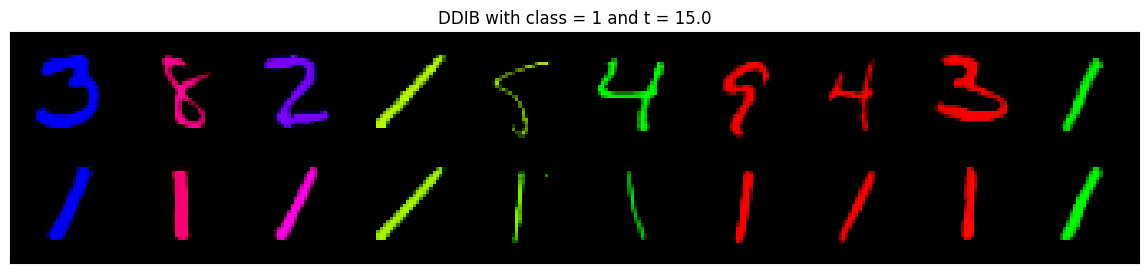

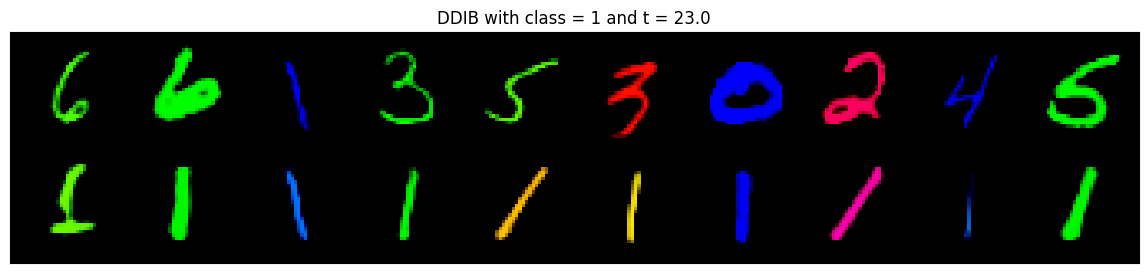

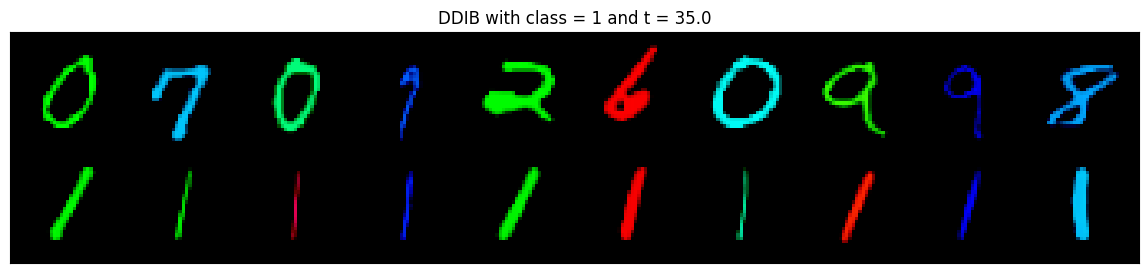

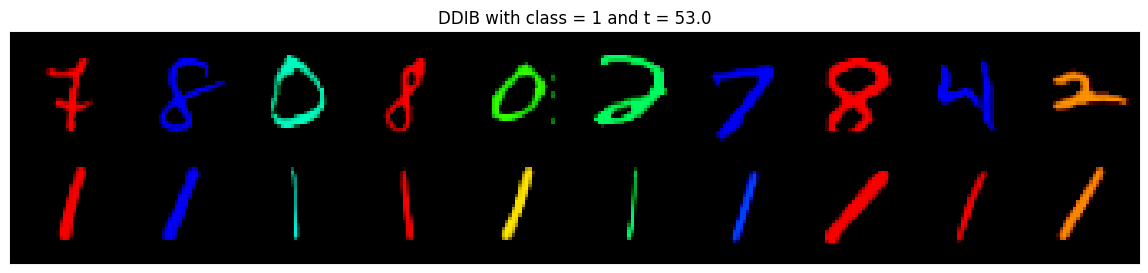

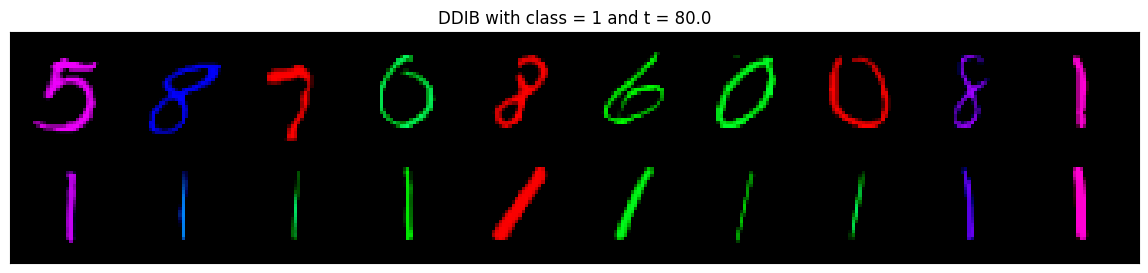

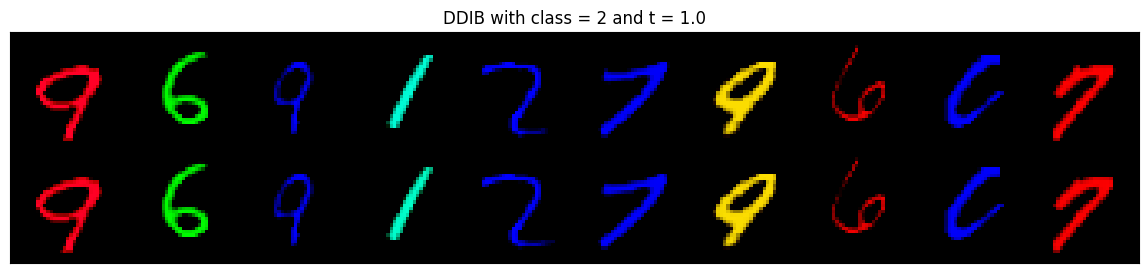

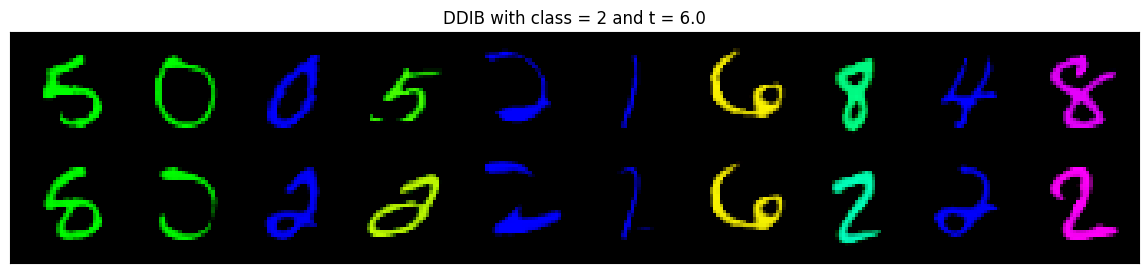

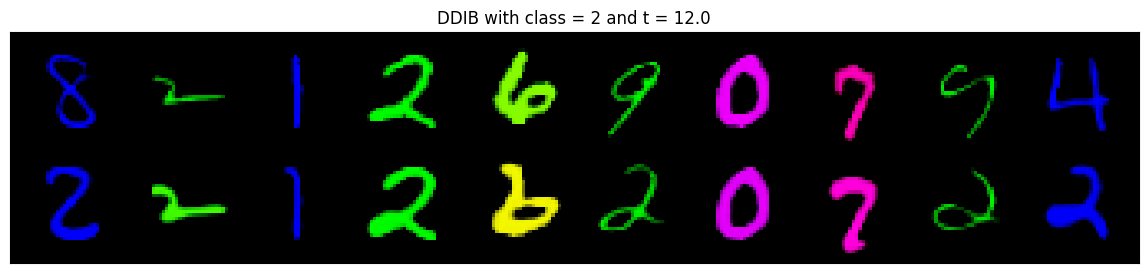

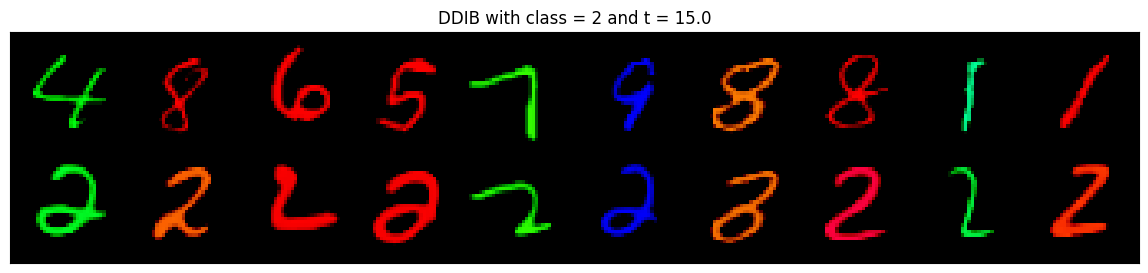

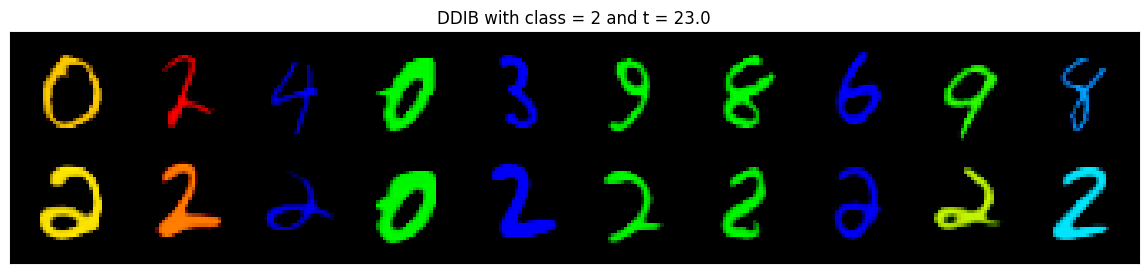

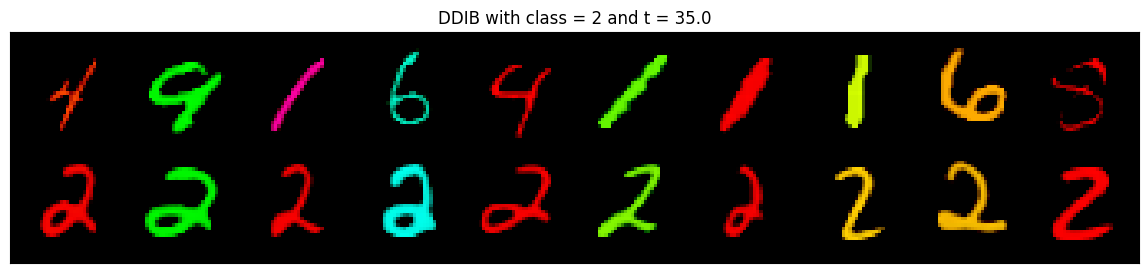

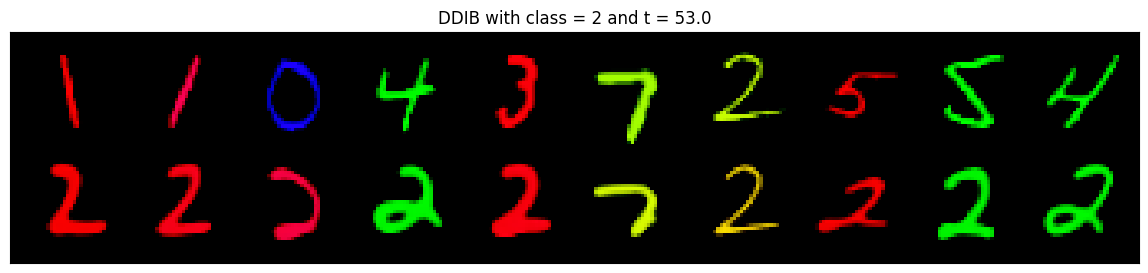

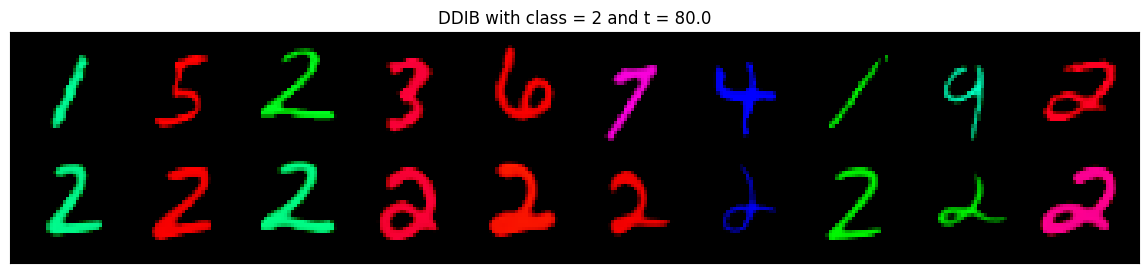

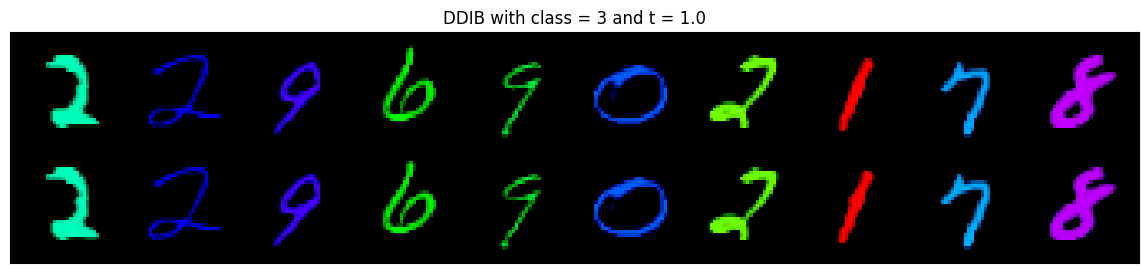

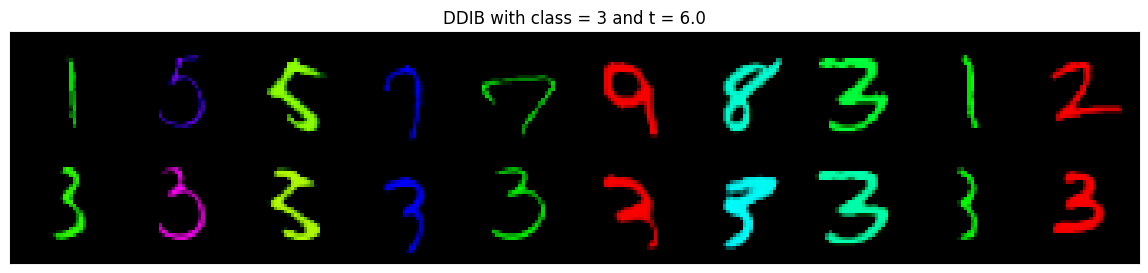

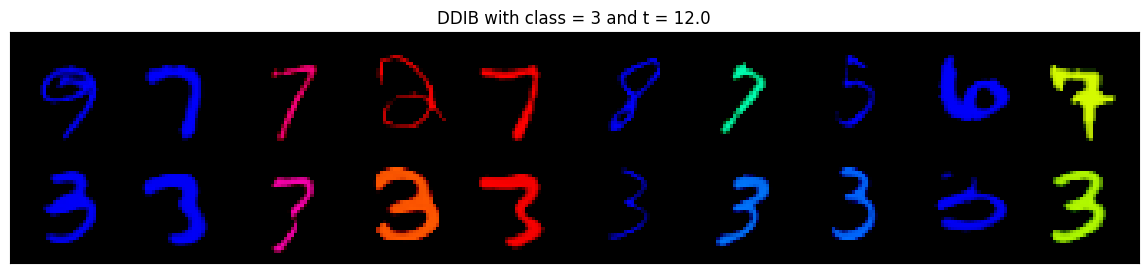

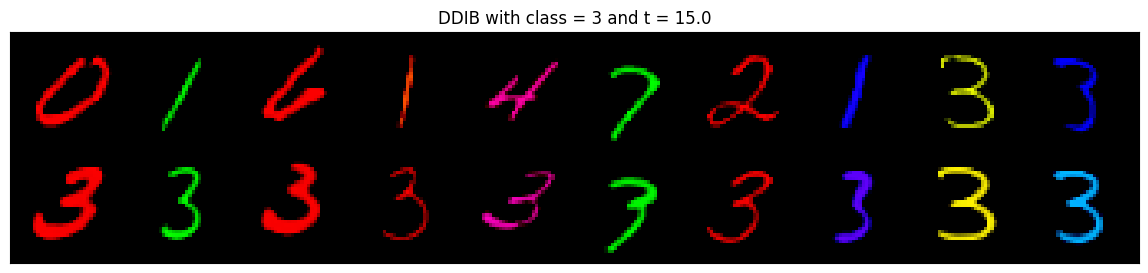

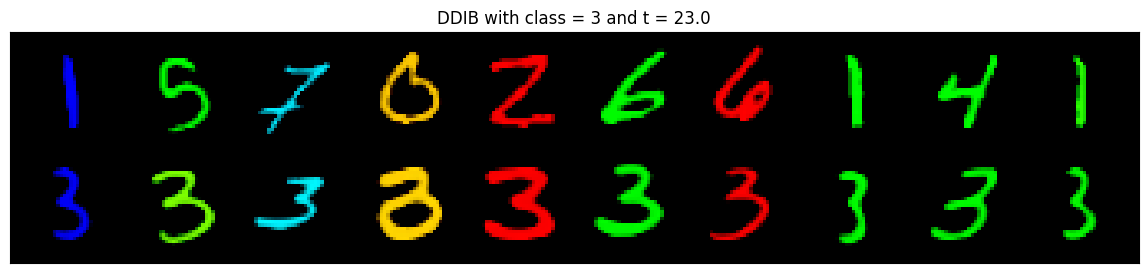

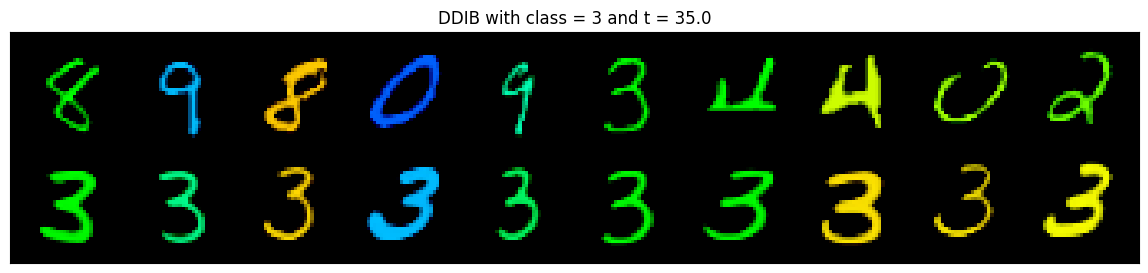

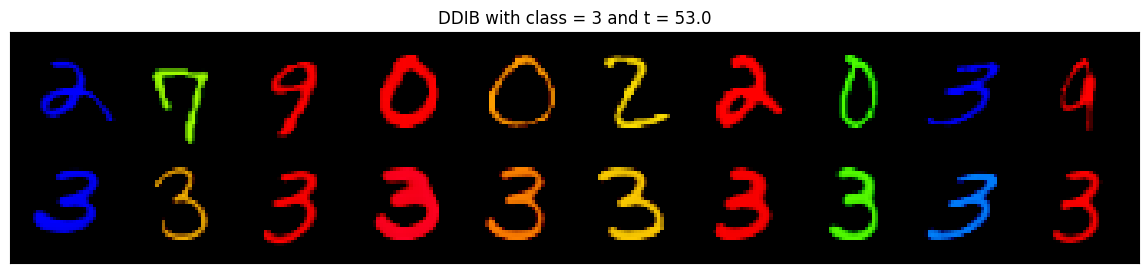

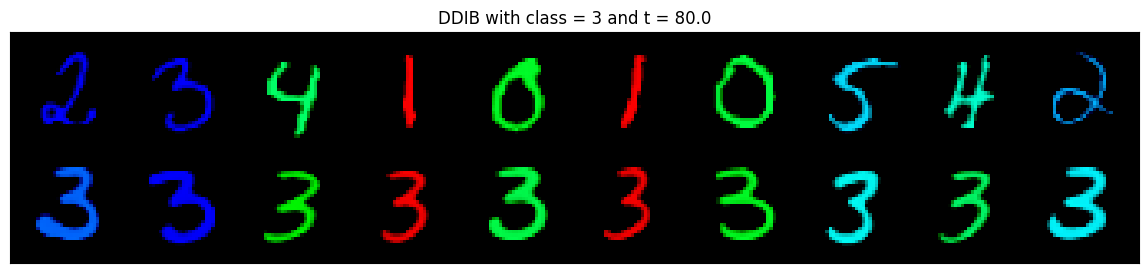

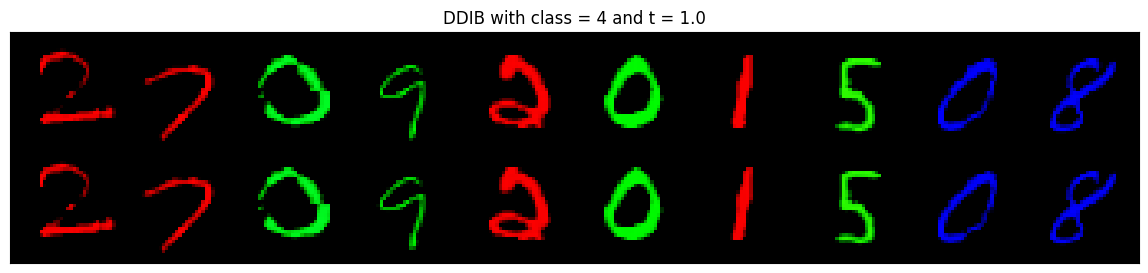

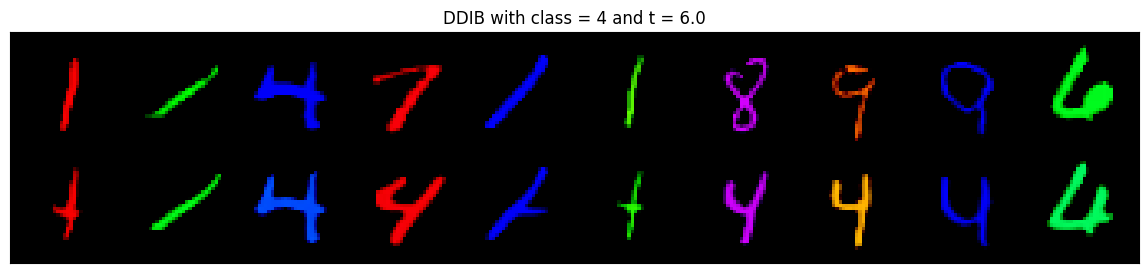

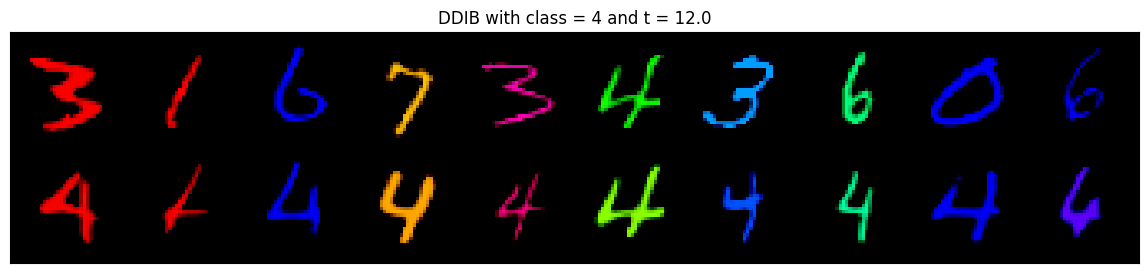

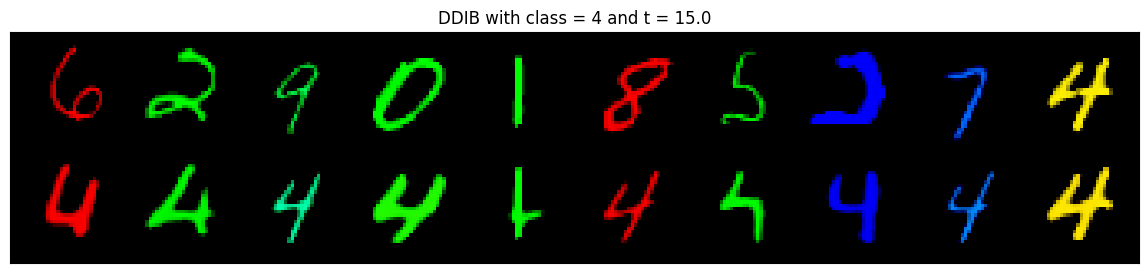

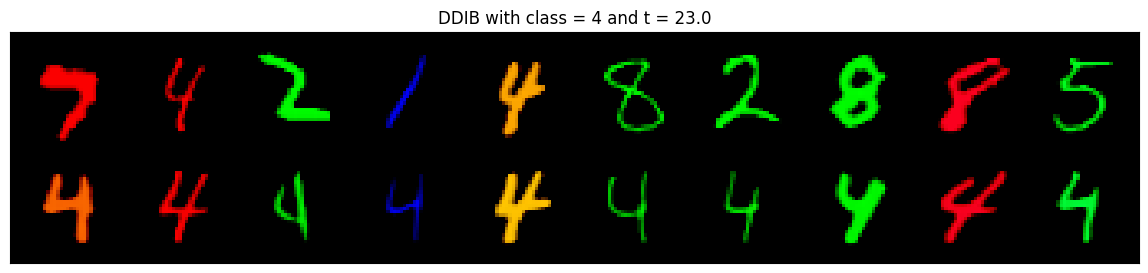

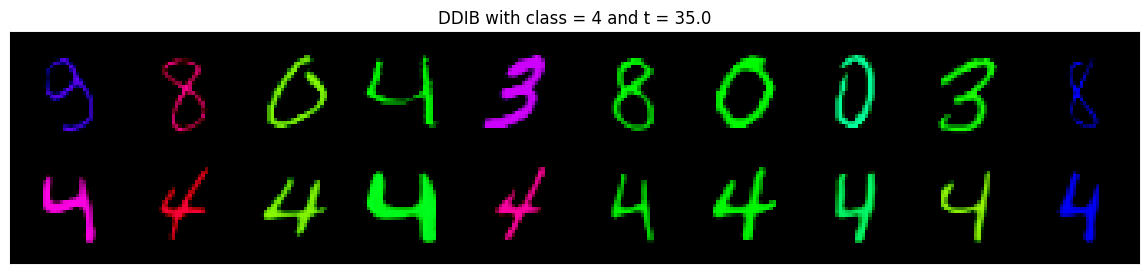

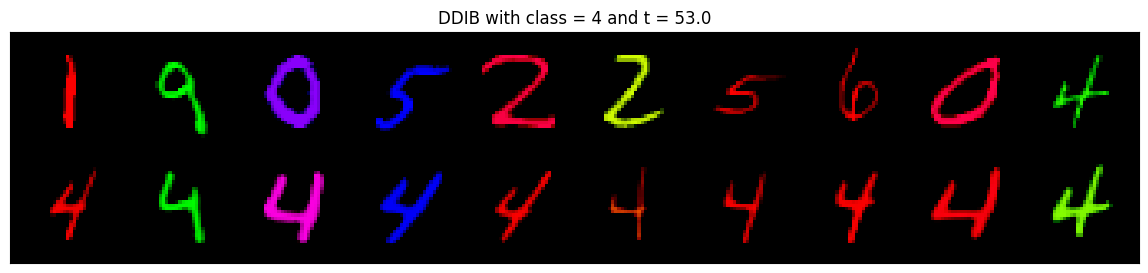

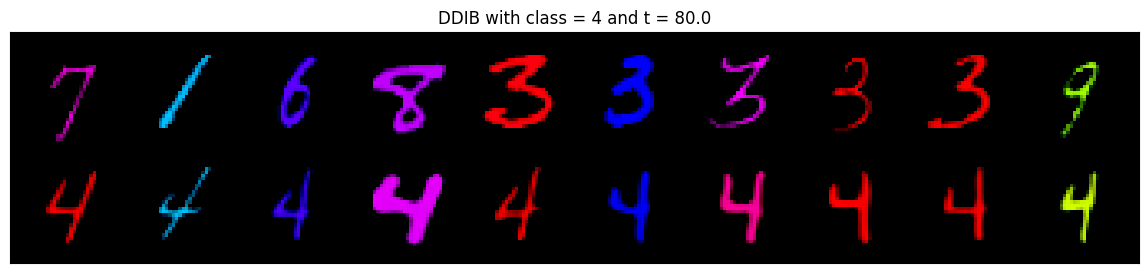

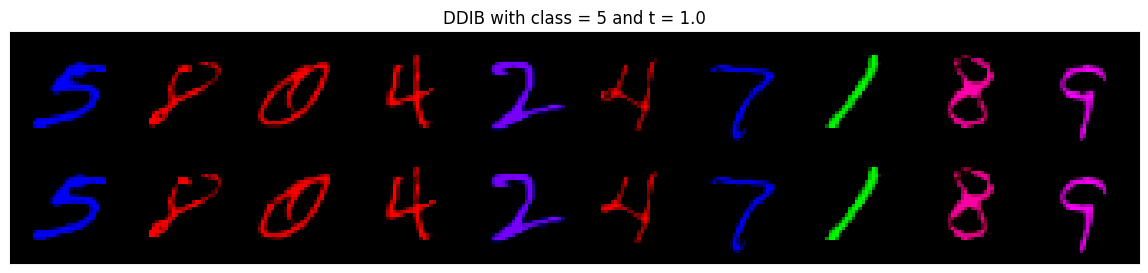

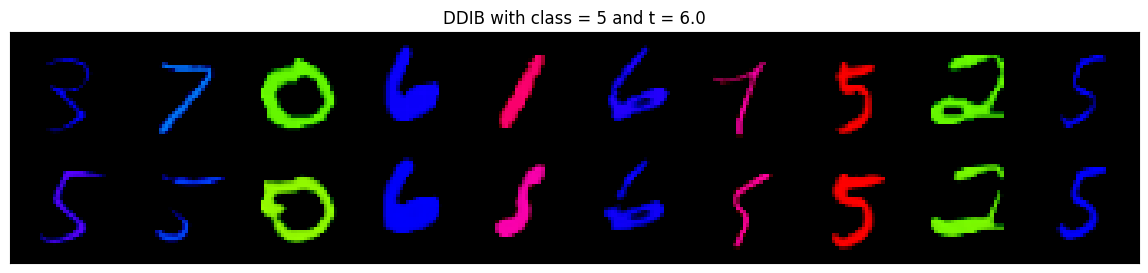

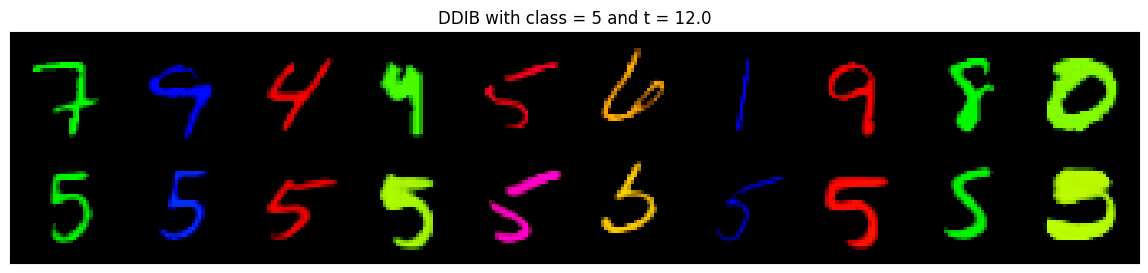

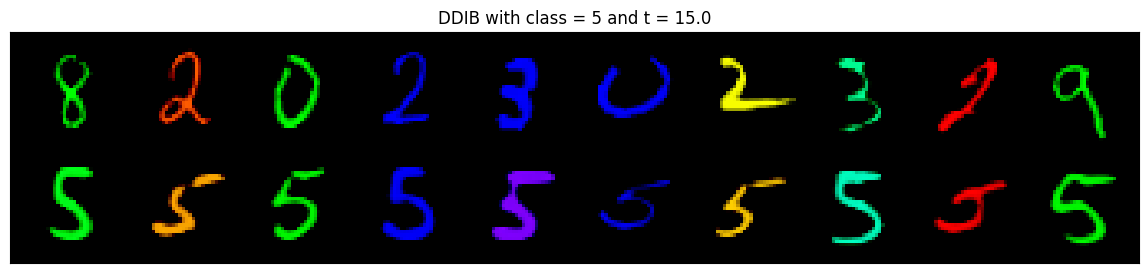

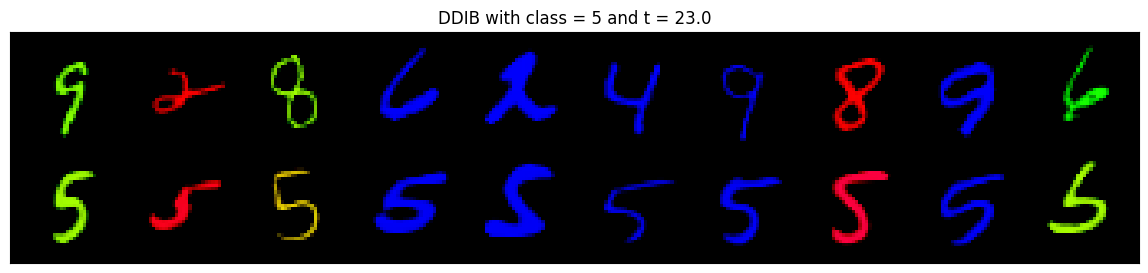

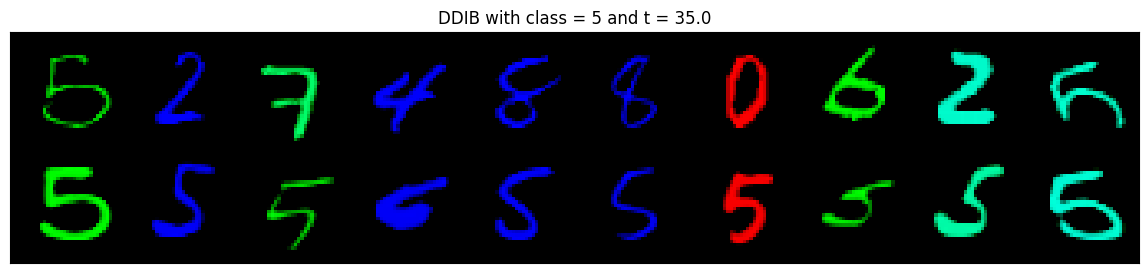

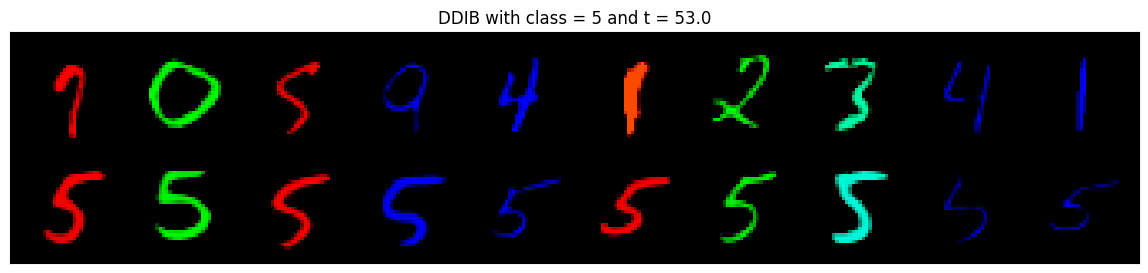

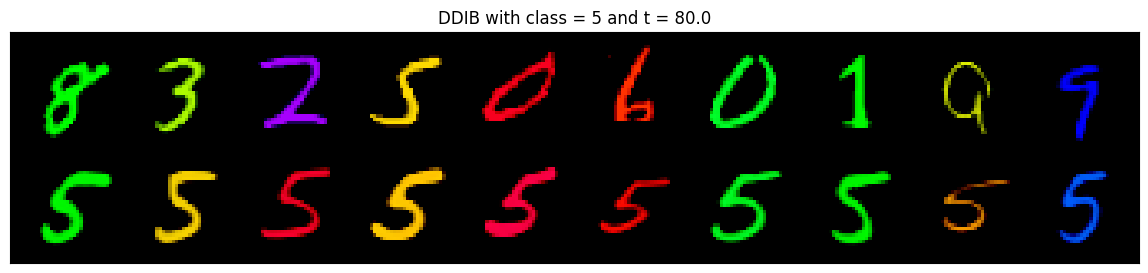

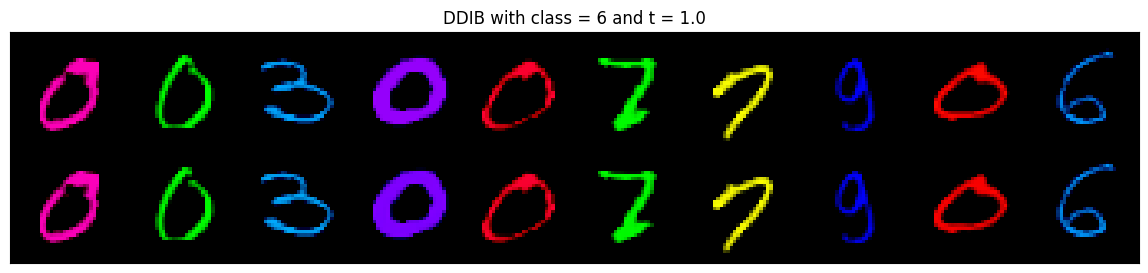

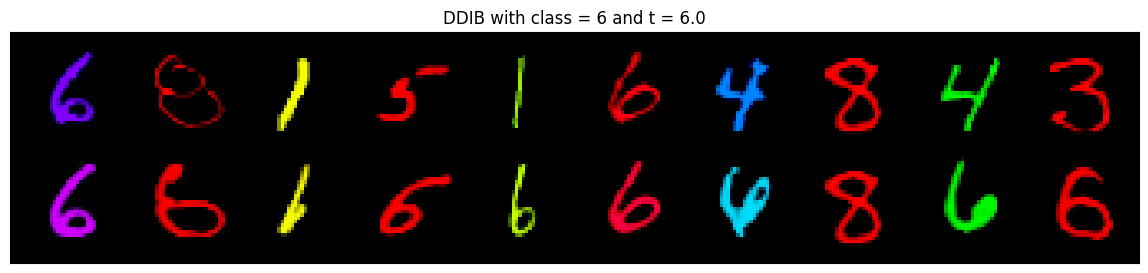

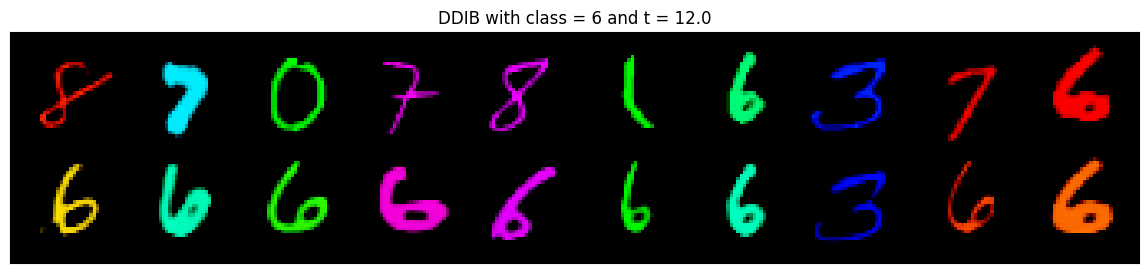

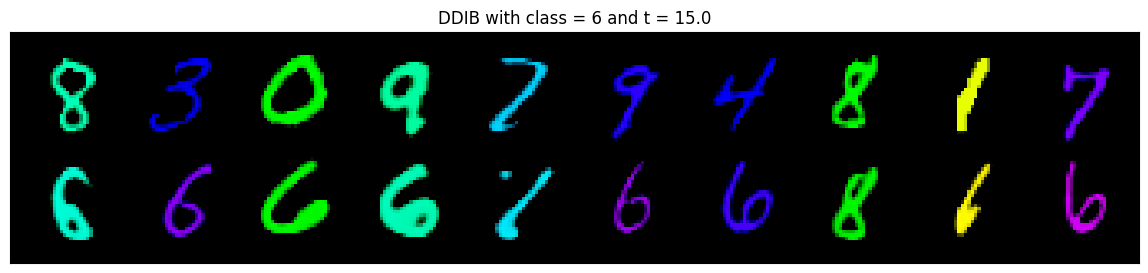

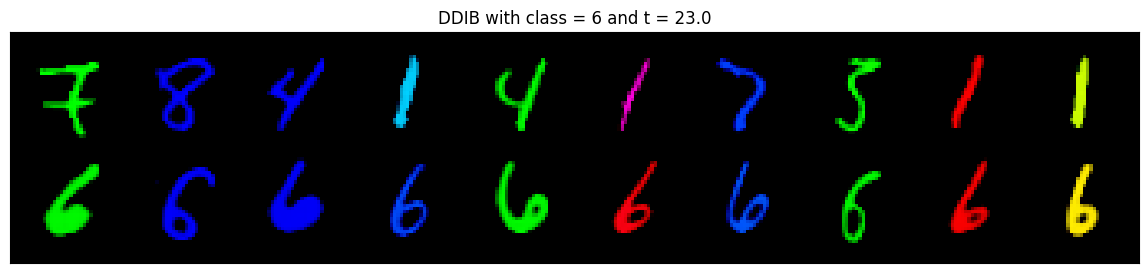

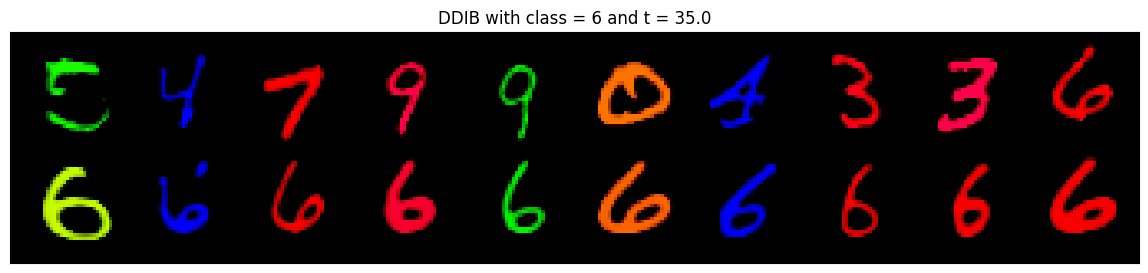

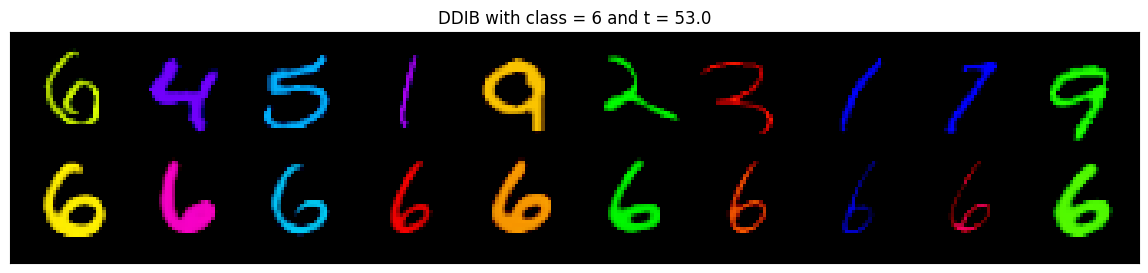

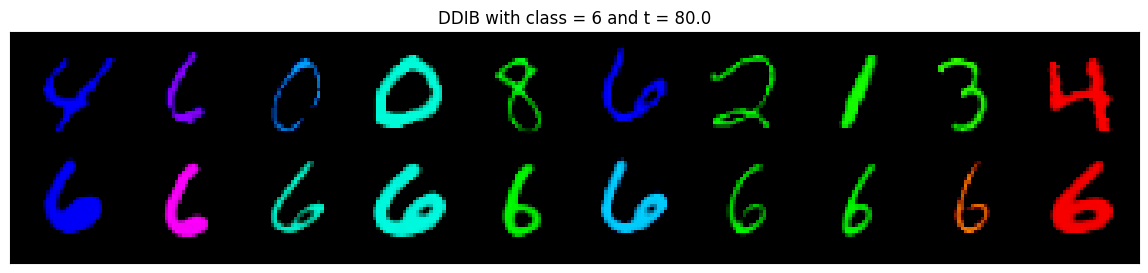

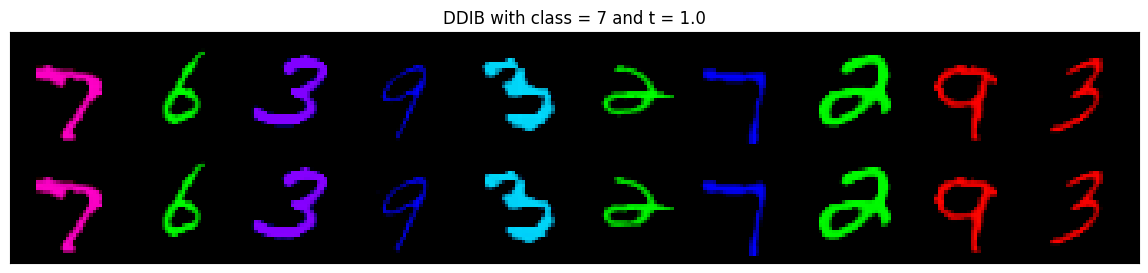

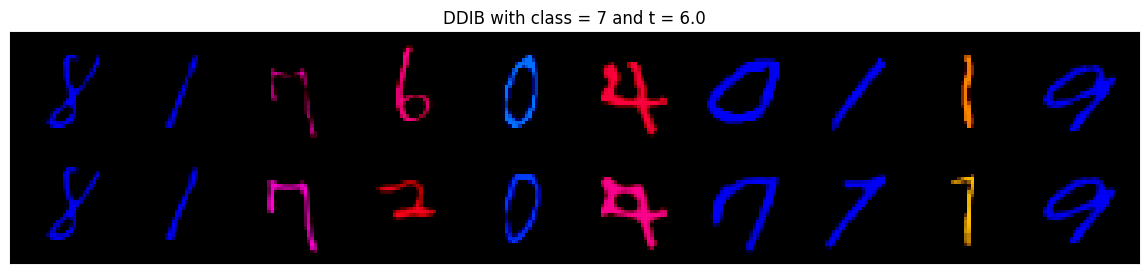

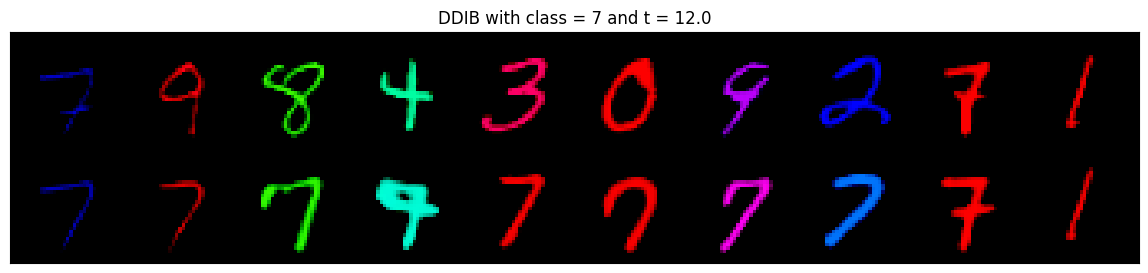

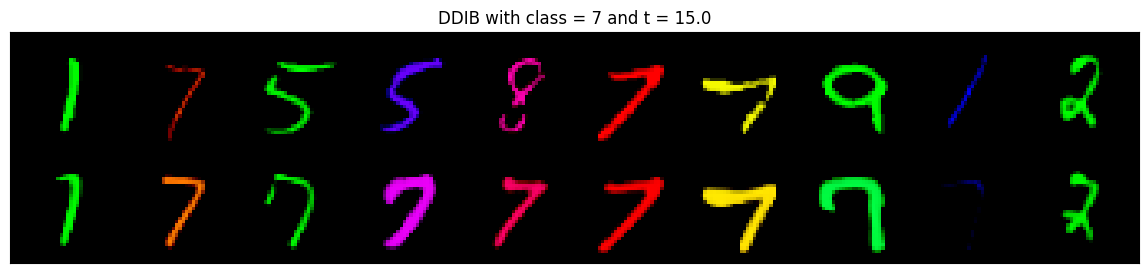

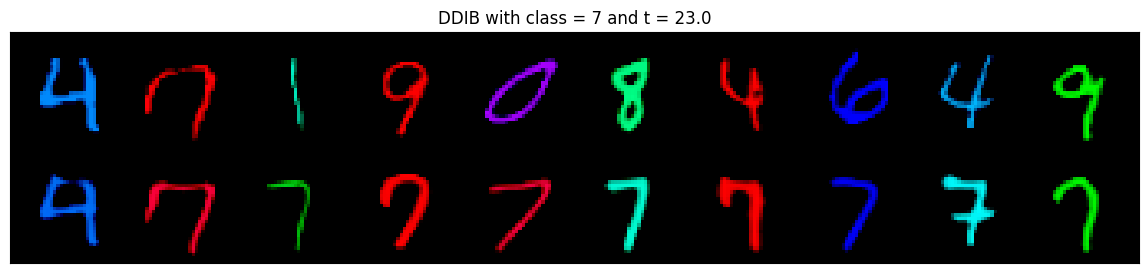

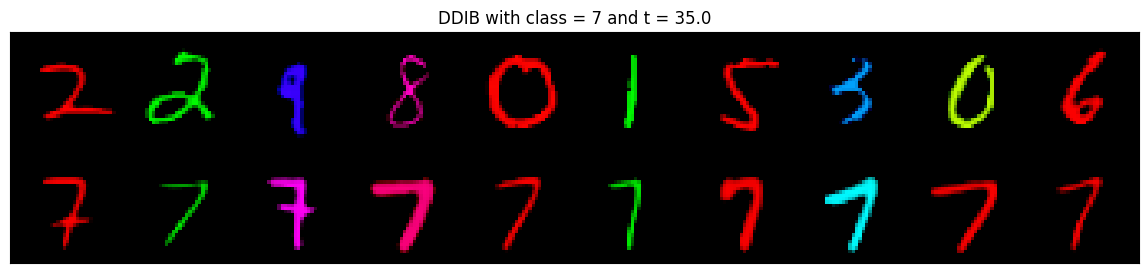

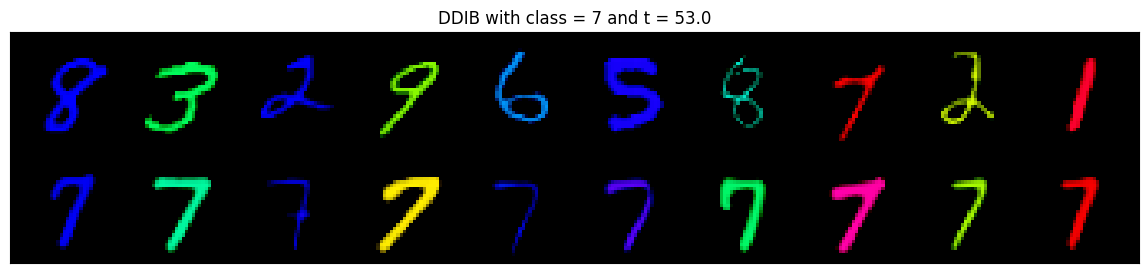

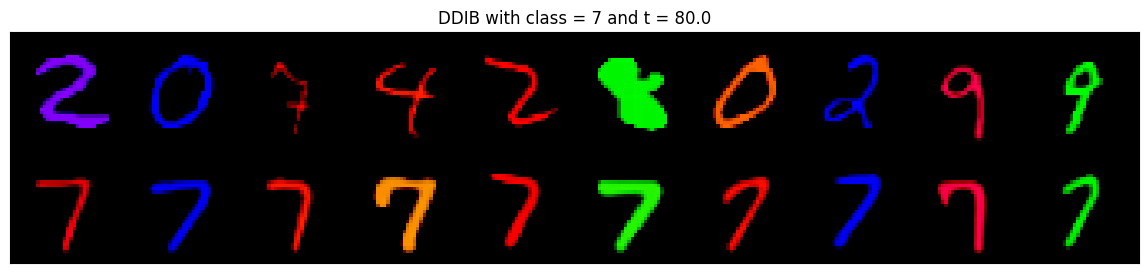

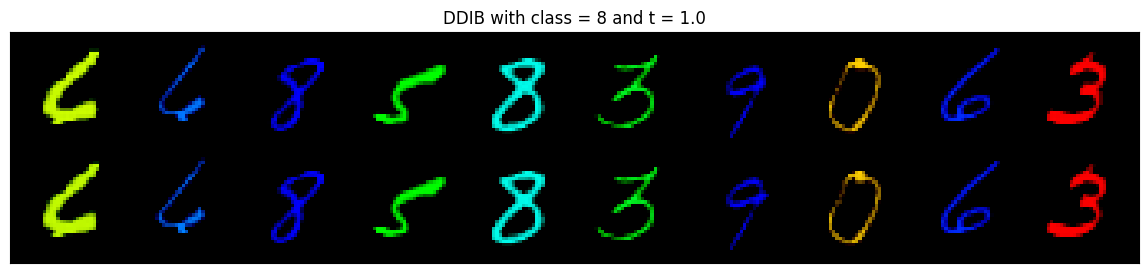

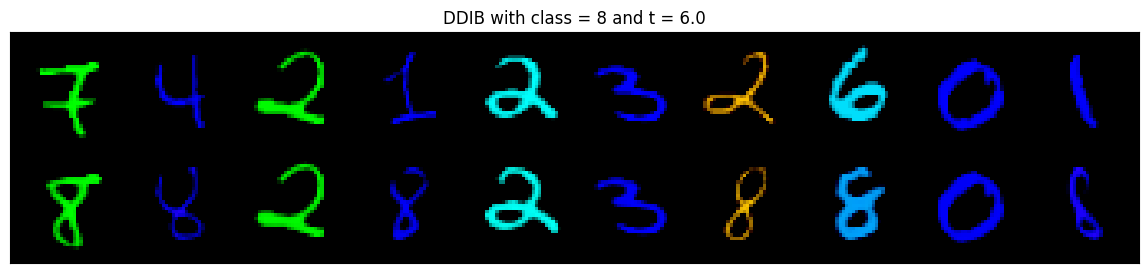

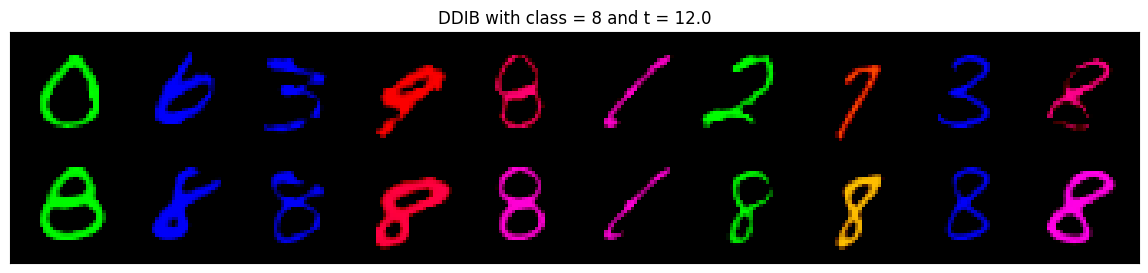

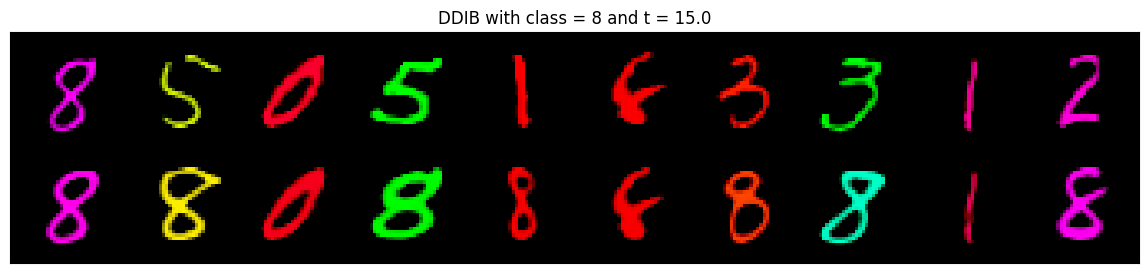

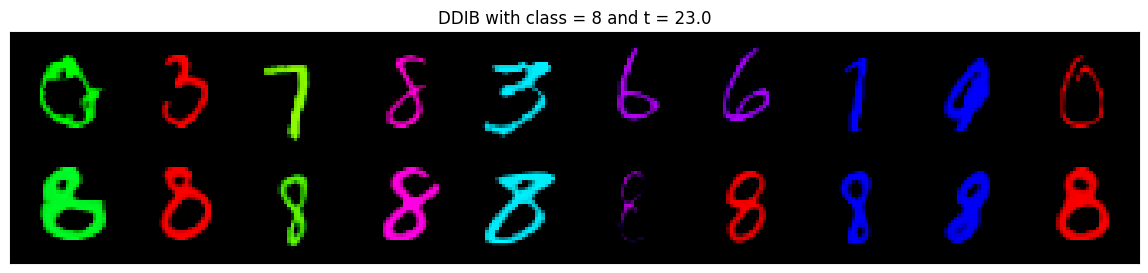

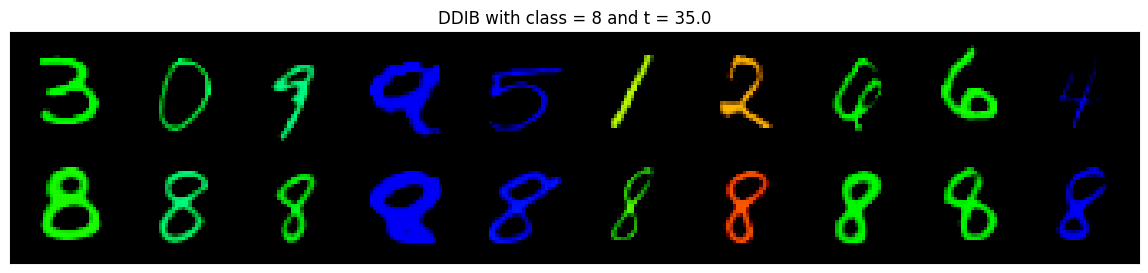

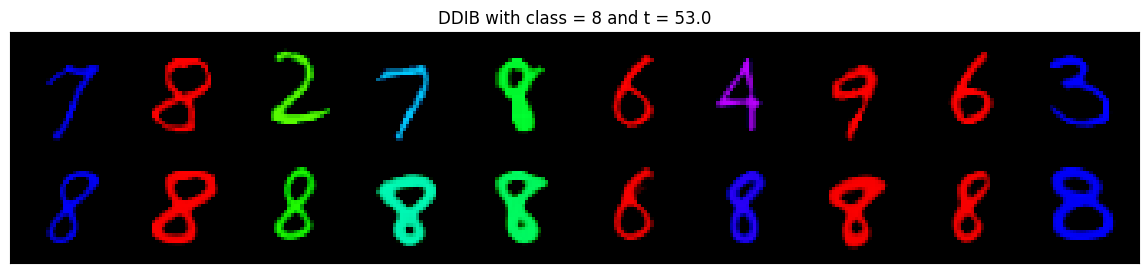

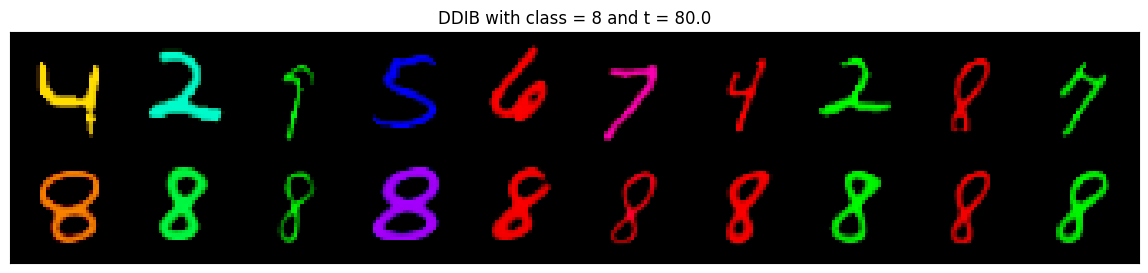

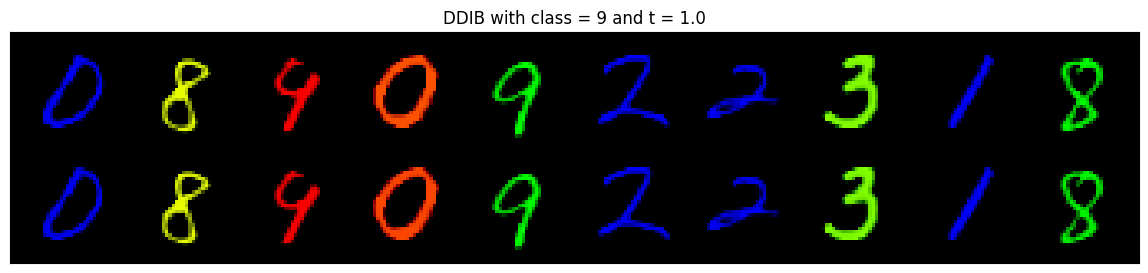

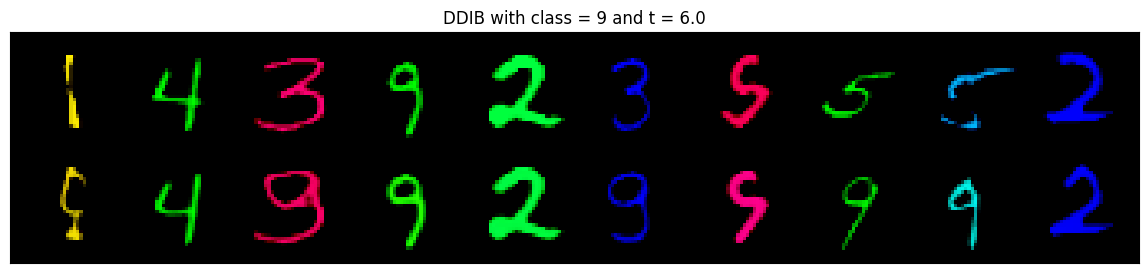

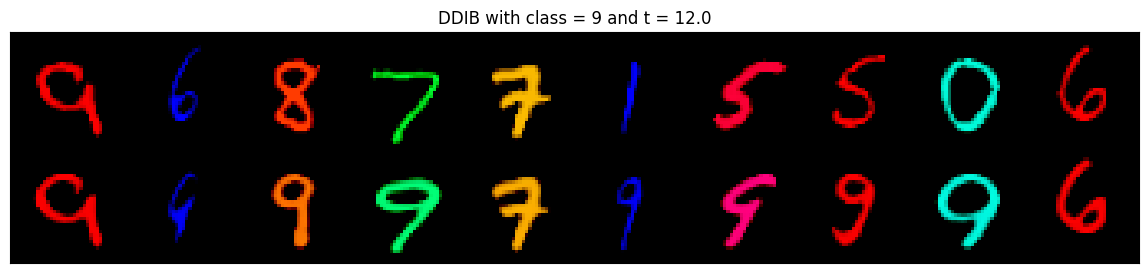

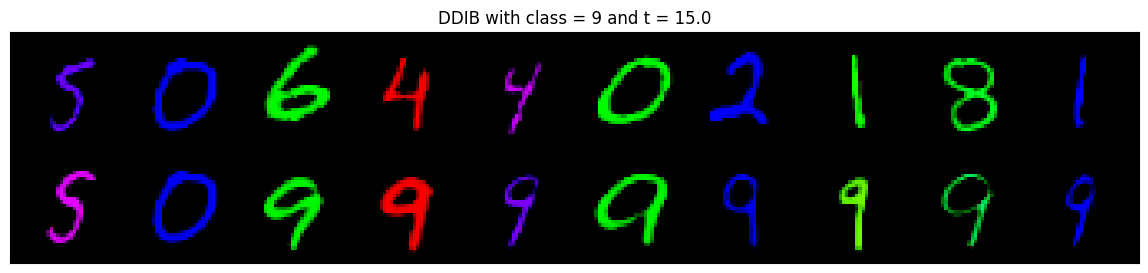

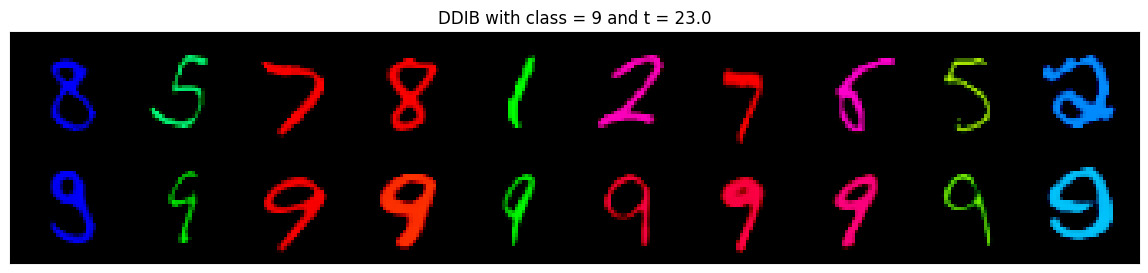

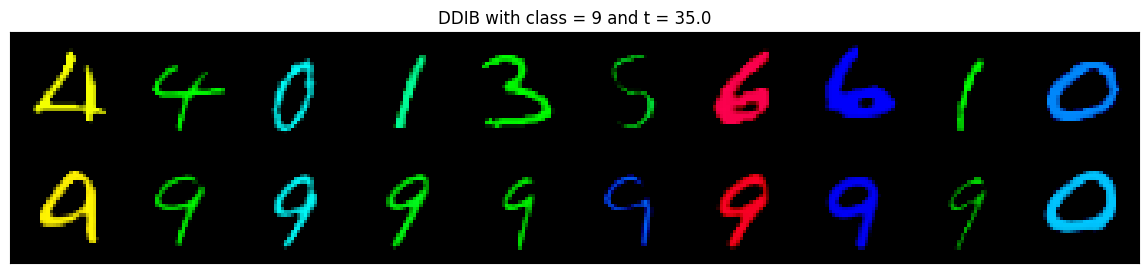

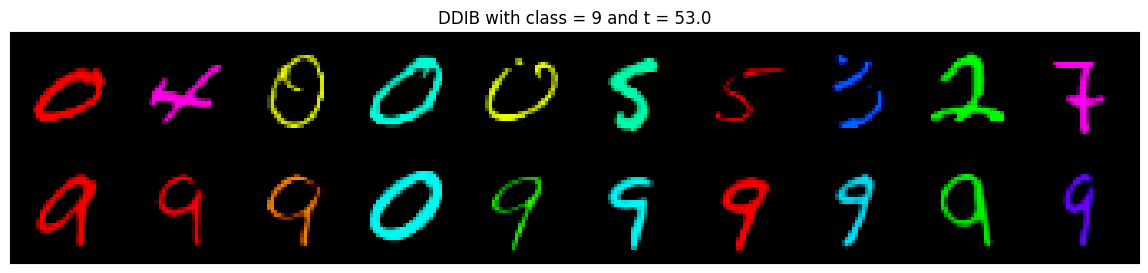

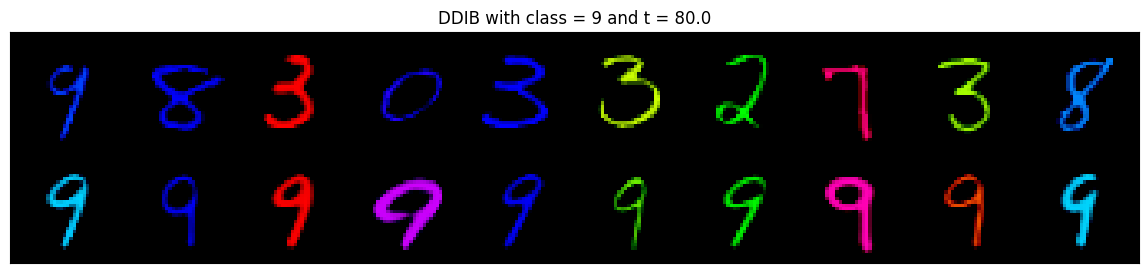

In [261]:
t_range = np.round(np.concatenate([np.linspace(1, 12, 3), np.exp(np.linspace(np.log(15), np.log(80), 5))]))
for number in range(1, 10):
    for t in t_range:
        sampling_params = {
          'device': 'cuda',
          'sigma_min': 0.02,
          'sigma_max': t,
          'num_steps': 30,
          'rho': 7.0,
          'vis_steps': 1,
          'cfg': 1.0,
          'stochastic': False
        }

        x_source = (next(iter(train_dataloader))[0] * 2 - 1).cuda()[:10]
        y_source = next_iter[1].cuda()[:10] + 1
        y_source_ohe = torch.nn.functional.one_hot(y_source, num_classes=11).float().to('cuda')
        x_out, _, _ = ddib(cond_model, x_source, y_source_ohe, target_label=number, params=sampling_params)
        visualize_transform(x_source, x_out, title = f'DDIB with class = {number} and t = {t}')

*  *Похож ли "детерминированный шум", полученный при кодировании входа, на семпл из нормального распределения?*.

Видно довольно шумные картинки, но с явным очертанием чисел. Можно, наверное, сказать, что похож на смесь гаусиан, чтобы обосновать паттерн фигуры, но если говорить о обычном двумерном шуме, то мало на него похож. Но в целом мне кажется это логично. Зачем нам иметь какой-то шум являющеся нормальным, если можно иметь основную фотографиию с паттерном цифры замушленной, чтобы подкорректировать шум, приводя цифру к нужной.



  
* * Как меняется качество работы модели при изменении ее единственного гиперпараметра — уровня шума $t$, до которого кодируется исходная картинка. Какой уровень шума $t$ нужно использовать?*

Явно с t = 6 до t = 15 получается не очень, много случаев когда он не успел перевести одно число в другое (для 4, 7, 8, 9). Также t = 23 тоже на грани для этой проблемы, но в целом удолетворительно. Интересно, что и при большом шуме возникают проблемы. например, начиная с t = 35 метод не может перевести 0 в 9 (см class = 9), аналогично для класса 8 при t = 53. Скорее всего оптимум находится между 23 и 35, а при меньших и больших значений чем этот диапазон ситуация начинает ухудшаться, подать качество. Особенно при большом шуме падает похожесть. Но в целом, в большинстве случае наклон похож, "загугулинки" похожи. Далее рассмотрю  подробнее 23 и 35.

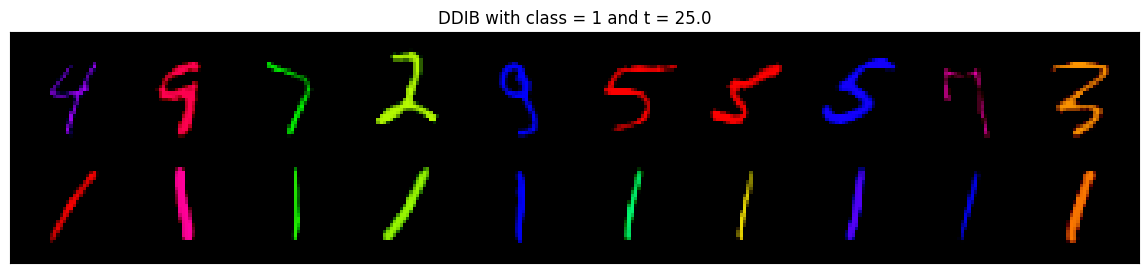

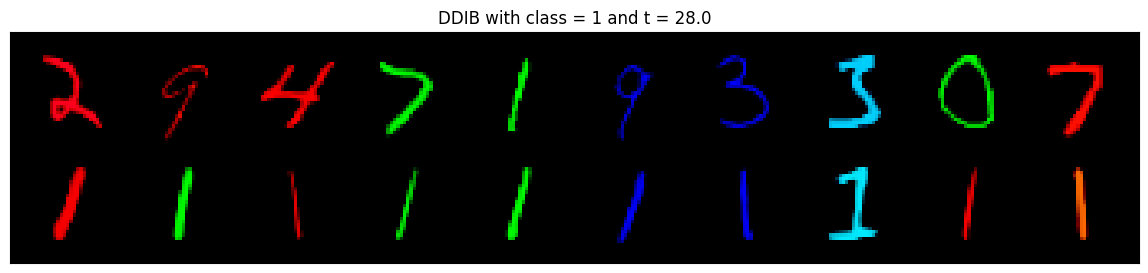

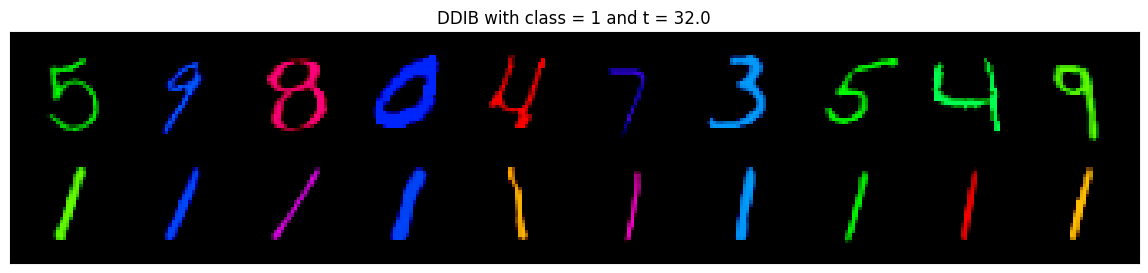

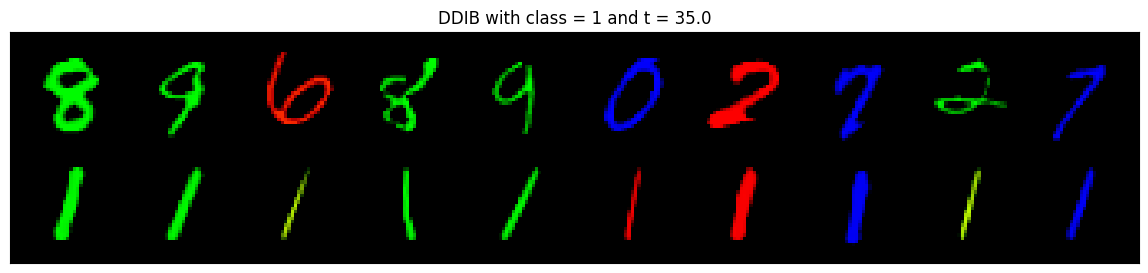

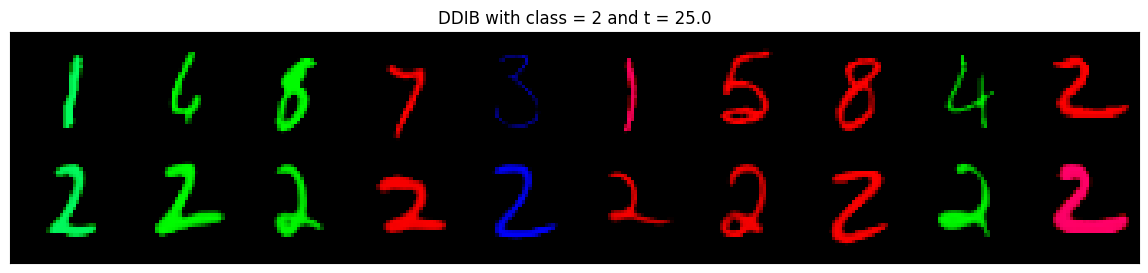

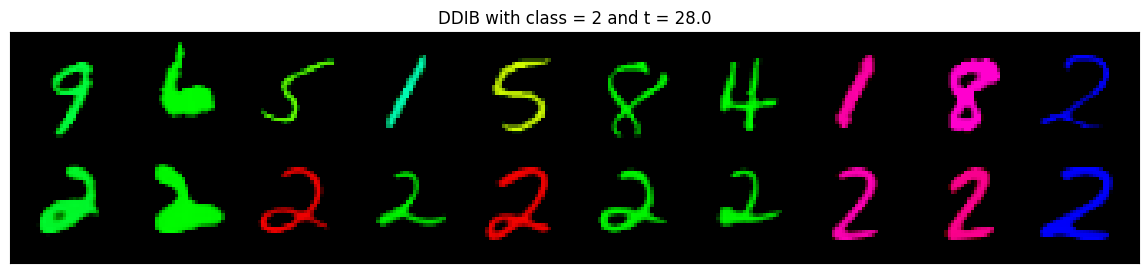

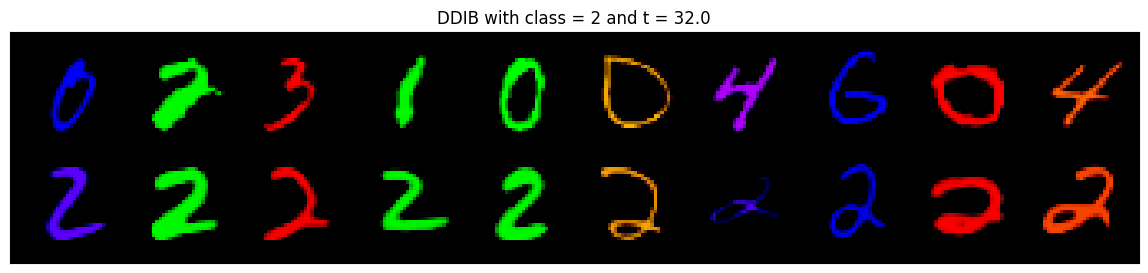

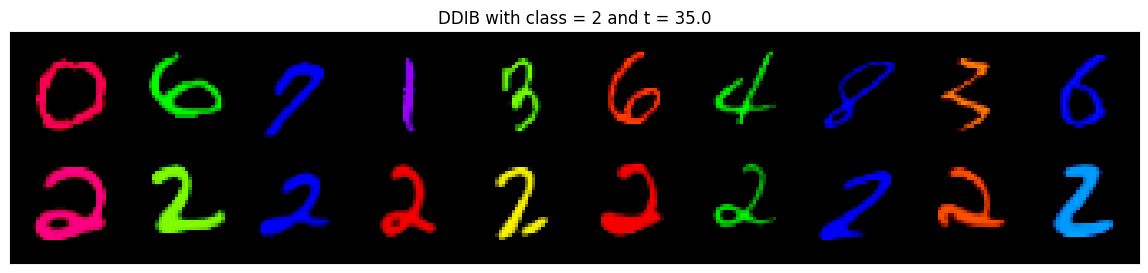

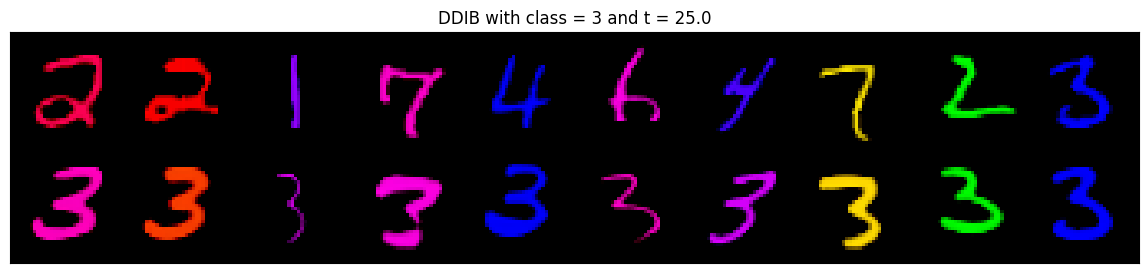

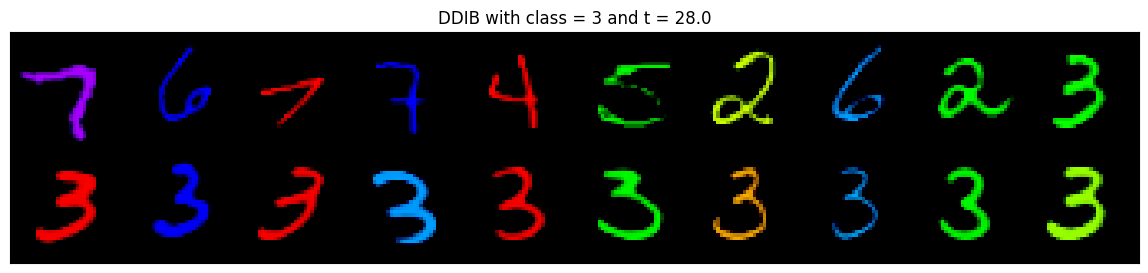

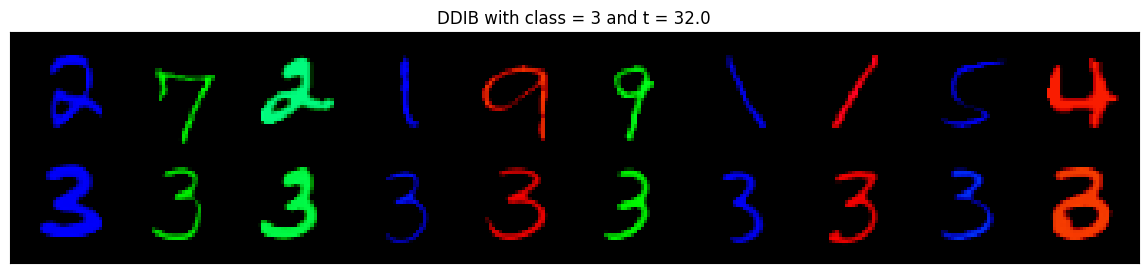

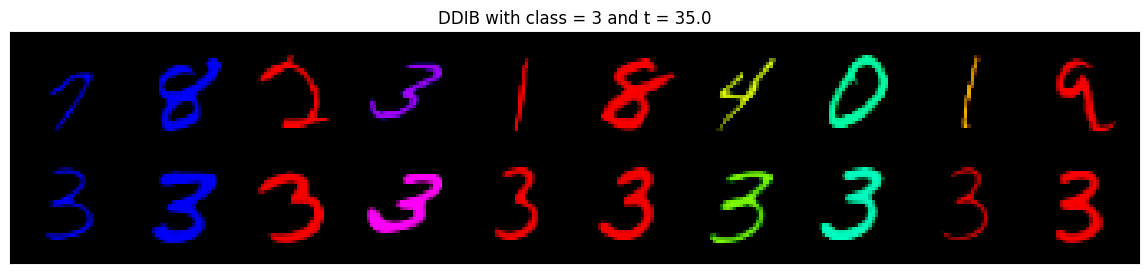

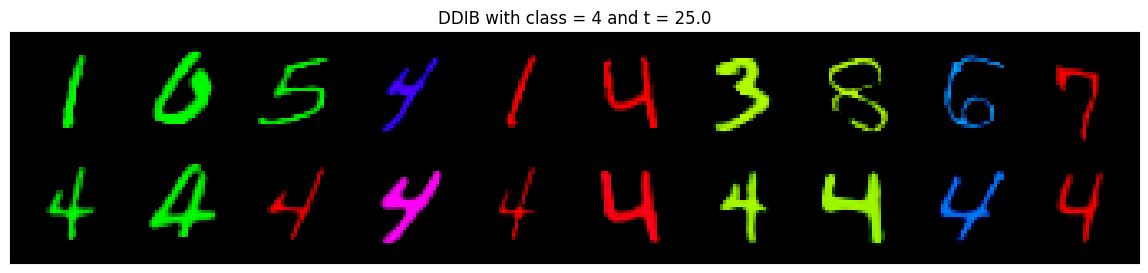

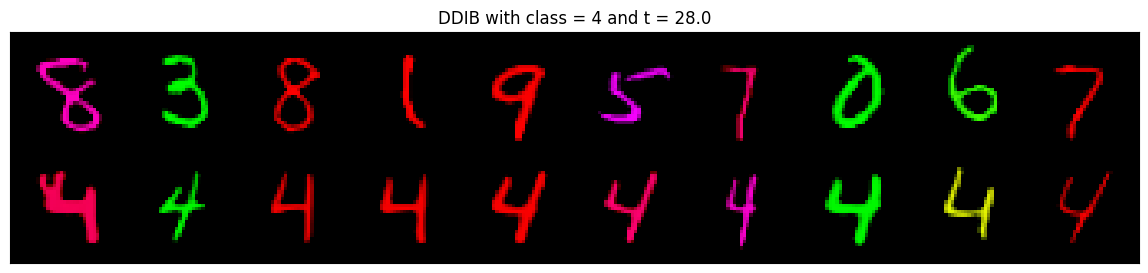

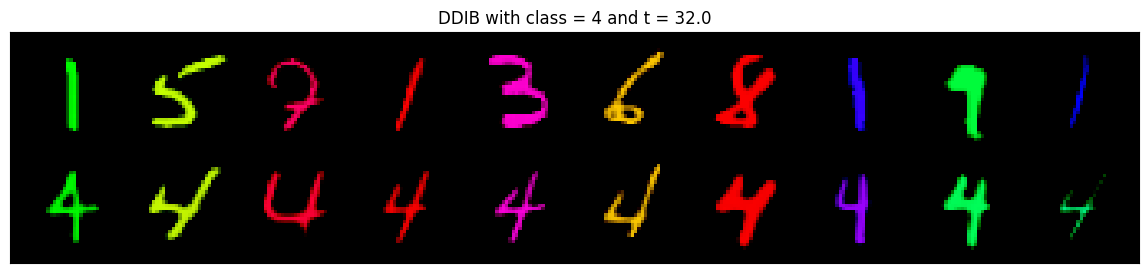

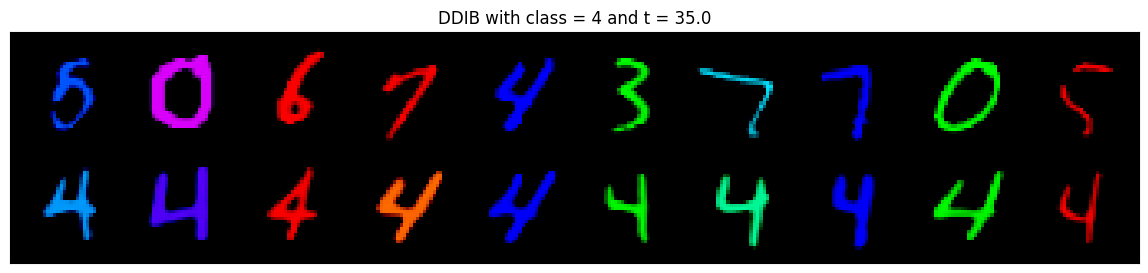

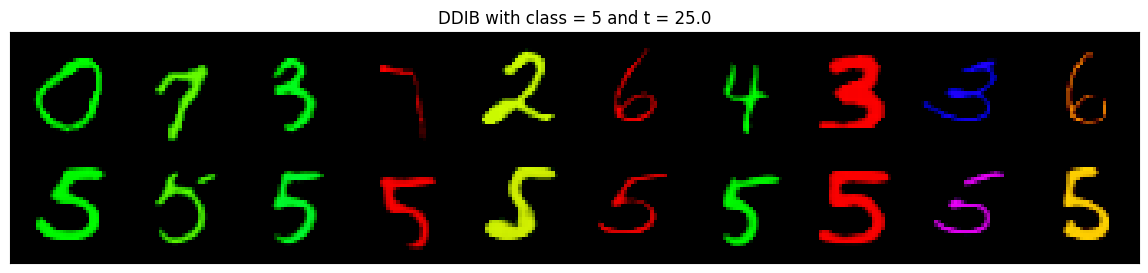

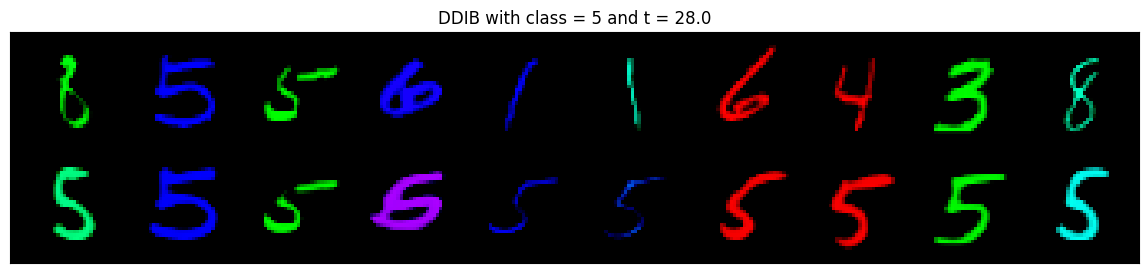

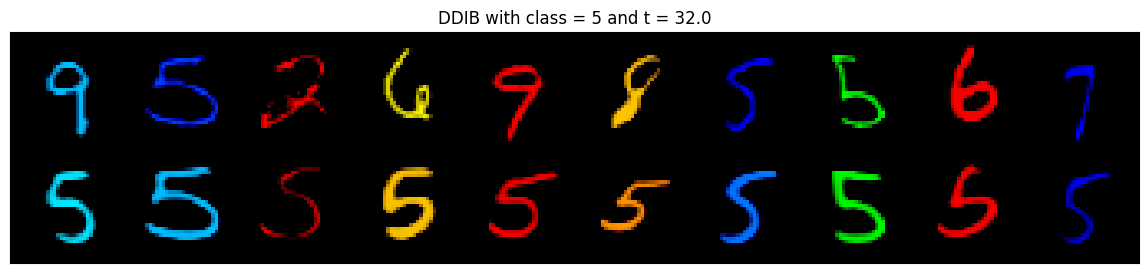

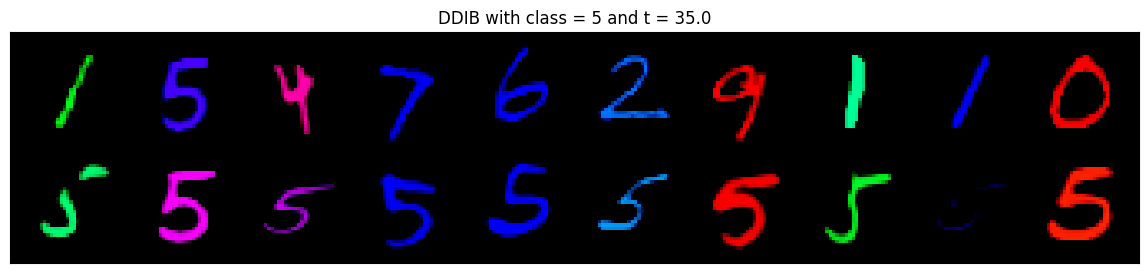

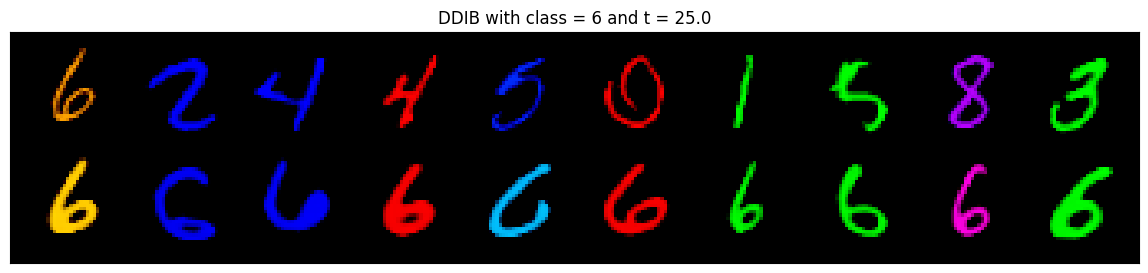

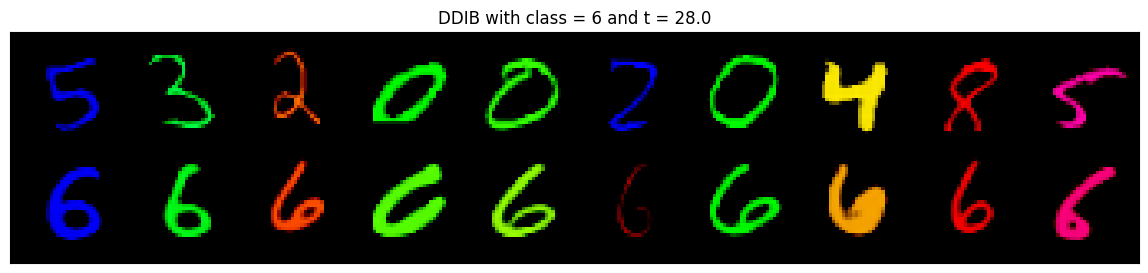

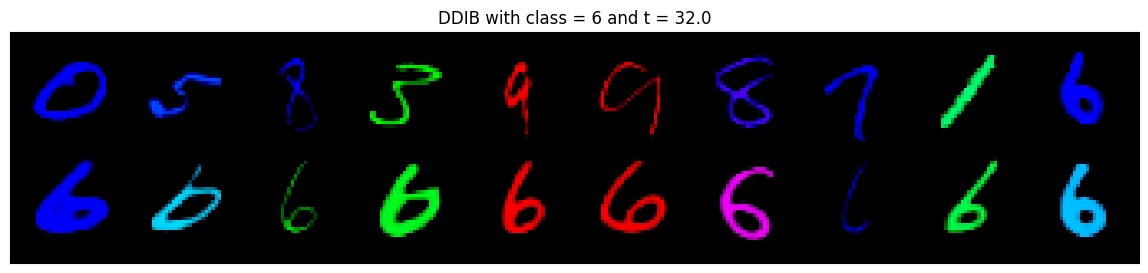

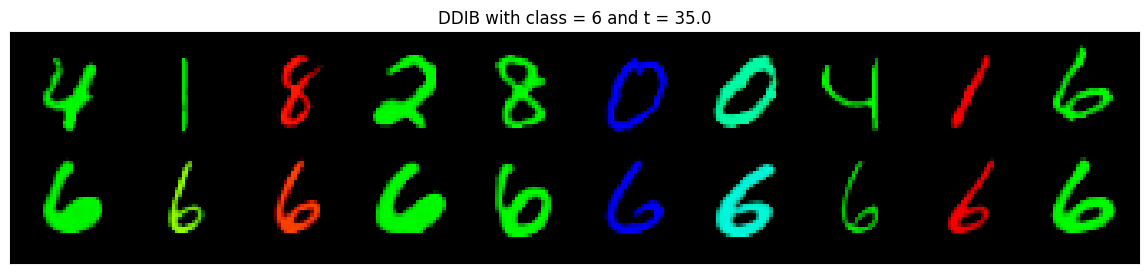

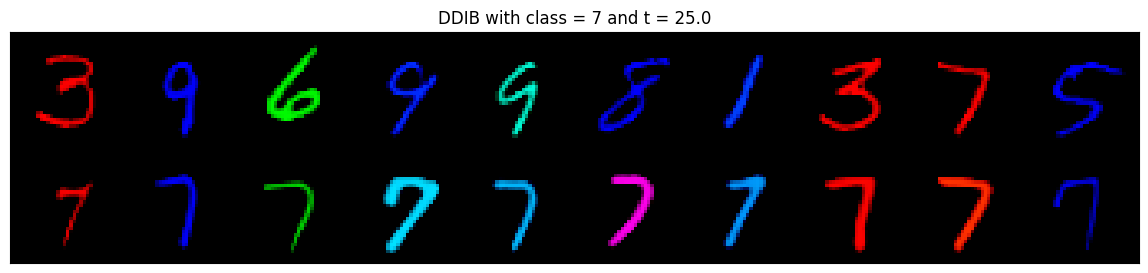

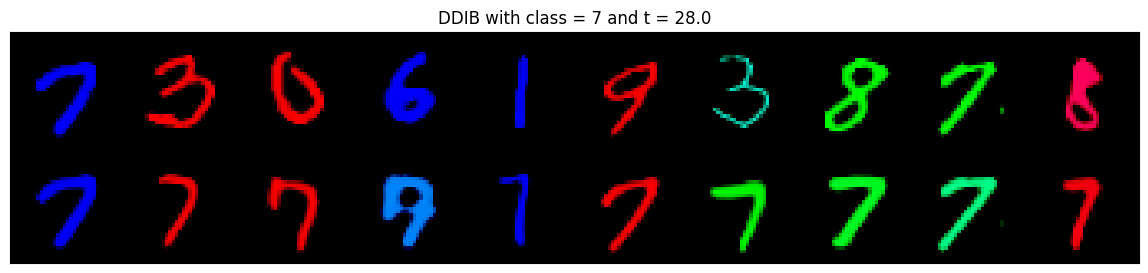

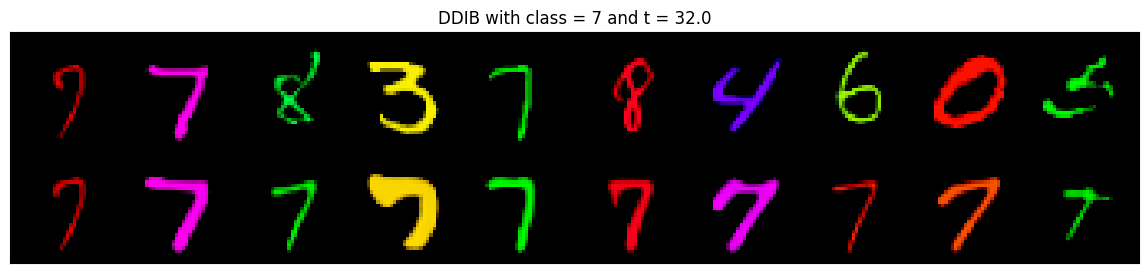

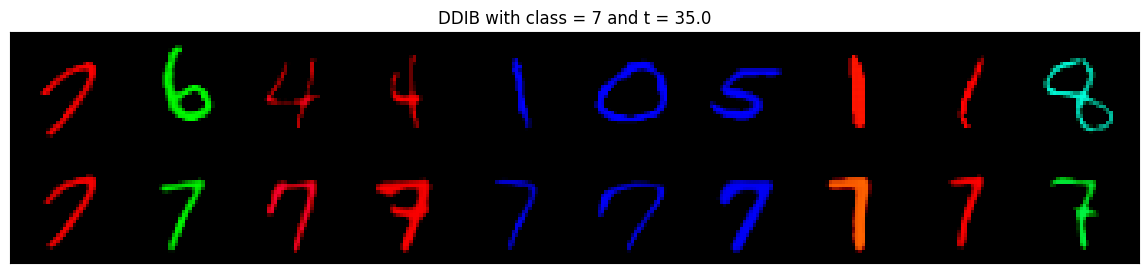

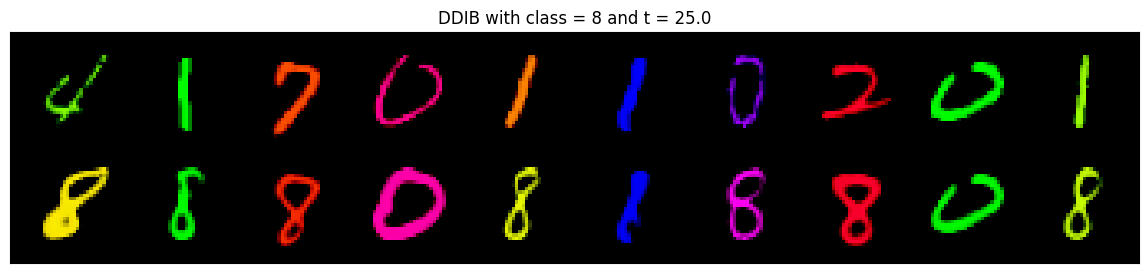

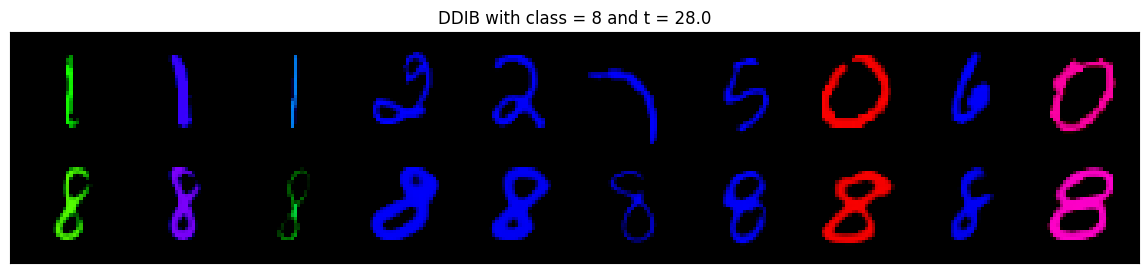

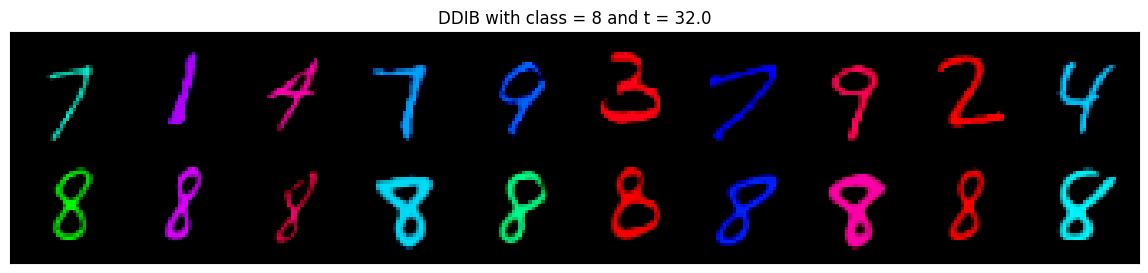

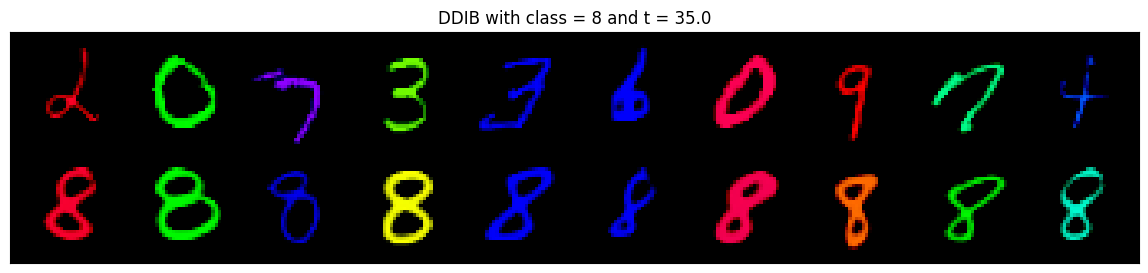

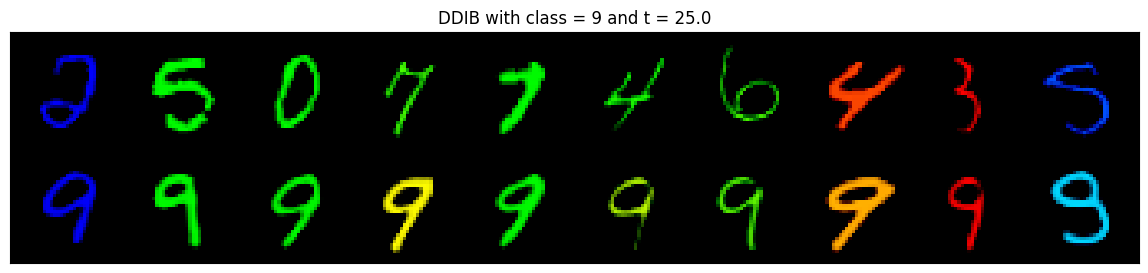

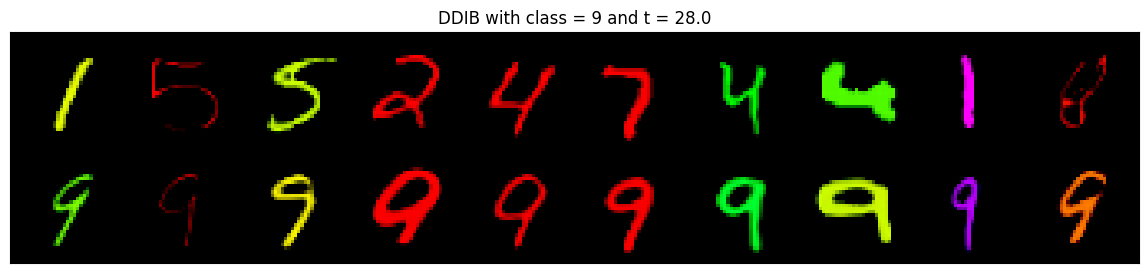

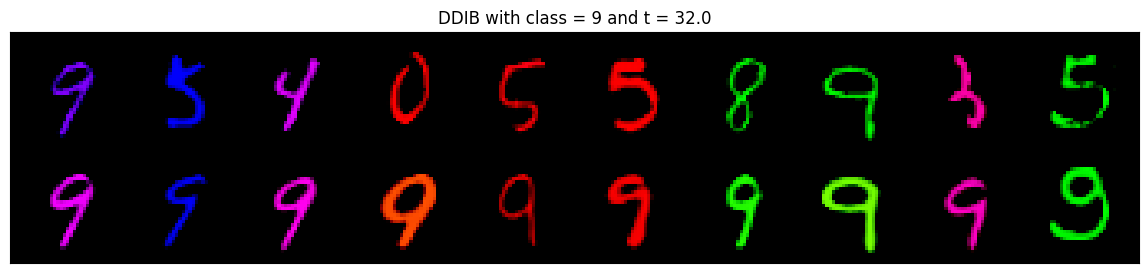

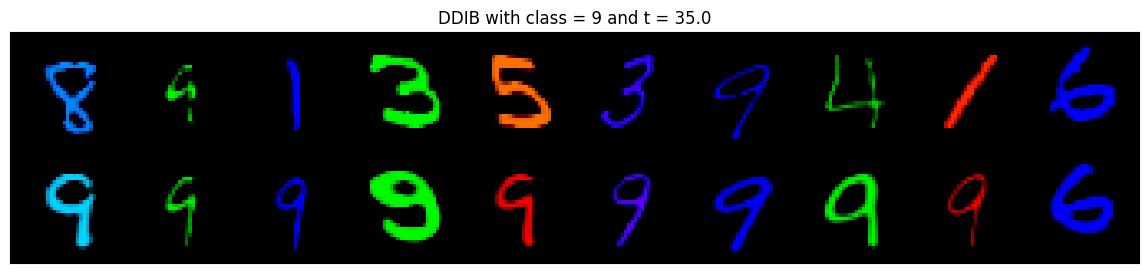

In [262]:
t_range = np.round(np.linspace(25, 35, 4))
for number in range(1, 10):
    for t in t_range:
        sampling_params = {
          'device': 'cuda',
          'sigma_min': 0.02,
          'sigma_max': t,
          'num_steps': 30,
          'rho': 7.0,
          'vis_steps': 1,
          'cfg': 1.0,
          'stochastic': False
        }

        x_source = (next(iter(train_dataloader))[0] * 2 - 1).cuda()[:10]
        y_source = next_iter[1].cuda()[:10] + 1
        y_source_ohe = torch.nn.functional.one_hot(y_source, num_classes=11).float().to('cuda')
        x_out, _, _ = ddib(cond_model, x_source, y_source_ohe, target_label=number, params=sampling_params)
        visualize_transform(x_source, x_out, title = f'DDIB with class = {number} and t = {t}')

В целом в большиестве случаев все хорошо, но при 30+ может теряться очертание фигуры и значение будет очень туслой, цифра состоит из малого числа пикселей. На глаз оптимум находится где-то между 20 и 30. Если ставит дефолт, говорить точечно, то 25.

## Сопоставление методов

Возьму по 3-5 (адекватных) значений $t$ для каждого из двух методов. Для каждого $t$ запущу метод (с тройками в качестве целевого домена) на подмножестве тестового датасета MNIST (1000-2000 картинок) и посчитаю две метрики:
* Средняя по датасету "похожесть" между входом и выходом, посчитанная как попиксельная $L_2$ норма разности;
* FID между сгенерированными тройками и тройками из трейн датасета (предпосчитанные статистики лежат в *cmnist_train_3.npz*).


In [75]:
sampling_params = {
  'device': 'cuda',
  'sigma_min': 0.02,
  'sigma_max': t,
  'num_steps': 30,
  'rho': 7.0,
  'vis_steps': 1,
  'cfg': 1.0,
  'stochastic': False
}


ddib_ = 0
sdedit_ = 0
t_range_ddib = [25, 26, 27, 28, 29]
t_range_sdedit = [50, 55, 60, 65, 70]

for i in range(5):

    next_iter = next(iter(train_dataloader))
    x_source = (next_iter[0] * 2 - 1).cuda()[:10]
    y_source = next_iter[1].cuda()[:10] + 1
    y_source_ohe = torch.nn.functional.one_hot(y_source, num_classes=11).float().to('cuda')

    sampling_params['sigma_max'] = t_range_ddib[i]
    x_out_ddib, _, _  = ddib(cond_model, x_source, y_source_ohe, target_label=3, params=sampling_params)
    ddib_ += torch.norm(x_out_ddib - x_source, p = 2)



    sampling_params['sigma_max'] = t_range_sdedit[i]
    x_out_sdedit = sdedit(cond_model, x_source, target_label=3, params=sampling_params)
    sdedit_ += torch.norm(x_out_sdedit - x_source, p = 2)





In [78]:
print(f'L2 норма для ddib: {ddib_/5}, для sdedit: {sdedit_/5}')

L2 норма для ddib: 60.420936584472656, для sdedit: 96.01396942138672


Замечу, то ddib лучше сохраняет цвет, что явно влияет на уменьшение L2 нормы. Отмечу также, что на глаз он лучше сохраняет наклон, что также существенно.

In [79]:
%cd edm
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url
%cd ..

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

/content/edm
/content


In [99]:
import os, shutil
from tqdm import tqdm
from random import sample

name = 'ddib_samples'
if os.path.exists(name):
    shutil.rmtree(name)
os.makedirs(name, exist_ok=True)
count = 0
num_samples = 2000
cond_model.eval()
with torch.no_grad():
  with tqdm(total= num_samples) as pbar:

    while count < num_samples:

      next_iter = next(iter(train_dataloader))
      x_source = (next_iter[0] * 2 - 1).cuda()[:10]
      y_source = next_iter[1].cuda()[:10] + 1
      y_source_ohe = torch.nn.functional.one_hot(y_source, num_classes=11).float().to('cuda')

      sampling_params['sigma_max'] = 25
      x_out_ddib, _, _  = ddib(cond_model, x_source, y_source_ohe, target_label=3, params=sampling_params)
      out = x_out_ddib
      out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
      for i in range(out.shape[0]):
          img = Image.fromarray(out[i])
          n_digits = len(str(count))
          img_name = (6 - n_digits) * '0' + str(count) + '.png'
          img.save(os.path.join(name, img_name))
          count += 1
          pbar.update(1)
          pbar.set_description('%d images saved' % (count,))

2000 images saved: 100%|██████████| 2000/2000 [03:45<00:00,  8.87it/s]


In [100]:
name = 'sdedit_samples'
if os.path.exists(name):
    shutil.rmtree(name)
os.makedirs(name, exist_ok=True)
count = 0
num_samples = 2000
cond_model.eval()
with torch.no_grad():
  with tqdm(total= num_samples) as pbar:

    while count < num_samples:

      next_iter = next(iter(train_dataloader))
      x_source = (next_iter[0] * 2 - 1).cuda()[:10]
      y_source = next_iter[1].cuda()[:10] + 1
      y_source_ohe = torch.nn.functional.one_hot(y_source, num_classes=11).float().to('cuda')

      sampling_params['sigma_max'] = 60
      x_out_sdedit = sdedit(cond_model, x_source, target_label=3, params=sampling_params)
      out = x_out_sdedit
      out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
      for i in range(out.shape[0]):
          img = Image.fromarray(out[i])
          n_digits = len(str(count))
          img_name = (6 - n_digits) * '0' + str(count) + '.png'
          img.save(os.path.join(name, img_name))
          count += 1
          pbar.update(1)
          pbar.set_description('%d images saved' % (count,))

2000 images saved: 100%|██████████| 2000/2000 [02:01<00:00, 16.49it/s]


In [101]:
fid_ddib = calc_fid('ddib_samples', 'cmnist_train_3.npz', num_expected=2000, batch=128)
print('ddib имеет FID = %.4g' % (fid_ddib,))

Loading Inception-v3 model...
Loading images from "ddib_samples"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:07<00:00,  2.15batch/s]


ddib имеет FID = 13.46


In [106]:
fid_sdedit = calc_fid('sdedit_samples', 'cmnist_train_3.npz', num_expected=2000, batch=128)
print('sdedit имеет FID = %.4g' % (fid_sdedit,))

Loading Inception-v3 model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading images from "sdedit_samples"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:07<00:00,  2.14batch/s]


sdedit имеет FID = 4.344


In [116]:
def create_scatter_plot(coords1, coords2):
    
    x1, y1 = coords1
    x2, y2 = coords2

    plt.scatter(x1, y1, color='red', label='DDIB', alpha=0.7)
    plt.scatter(x2, y2, color='black', label='SDEdit', alpha=0.7)
    plt.legend(title='Datasets')
    plt.xlabel('FID')
    plt.ylabel('L2-norm')
    plt.title('Fid и L2-norm для DDIB и SDEdit')
    plt.show()

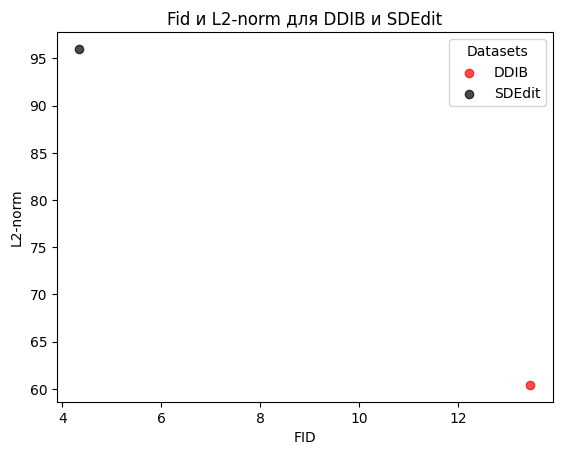

In [117]:
create_scatter_plot([fid_ddib, ddib_.detach().cpu()/5], [fid_sdedit, sdedit_.detach().cpu()/5])

SDEdit лучше выучивает распределение обучающих данных 3, в то время как DDIB ближе к изначальной картинке. Во-первых, суть задачи переноса стиля состоит в том, чтобы стиль оставался похожим с изначальной фотографией, сама постановка задачи может приводит к тому, что fid будет выше, чем какой-дь бейзлайн, так как перенесенный стиль может отличаться от всего того, что раньше у нас было в обущающихся данных (например, 3ки теперь стали более округлые, либо более острые чем раньше). В таком случае, мы должны ценить похожесть гораздо сильнее FID при условии, что итоговая картинка вышла хотя бы на глаз нормально (наверное можно это более формально выразить, например, поствить ограничение на fid < k). Но также стоит отметить, что у DDIB больше случаев плохого перевода картинки (например, могло быть, что не смог перевести 0 в 3 и итоговое изображение осталось похоже на 0, как было с 9кой), но таких случаев на глаз все же крайне мало. С другой стороны DDIB гораздо ближе по цвету, чем SDEEdit и ближе по наклону и фигуре. Но так как это задача переноса стиля, то я считаю SDEdit показал себя сильно лучше.